## Params and loading packages

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation=doc['annotation']



In [2]:

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

('Number of tissues: ', 16)


In [ ]:
from Modules.Homer import *

In [ ]:
print('Number of tissues: ',len(tissues))

### Load in meta_sampe

In [3]:
meta_samples = pd.read_csv('Results/meta_samples.csv',index_col=0)
meta_samples.head()

Experiment  \
BMDMwt/GRO/f04_peaks/merge_bg_2.peak          GRO   
Brain/GRO/f04_peaks/merge_bg_2.peak           GRO   
Brain/mSTART/f04_peaks/merge_bg_2.peak     mSTART   
Heart/mSTART/f04_peaks/merge_bg_2.peak     mSTART   
Kidney/GRO/f04_peaks/merge_bg_2.peak          GRO   

                                                                                     Full  \
BMDMwt/GRO/f04_peaks/merge_bg_2.peak    /data/isshamie/TSS/Processed/BMDMwt/GRO/f04_pe...   
Brain/GRO/f04_peaks/merge_bg_2.peak     /data/isshamie/TSS/Processed/Brain/GRO/f04_pea...   
Brain/mSTART/f04_peaks/merge_bg_2.peak  /data/isshamie/TSS/Processed/Brain/mSTART/f04_...   
Heart/mSTART/f04_peaks/merge_bg_2.peak  /data/isshamie/TSS/Processed/Heart/mSTART/f04_...   
Kidney/GRO/f04_peaks/merge_bg_2.peak    /data/isshamie/TSS/Processed/Kidney/GRO/f04_pe...   

                                               Short Short_with_number  Tissue  
BMDMwt/GRO/f04_peaks/merge_bg_2.peak      BMDMwt_GRO       BMDMwt_GRO1  BMDMwt  
Brain/GRO/f04_peaks/merge_bg_2.peak        Brain_GRO        Brain_GRO1   Brain  
Brain/mSTART/f04_peaks/merge_bg_2.peak  Brain_mSTART     Brain_mSTART1   Brain  
Heart/mSTART/f04_peaks/merge_bg_2.peak  Heart_mSTART     Heart_mSTART1   Heart  
Kidney/GRO/f04_peaks/merge_bg_2.peak      Kidney_GRO       Kidney_GRO1  Kidney

# Create tag directories of RNA

In [4]:
for f in glob.glob(os.path.join(data_folder ,'RNA_Total','*bam')):
    curr_f = os.path.basename(f).split('.')[0]
    out = os.path.join(os.path.join(data_folder ,'RNA_Total',curr_f))
    
    cmd = 'makeTagDirectory {out} -single {in_f} '.format(out=out,in_f=f)
    print(cmd)
    !{cmd}

makeTagDirectory /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001 -single /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001.fastq.bam 
	Will parse file: /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001.fastq.bam

	Creating directory: /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001 and removing existing *.tags.tsv

	Treating /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001.fastq.bam as a bam file
	Reading alignment file /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001.fastq.bam

	Optimizing tag files...
	Optimizing single genome.tags.tsv file...
	Estimated genome size = 2328016001
	Total Tags = 25459523.0
	Total Positions = 34650336
	Average tag length = 92.8
	Median tags per position = 0 (ideal: 1)
	Average tags per position = 0.293
	Fragment Length Estimate: 130
	Peak Width Estimate: 0
		!!! No reliable estimate for peak size
		Setting Peak width estimate to be equal to fragment length esti


	Optimizing tag files...
	Optimizing single genome.tags.tsv file...
	Estimated genome size = 2329212908
	Total Tags = 22125635.0
	Total Positions = 31513051
	Average tag length = 92.2
	Median tags per position = 0 (ideal: 1)
	Average tags per position = 0.256
	Fragment Length Estimate: 130
	Peak Width Estimate: 0
		!!! No reliable estimate for peak size
		Setting Peak width estimate to be equal to fragment length estimate
	Autocorrelation quality control metrics:
		Same strand fold enrichment: 1.5
		Diff strand fold enrichment: 1.6
		Same / Diff fold enrichment: 1.0

		Guessing sample is ChIP-Seq or unstranded RNA-Seq - autocorrelation looks good.

makeTagDirectory /data/isshamie/TSS/Processed/RNA_Total/NL10_Misc_S10_L006_R1_001 -single /data/isshamie/TSS/Processed/RNA_Total/NL10_Misc_S10_L006_R1_001.fastq.bam 
	Will parse file: /data/isshamie/TSS/Processed/RNA_Total/NL10_Misc_S10_L006_R1_001.fastq.bam

	Creating directory: /data/isshamie/TSS/Processed/RNA_Total/NL10_Misc_S10_L006_R1_

## Merge replicates (in this case Brain)

In [75]:
curr_out = os.path.join(data_folder,'RNA_Total')
cmd = 'makeTagDirectory {out_f} -single -d {rep1} {rep2}'.format(out_f=os.path.join(curr_out,'Combined_Brain'),
                                                        rep1=os.path.join(curr_out,'NL11_Brain7-1_S11_L006_R1_001'),
                                                        rep2=os.path.join(curr_out,'NL7_Brain2_S7_L006_R1_001'))
print(cmd)
!{cmd}

makeTagDirectory /data/isshamie/TSS/Processed/RNA_Total/Combined_Brain -single -d /data/isshamie/TSS/Processed/RNA_Total/NL11_Brain7-1_S11_L006_R1_001 /data/isshamie/TSS/Processed/RNA_Total/NL7_Brain2_S7_L006_R1_001
	Will add tag directory: /data/isshamie/TSS/Processed/RNA_Total/NL11_Brain7-1_S11_L006_R1_001
	Will add tag directory: /data/isshamie/TSS/Processed/RNA_Total/NL7_Brain2_S7_L006_R1_001

	Creating directory: /data/isshamie/TSS/Processed/RNA_Total/Combined_Brain and removing existing *.tags.tsv
	Adding tag directory /data/isshamie/TSS/Processed/RNA_Total/NL11_Brain7-1_S11_L006_R1_001
	Adding tag directory /data/isshamie/TSS/Processed/RNA_Total/NL7_Brain2_S7_L006_R1_001

	Optimizing tag files...
	Optimizing single genome.tags.tsv file...
	Estimated genome size = 2338237273
	Total Tags = 50968641.0
	Total Positions = 69562139
	Average tag length = 92.4
	Median tags per position = 0 (ideal: 1)
	Average tags per position = 0.297
	Fragment Length Estimate: 120
	Peak Width Estimate:

### Also merge every file together for later use

In [234]:
curr_out = os.path.join(data_folder,'RNA_Total/*')
files = glob.glob(curr_out)
rna_dirs = []
for f in files:
    if os.path.isdir(f) and 'Combined_Brain' not in f:
        rna_dirs.append(f)
cmd = 'makeTagDirectory {out_f} -single -d {all_rna}'.format(out_f='Results/merged/tags_rna_merged',
                                                        all_rna= ' '.join(rna_dirs))
print(cmd)
!{cmd}

makeTagDirectory Results/merged/tags_rna_merged -single -d /data/isshamie/TSS/Processed/RNA_Total/NL10_Misc_S10_L006_R1_001 /data/isshamie/TSS/Processed/RNA_Total/NL11_Brain7-1_S11_L006_R1_001 /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001 /data/isshamie/TSS/Processed/RNA_Total/NL4_Lung_S4_L006_R1_001 /data/isshamie/TSS/Processed/RNA_Total/NL8_Muscle_S8_L006_R1_001 /data/isshamie/TSS/Processed/RNA_Total/NL2_ReproductiveTract_S2_L006_R1_001 /data/isshamie/TSS/Processed/RNA_Total/NL5_Liver_S5_L006_R1_001 /data/isshamie/TSS/Processed/RNA_Total/NL7_Brain2_S7_L006_R1_001
	Will add tag directory: /data/isshamie/TSS/Processed/RNA_Total/NL10_Misc_S10_L006_R1_001
	Will add tag directory: /data/isshamie/TSS/Processed/RNA_Total/NL11_Brain7-1_S11_L006_R1_001
	Will add tag directory: /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001
	Will add tag directory: /data/isshamie/TSS/Processed/RNA_Total/NL4_Lung_S4_L006_R1_001
	Will add tag directory: /data/isshamie/TSS/Pro

# Create bedgraph files for RNA

In [70]:
for f in glob.glob(os.path.join(data_folder ,'RNA_Total','*bam')):
    curr_f = os.path.basename(f).split('.')[0]
    out = os.path.join(os.path.join(data_folder ,'RNA_Total',curr_f))

    cmd = 'makeUCSCfile {tag_d} -fragLength given -o auto'.format(tag_d=out)
    print(cmd)
    !{cmd}



makeUCSCfile /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001 -fragLength given -o auto

	Visualization fragment length = given
	Output file: /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001/NL3_Spleen_S3_L006_R1_001.ucsc.bedGraph
	No need to remove tags to get desired file size
	Generating bedGraph for picr_0
	Generating bedGraph for picr_1
	Generating bedGraph for picr_10
	Generating bedGraph for picr_100
	Generating bedGraph for picr_1000
	Generating bedGraph for picr_1002
	Generating bedGraph for picr_1003
	Generating bedGraph for picr_1005
	Generating bedGraph for picr_1006
	Generating bedGraph for picr_1008
	Generating bedGraph for picr_1009
	Generating bedGraph for picr_101
	Generating bedGraph for picr_1010
	Generating bedGraph for picr_1015
	Generating bedGraph for picr_1018
	Generating bedGraph for picr_102
	Generating bedGraph for picr_1021
	Generating bedGraph for picr_1022
	Generating bedGraph for picr_1023
	Generating bedGraph for picr_1028

	Generating bedGraph for picr_1311
	Generating bedGraph for picr_1313
	Generating bedGraph for picr_1314
	Generating bedGraph for picr_1315
	Generating bedGraph for picr_1316
	Generating bedGraph for picr_1317
	Generating bedGraph for picr_1318
	Generating bedGraph for picr_132
	Generating bedGraph for picr_1320
	Generating bedGraph for picr_1322
	Generating bedGraph for picr_1323
	Generating bedGraph for picr_1324
	Generating bedGraph for picr_1326
	Generating bedGraph for picr_1327
	Generating bedGraph for picr_1328
	Generating bedGraph for picr_1329
	Generating bedGraph for picr_133
	Generating bedGraph for picr_1330
	Generating bedGraph for picr_1332
	Generating bedGraph for picr_1335
	Generating bedGraph for picr_1336
	Generating bedGraph for picr_1337
	Generating bedGraph for picr_1338
	Generating bedGraph for picr_1339
	Generating bedGraph for picr_134
	Generating bedGraph for picr_1340
	Generating bedGraph for picr_1341
	Generating bedGraph for picr_1344
	Generating bedGraph fo

	Generating bedGraph for picr_1660
	Generating bedGraph for picr_1663
	Generating bedGraph for picr_1664
	Generating bedGraph for picr_1666
	Generating bedGraph for picr_1668
	Generating bedGraph for picr_1669
	Generating bedGraph for picr_167
	Generating bedGraph for picr_1670
	Generating bedGraph for picr_1672
	Generating bedGraph for picr_1673
	Generating bedGraph for picr_1674
	Generating bedGraph for picr_1675
	Generating bedGraph for picr_1677
	Generating bedGraph for picr_1678
	Generating bedGraph for picr_168
	Generating bedGraph for picr_1680
	Generating bedGraph for picr_1683
	Generating bedGraph for picr_1684
	Generating bedGraph for picr_1685
	Generating bedGraph for picr_1687
	Generating bedGraph for picr_1688
	Generating bedGraph for picr_169
	Generating bedGraph for picr_1699
	Generating bedGraph for picr_17
	Generating bedGraph for picr_170
	Generating bedGraph for picr_1700
	Generating bedGraph for picr_1701
	Generating bedGraph for picr_1702
	Generating bedGraph for p

	Generating bedGraph for picr_330
	Generating bedGraph for picr_331
	Generating bedGraph for picr_332
	Generating bedGraph for picr_333
	Generating bedGraph for picr_334
	Generating bedGraph for picr_336
	Generating bedGraph for picr_337
	Generating bedGraph for picr_338
	Generating bedGraph for picr_339
	Generating bedGraph for picr_34
	Generating bedGraph for picr_341
	Generating bedGraph for picr_342
	Generating bedGraph for picr_343
	Generating bedGraph for picr_346
	Generating bedGraph for picr_347
	Generating bedGraph for picr_348
	Generating bedGraph for picr_349
	Generating bedGraph for picr_35
	Generating bedGraph for picr_350
	Generating bedGraph for picr_351
	Generating bedGraph for picr_352
	Generating bedGraph for picr_353
	Generating bedGraph for picr_354
	Generating bedGraph for picr_355
	Generating bedGraph for picr_356
	Generating bedGraph for picr_357
	Generating bedGraph for picr_358
	Generating bedGraph for picr_359
	Generating bedGraph for picr_36
	Generating bedGr

	Generating bedGraph for picr_591
	Generating bedGraph for picr_592
	Generating bedGraph for picr_594
	Generating bedGraph for picr_595
	Generating bedGraph for picr_596
	Generating bedGraph for picr_597
	Generating bedGraph for picr_598
	Generating bedGraph for picr_6
	Generating bedGraph for picr_60
	Generating bedGraph for picr_601
	Generating bedGraph for picr_602
	Generating bedGraph for picr_603
	Generating bedGraph for picr_605
	Generating bedGraph for picr_606
	Generating bedGraph for picr_607
	Generating bedGraph for picr_608
	Generating bedGraph for picr_609
	Generating bedGraph for picr_61
	Generating bedGraph for picr_610
	Generating bedGraph for picr_612
	Generating bedGraph for picr_613
	Generating bedGraph for picr_615
	Generating bedGraph for picr_616
	Generating bedGraph for picr_619
	Generating bedGraph for picr_62
	Generating bedGraph for picr_620
	Generating bedGraph for picr_622
	Generating bedGraph for picr_623
	Generating bedGraph for picr_624
	Generating bedGrap

	Generating bedGraph for picr_891
	Generating bedGraph for picr_892
	Generating bedGraph for picr_893
	Generating bedGraph for picr_895
	Generating bedGraph for picr_896
	Generating bedGraph for picr_897
	Generating bedGraph for picr_899
	Generating bedGraph for picr_9
	Generating bedGraph for picr_90
	Generating bedGraph for picr_900
	Generating bedGraph for picr_901
	Generating bedGraph for picr_902
	Generating bedGraph for picr_904
	Generating bedGraph for picr_905
	Generating bedGraph for picr_906
	Generating bedGraph for picr_91
	Generating bedGraph for picr_910
	Generating bedGraph for picr_911
	Generating bedGraph for picr_914
	Generating bedGraph for picr_915
	Generating bedGraph for picr_916
	Generating bedGraph for picr_917
	Generating bedGraph for picr_919
	Generating bedGraph for picr_92
	Generating bedGraph for picr_921
	Generating bedGraph for picr_924
	Generating bedGraph for picr_925
	Generating bedGraph for picr_926
	Generating bedGraph for picr_927
	Generating bedGrap

	Generating bedGraph for picr_1160
	Generating bedGraph for picr_1161
	Generating bedGraph for picr_1162
	Generating bedGraph for picr_1164
	Generating bedGraph for picr_1165
	Generating bedGraph for picr_1167
	Generating bedGraph for picr_1168
	Generating bedGraph for picr_117
	Generating bedGraph for picr_1172
	Generating bedGraph for picr_1173
	Generating bedGraph for picr_1174
	Generating bedGraph for picr_1175
	Generating bedGraph for picr_1177
	Generating bedGraph for picr_1178
	Generating bedGraph for picr_1179
	Generating bedGraph for picr_118
	Generating bedGraph for picr_1180
	Generating bedGraph for picr_1181
	Generating bedGraph for picr_1182
	Generating bedGraph for picr_1183
	Generating bedGraph for picr_1184
	Generating bedGraph for picr_1185
	Generating bedGraph for picr_1186
	Generating bedGraph for picr_1187
	Generating bedGraph for picr_1188
	Generating bedGraph for picr_119
	Generating bedGraph for picr_1190
	Generating bedGraph for picr_1192
	Generating bedGraph fo

	Generating bedGraph for picr_1463
	Generating bedGraph for picr_1464
	Generating bedGraph for picr_1465
	Generating bedGraph for picr_1467
	Generating bedGraph for picr_147
	Generating bedGraph for picr_1473
	Generating bedGraph for picr_1474
	Generating bedGraph for picr_1476
	Generating bedGraph for picr_1477
	Generating bedGraph for picr_1478
	Generating bedGraph for picr_1479
	Generating bedGraph for picr_148
	Generating bedGraph for picr_1480
	Generating bedGraph for picr_1482
	Generating bedGraph for picr_1483
	Generating bedGraph for picr_1485
	Generating bedGraph for picr_1486
	Generating bedGraph for picr_1487
	Generating bedGraph for picr_1488
	Generating bedGraph for picr_1489
	Generating bedGraph for picr_149
	Generating bedGraph for picr_1490
	Generating bedGraph for picr_1491
	Generating bedGraph for picr_1494
	Generating bedGraph for picr_1496
	Generating bedGraph for picr_1497
	Generating bedGraph for picr_1498
	Generating bedGraph for picr_15
	Generating bedGraph for 

	Generating bedGraph for picr_180
	Generating bedGraph for picr_1801
	Generating bedGraph for picr_1802
	Generating bedGraph for picr_1803
	Generating bedGraph for picr_1804
	Generating bedGraph for picr_1806
	Generating bedGraph for picr_1809
	Generating bedGraph for picr_181
	Generating bedGraph for picr_1810
	Generating bedGraph for picr_1813
	Generating bedGraph for picr_1816
	Generating bedGraph for picr_1817
	Generating bedGraph for picr_1818
	Generating bedGraph for picr_1819
	Generating bedGraph for picr_182
	Generating bedGraph for picr_1820
	Generating bedGraph for picr_1821
	Generating bedGraph for picr_1822
	Generating bedGraph for picr_1826
	Generating bedGraph for picr_183
	Generating bedGraph for picr_184
	Generating bedGraph for picr_185
	Generating bedGraph for picr_186
	Generating bedGraph for picr_187
	Generating bedGraph for picr_188
	Generating bedGraph for picr_189
	Generating bedGraph for picr_19
	Generating bedGraph for picr_190
	Generating bedGraph for picr_191

	Generating bedGraph for picr_410
	Generating bedGraph for picr_411
	Generating bedGraph for picr_414
	Generating bedGraph for picr_415
	Generating bedGraph for picr_416
	Generating bedGraph for picr_417
	Generating bedGraph for picr_418
	Generating bedGraph for picr_419
	Generating bedGraph for picr_42
	Generating bedGraph for picr_420
	Generating bedGraph for picr_421
	Generating bedGraph for picr_422
	Generating bedGraph for picr_423
	Generating bedGraph for picr_426
	Generating bedGraph for picr_427
	Generating bedGraph for picr_428
	Generating bedGraph for picr_429
	Generating bedGraph for picr_43
	Generating bedGraph for picr_430
	Generating bedGraph for picr_431
	Generating bedGraph for picr_432
	Generating bedGraph for picr_433
	Generating bedGraph for picr_434
	Generating bedGraph for picr_435
	Generating bedGraph for picr_436
	Generating bedGraph for picr_437
	Generating bedGraph for picr_438
	Generating bedGraph for picr_439
	Generating bedGraph for picr_44
	Generating bedGr

	Generating bedGraph for picr_690
	Generating bedGraph for picr_691
	Generating bedGraph for picr_692
	Generating bedGraph for picr_693
	Generating bedGraph for picr_694
	Generating bedGraph for picr_697
	Generating bedGraph for picr_698
	Generating bedGraph for picr_699
	Generating bedGraph for picr_70
	Generating bedGraph for picr_700
	Generating bedGraph for picr_703
	Generating bedGraph for picr_704
	Generating bedGraph for picr_706
	Generating bedGraph for picr_707
	Generating bedGraph for picr_708
	Generating bedGraph for picr_709
	Generating bedGraph for picr_71
	Generating bedGraph for picr_710
	Generating bedGraph for picr_711
	Generating bedGraph for picr_712
	Generating bedGraph for picr_713
	Generating bedGraph for picr_715
	Generating bedGraph for picr_717
	Generating bedGraph for picr_719
	Generating bedGraph for picr_72
	Generating bedGraph for picr_720
	Generating bedGraph for picr_721
	Generating bedGraph for picr_722
	Generating bedGraph for picr_723
	Generating bedGr

	Generating bedGraph for picr_983
	Generating bedGraph for picr_985
	Generating bedGraph for picr_986
	Generating bedGraph for picr_987
	Generating bedGraph for picr_99
	Generating bedGraph for picr_990
	Generating bedGraph for picr_991
	Generating bedGraph for picr_992
	Generating bedGraph for picr_993
	Generating bedGraph for picr_994
	Generating bedGraph for picr_995
	Generating bedGraph for picr_996
	Generating bedGraph for picr_998
	Generating bedGraph for picr_999
	Gzipping file /data/isshamie/TSS/Processed/RNA_Total/NL2_ReproductiveTract_S2_L006_R1_001/NL2_ReproductiveTract_S2_L006_R1_001.ucsc.bedGraph
makeUCSCfile /data/isshamie/TSS/Processed/RNA_Total/NL5_Liver_S5_L006_R1_001 -fragLength given -o auto

	Visualization fragment length = given
	Output file: /data/isshamie/TSS/Processed/RNA_Total/NL5_Liver_S5_L006_R1_001/NL5_Liver_S5_L006_R1_001.ucsc.bedGraph
	No need to remove tags to get desired file size
	Generating bedGraph for picr_0
	Generating bedGraph for picr_1
	Generatin

	Generating bedGraph for picr_1352
	Generating bedGraph for picr_1357
	Generating bedGraph for picr_136
	Generating bedGraph for picr_1360
	Generating bedGraph for picr_1363
	Generating bedGraph for picr_1367
	Generating bedGraph for picr_1368
	Generating bedGraph for picr_137
	Generating bedGraph for picr_1370
	Generating bedGraph for picr_1373
	Generating bedGraph for picr_1374
	Generating bedGraph for picr_1375
	Generating bedGraph for picr_1378
	Generating bedGraph for picr_138
	Generating bedGraph for picr_1381
	Generating bedGraph for picr_1382
	Generating bedGraph for picr_1384
	Generating bedGraph for picr_1386
	Generating bedGraph for picr_1387
	Generating bedGraph for picr_1388
	Generating bedGraph for picr_139
	Generating bedGraph for picr_1391
	Generating bedGraph for picr_1393
	Generating bedGraph for picr_1395
	Generating bedGraph for picr_1396
	Generating bedGraph for picr_1398
	Generating bedGraph for picr_1399
	Generating bedGraph for picr_14
	Generating bedGraph for p

	Generating bedGraph for picr_180
	Generating bedGraph for picr_1802
	Generating bedGraph for picr_1803
	Generating bedGraph for picr_181
	Generating bedGraph for picr_1810
	Generating bedGraph for picr_1813
	Generating bedGraph for picr_1816
	Generating bedGraph for picr_1817
	Generating bedGraph for picr_1819
	Generating bedGraph for picr_182
	Generating bedGraph for picr_1820
	Generating bedGraph for picr_1822
	Generating bedGraph for picr_1824
	Generating bedGraph for picr_183
	Generating bedGraph for picr_184
	Generating bedGraph for picr_185
	Generating bedGraph for picr_186
	Generating bedGraph for picr_187
	Generating bedGraph for picr_188
	Generating bedGraph for picr_189
	Generating bedGraph for picr_19
	Generating bedGraph for picr_190
	Generating bedGraph for picr_191
	Generating bedGraph for picr_192
	Generating bedGraph for picr_193
	Generating bedGraph for picr_194
	Generating bedGraph for picr_195
	Generating bedGraph for picr_196
	Generating bedGraph for picr_197
	Gene

	Generating bedGraph for picr_441
	Generating bedGraph for picr_443
	Generating bedGraph for picr_444
	Generating bedGraph for picr_446
	Generating bedGraph for picr_45
	Generating bedGraph for picr_450
	Generating bedGraph for picr_452
	Generating bedGraph for picr_454
	Generating bedGraph for picr_455
	Generating bedGraph for picr_456
	Generating bedGraph for picr_457
	Generating bedGraph for picr_459
	Generating bedGraph for picr_46
	Generating bedGraph for picr_460
	Generating bedGraph for picr_461
	Generating bedGraph for picr_462
	Generating bedGraph for picr_463
	Generating bedGraph for picr_464
	Generating bedGraph for picr_466
	Generating bedGraph for picr_468
	Generating bedGraph for picr_469
	Generating bedGraph for picr_47
	Generating bedGraph for picr_472
	Generating bedGraph for picr_473
	Generating bedGraph for picr_474
	Generating bedGraph for picr_475
	Generating bedGraph for picr_477
	Generating bedGraph for picr_479
	Generating bedGraph for picr_48
	Generating bedGra

	Generating bedGraph for picr_770
	Generating bedGraph for picr_774
	Generating bedGraph for picr_775
	Generating bedGraph for picr_776
	Generating bedGraph for picr_777
	Generating bedGraph for picr_778
	Generating bedGraph for picr_779
	Generating bedGraph for picr_78
	Generating bedGraph for picr_782
	Generating bedGraph for picr_783
	Generating bedGraph for picr_788
	Generating bedGraph for picr_789
	Generating bedGraph for picr_79
	Generating bedGraph for picr_790
	Generating bedGraph for picr_792
	Generating bedGraph for picr_793
	Generating bedGraph for picr_794
	Generating bedGraph for picr_795
	Generating bedGraph for picr_796
	Generating bedGraph for picr_797
	Generating bedGraph for picr_798
	Generating bedGraph for picr_799
	Generating bedGraph for picr_7a
	Generating bedGraph for picr_7b
	Generating bedGraph for picr_8
	Generating bedGraph for picr_80
	Generating bedGraph for picr_802
	Generating bedGraph for picr_803
	Generating bedGraph for picr_804
	Generating bedGraph 

	Generating bedGraph for picr_1120
	Generating bedGraph for picr_1124
	Generating bedGraph for picr_1126
	Generating bedGraph for picr_1127
	Generating bedGraph for picr_1129
	Generating bedGraph for picr_113
	Generating bedGraph for picr_1130
	Generating bedGraph for picr_1131
	Generating bedGraph for picr_1132
	Generating bedGraph for picr_1133
	Generating bedGraph for picr_1135
	Generating bedGraph for picr_1136
	Generating bedGraph for picr_1137
	Generating bedGraph for picr_1138
	Generating bedGraph for picr_1139
	Generating bedGraph for picr_114
	Generating bedGraph for picr_1142
	Generating bedGraph for picr_1143
	Generating bedGraph for picr_1144
	Generating bedGraph for picr_1145
	Generating bedGraph for picr_1147
	Generating bedGraph for picr_1148
	Generating bedGraph for picr_115
	Generating bedGraph for picr_1150
	Generating bedGraph for picr_1152
	Generating bedGraph for picr_116
	Generating bedGraph for picr_1160
	Generating bedGraph for picr_1162
	Generating bedGraph for

	Generating bedGraph for picr_1482
	Generating bedGraph for picr_1483
	Generating bedGraph for picr_1486
	Generating bedGraph for picr_1489
	Generating bedGraph for picr_149
	Generating bedGraph for picr_1490
	Generating bedGraph for picr_1491
	Generating bedGraph for picr_1496
	Generating bedGraph for picr_1497
	Generating bedGraph for picr_1498
	Generating bedGraph for picr_1499
	Generating bedGraph for picr_15
	Generating bedGraph for picr_150
	Generating bedGraph for picr_1500
	Generating bedGraph for picr_1501
	Generating bedGraph for picr_1502
	Generating bedGraph for picr_1503
	Generating bedGraph for picr_1505
	Generating bedGraph for picr_1508
	Generating bedGraph for picr_151
	Generating bedGraph for picr_1512
	Generating bedGraph for picr_1515
	Generating bedGraph for picr_1516
	Generating bedGraph for picr_1517
	Generating bedGraph for picr_1518
	Generating bedGraph for picr_152
	Generating bedGraph for picr_1520
	Generating bedGraph for picr_1523
	Generating bedGraph for p

	Generating bedGraph for picr_220
	Generating bedGraph for picr_221
	Generating bedGraph for picr_222
	Generating bedGraph for picr_223
	Generating bedGraph for picr_224
	Generating bedGraph for picr_225
	Generating bedGraph for picr_226
	Generating bedGraph for picr_227
	Generating bedGraph for picr_228
	Generating bedGraph for picr_229
	Generating bedGraph for picr_23
	Generating bedGraph for picr_230
	Generating bedGraph for picr_231
	Generating bedGraph for picr_232
	Generating bedGraph for picr_233
	Generating bedGraph for picr_234
	Generating bedGraph for picr_235
	Generating bedGraph for picr_236
	Generating bedGraph for picr_237
	Generating bedGraph for picr_238
	Generating bedGraph for picr_24
	Generating bedGraph for picr_241
	Generating bedGraph for picr_242
	Generating bedGraph for picr_244
	Generating bedGraph for picr_245
	Generating bedGraph for picr_246
	Generating bedGraph for picr_247
	Generating bedGraph for picr_248
	Generating bedGraph for picr_249
	Generating bedG

	Generating bedGraph for picr_480
	Generating bedGraph for picr_481
	Generating bedGraph for picr_483
	Generating bedGraph for picr_485
	Generating bedGraph for picr_486
	Generating bedGraph for picr_487
	Generating bedGraph for picr_488
	Generating bedGraph for picr_49
	Generating bedGraph for picr_490
	Generating bedGraph for picr_491
	Generating bedGraph for picr_492
	Generating bedGraph for picr_496
	Generating bedGraph for picr_498
	Generating bedGraph for picr_499
	Generating bedGraph for picr_5
	Generating bedGraph for picr_50
	Generating bedGraph for picr_500
	Generating bedGraph for picr_501
	Generating bedGraph for picr_502
	Generating bedGraph for picr_503
	Generating bedGraph for picr_504
	Generating bedGraph for picr_506
	Generating bedGraph for picr_507
	Generating bedGraph for picr_509
	Generating bedGraph for picr_51
	Generating bedGraph for picr_512
	Generating bedGraph for picr_513
	Generating bedGraph for picr_514
	Generating bedGraph for picr_515
	Generating bedGrap

	Generating bedGraph for picr_790
	Generating bedGraph for picr_792
	Generating bedGraph for picr_793
	Generating bedGraph for picr_794
	Generating bedGraph for picr_798
	Generating bedGraph for picr_799
	Generating bedGraph for picr_7a
	Generating bedGraph for picr_7b
	Generating bedGraph for picr_8
	Generating bedGraph for picr_80
	Generating bedGraph for picr_801
	Generating bedGraph for picr_802
	Generating bedGraph for picr_803
	Generating bedGraph for picr_804
	Generating bedGraph for picr_805
	Generating bedGraph for picr_806
	Generating bedGraph for picr_808
	Generating bedGraph for picr_81
	Generating bedGraph for picr_810
	Generating bedGraph for picr_811
	Generating bedGraph for picr_813
	Generating bedGraph for picr_817
	Generating bedGraph for picr_818
	Generating bedGraph for picr_82
	Generating bedGraph for picr_820
	Generating bedGraph for picr_821
	Generating bedGraph for picr_822
	Generating bedGraph for picr_825
	Generating bedGraph for picr_826
	Generating bedGraph 

	Generating bedGraph for picr_1110
	Generating bedGraph for picr_1111
	Generating bedGraph for picr_1112
	Generating bedGraph for picr_1113
	Generating bedGraph for picr_1115
	Generating bedGraph for picr_1118
	Generating bedGraph for picr_1119
	Generating bedGraph for picr_112
	Generating bedGraph for picr_1120
	Generating bedGraph for picr_1124
	Generating bedGraph for picr_1126
	Generating bedGraph for picr_1127
	Generating bedGraph for picr_1129
	Generating bedGraph for picr_113
	Generating bedGraph for picr_1130
	Generating bedGraph for picr_1131
	Generating bedGraph for picr_1132
	Generating bedGraph for picr_1133
	Generating bedGraph for picr_1134
	Generating bedGraph for picr_1135
	Generating bedGraph for picr_1136
	Generating bedGraph for picr_1137
	Generating bedGraph for picr_1138
	Generating bedGraph for picr_1139
	Generating bedGraph for picr_114
	Generating bedGraph for picr_1142
	Generating bedGraph for picr_1143
	Generating bedGraph for picr_1144
	Generating bedGraph fo

	Generating bedGraph for picr_1460
	Generating bedGraph for picr_1463
	Generating bedGraph for picr_1464
	Generating bedGraph for picr_1465
	Generating bedGraph for picr_1467
	Generating bedGraph for picr_147
	Generating bedGraph for picr_1471
	Generating bedGraph for picr_1473
	Generating bedGraph for picr_1474
	Generating bedGraph for picr_1476
	Generating bedGraph for picr_1477
	Generating bedGraph for picr_1478
	Generating bedGraph for picr_1479
	Generating bedGraph for picr_148
	Generating bedGraph for picr_1480
	Generating bedGraph for picr_1481
	Generating bedGraph for picr_1482
	Generating bedGraph for picr_1483
	Generating bedGraph for picr_1486
	Generating bedGraph for picr_1487
	Generating bedGraph for picr_1489
	Generating bedGraph for picr_149
	Generating bedGraph for picr_1490
	Generating bedGraph for picr_1491
	Generating bedGraph for picr_1495
	Generating bedGraph for picr_1496
	Generating bedGraph for picr_1497
	Generating bedGraph for picr_1498
	Generating bedGraph fo

	Generating bedGraph for picr_190
	Generating bedGraph for picr_191
	Generating bedGraph for picr_192
	Generating bedGraph for picr_193
	Generating bedGraph for picr_194
	Generating bedGraph for picr_195
	Generating bedGraph for picr_196
	Generating bedGraph for picr_197
	Generating bedGraph for picr_198
	Generating bedGraph for picr_199
	Generating bedGraph for picr_2
	Generating bedGraph for picr_20
	Generating bedGraph for picr_200
	Generating bedGraph for picr_201
	Generating bedGraph for picr_202
	Generating bedGraph for picr_203
	Generating bedGraph for picr_204
	Generating bedGraph for picr_205
	Generating bedGraph for picr_207
	Generating bedGraph for picr_208
	Generating bedGraph for picr_209
	Generating bedGraph for picr_21
	Generating bedGraph for picr_210
	Generating bedGraph for picr_211
	Generating bedGraph for picr_212
	Generating bedGraph for picr_213
	Generating bedGraph for picr_214
	Generating bedGraph for picr_215
	Generating bedGraph for picr_216
	Generating bedGra

	Generating bedGraph for picr_460
	Generating bedGraph for picr_461
	Generating bedGraph for picr_462
	Generating bedGraph for picr_463
	Generating bedGraph for picr_466
	Generating bedGraph for picr_469
	Generating bedGraph for picr_47
	Generating bedGraph for picr_472
	Generating bedGraph for picr_475
	Generating bedGraph for picr_476
	Generating bedGraph for picr_479
	Generating bedGraph for picr_48
	Generating bedGraph for picr_480
	Generating bedGraph for picr_483
	Generating bedGraph for picr_484
	Generating bedGraph for picr_485
	Generating bedGraph for picr_487
	Generating bedGraph for picr_49
	Generating bedGraph for picr_490
	Generating bedGraph for picr_491
	Generating bedGraph for picr_496
	Generating bedGraph for picr_498
	Generating bedGraph for picr_5
	Generating bedGraph for picr_50
	Generating bedGraph for picr_500
	Generating bedGraph for picr_502
	Generating bedGraph for picr_503
	Generating bedGraph for picr_504
	Generating bedGraph for picr_505
	Generating bedGraph

	Generating bedGraph for picr_790
	Generating bedGraph for picr_791
	Generating bedGraph for picr_792
	Generating bedGraph for picr_793
	Generating bedGraph for picr_794
	Generating bedGraph for picr_795
	Generating bedGraph for picr_797
	Generating bedGraph for picr_798
	Generating bedGraph for picr_799
	Generating bedGraph for picr_7a
	Generating bedGraph for picr_7b
	Generating bedGraph for picr_8
	Generating bedGraph for picr_80
	Generating bedGraph for picr_801
	Generating bedGraph for picr_802
	Generating bedGraph for picr_803
	Generating bedGraph for picr_804
	Generating bedGraph for picr_806
	Generating bedGraph for picr_807
	Generating bedGraph for picr_808
	Generating bedGraph for picr_81
	Generating bedGraph for picr_810
	Generating bedGraph for picr_811
	Generating bedGraph for picr_813
	Generating bedGraph for picr_814
	Generating bedGraph for picr_816
	Generating bedGraph for picr_817
	Generating bedGraph for picr_818
	Generating bedGraph for picr_82
	Generating bedGraph 

	Generating bedGraph for picr_1051
	Generating bedGraph for picr_1052
	Generating bedGraph for picr_1053
	Generating bedGraph for picr_1055
	Generating bedGraph for picr_1056
	Generating bedGraph for picr_1057
	Generating bedGraph for picr_1058
	Generating bedGraph for picr_106
	Generating bedGraph for picr_1061
	Generating bedGraph for picr_1063
	Generating bedGraph for picr_1065
	Generating bedGraph for picr_1066
	Generating bedGraph for picr_1068
	Generating bedGraph for picr_107
	Generating bedGraph for picr_1070
	Generating bedGraph for picr_1071
	Generating bedGraph for picr_1073
	Generating bedGraph for picr_1074
	Generating bedGraph for picr_1075
	Generating bedGraph for picr_1076
	Generating bedGraph for picr_1077
	Generating bedGraph for picr_1078
	Generating bedGraph for picr_108
	Generating bedGraph for picr_1080
	Generating bedGraph for picr_1081
	Generating bedGraph for picr_1082
	Generating bedGraph for picr_1083
	Generating bedGraph for picr_1085
	Generating bedGraph fo

	Generating bedGraph for picr_1380
	Generating bedGraph for picr_1382
	Generating bedGraph for picr_1386
	Generating bedGraph for picr_1387
	Generating bedGraph for picr_1388
	Generating bedGraph for picr_1389
	Generating bedGraph for picr_139
	Generating bedGraph for picr_1390
	Generating bedGraph for picr_1391
	Generating bedGraph for picr_1392
	Generating bedGraph for picr_1393
	Generating bedGraph for picr_1395
	Generating bedGraph for picr_1396
	Generating bedGraph for picr_1398
	Generating bedGraph for picr_1399
	Generating bedGraph for picr_14
	Generating bedGraph for picr_140
	Generating bedGraph for picr_1400
	Generating bedGraph for picr_1401
	Generating bedGraph for picr_1403
	Generating bedGraph for picr_1406
	Generating bedGraph for picr_1408
	Generating bedGraph for picr_141
	Generating bedGraph for picr_1411
	Generating bedGraph for picr_1412
	Generating bedGraph for picr_1413
	Generating bedGraph for picr_1415
	Generating bedGraph for picr_1416
	Generating bedGraph for 

	Generating bedGraph for picr_1740
	Generating bedGraph for picr_1744
	Generating bedGraph for picr_1745
	Generating bedGraph for picr_1746
	Generating bedGraph for picr_1748
	Generating bedGraph for picr_175
	Generating bedGraph for picr_1750
	Generating bedGraph for picr_1754
	Generating bedGraph for picr_1755
	Generating bedGraph for picr_1757
	Generating bedGraph for picr_1759
	Generating bedGraph for picr_176
	Generating bedGraph for picr_1761
	Generating bedGraph for picr_1762
	Generating bedGraph for picr_1764
	Generating bedGraph for picr_1765
	Generating bedGraph for picr_1767
	Generating bedGraph for picr_1769
	Generating bedGraph for picr_177
	Generating bedGraph for picr_1774
	Generating bedGraph for picr_1776
	Generating bedGraph for picr_178
	Generating bedGraph for picr_1787
	Generating bedGraph for picr_1789
	Generating bedGraph for picr_179
	Generating bedGraph for picr_1790
	Generating bedGraph for picr_1791
	Generating bedGraph for picr_1792
	Generating bedGraph for 

	Generating bedGraph for picr_380
	Generating bedGraph for picr_381
	Generating bedGraph for picr_382
	Generating bedGraph for picr_383
	Generating bedGraph for picr_384
	Generating bedGraph for picr_385
	Generating bedGraph for picr_386
	Generating bedGraph for picr_388
	Generating bedGraph for picr_389
	Generating bedGraph for picr_39
	Generating bedGraph for picr_390
	Generating bedGraph for picr_391
	Generating bedGraph for picr_392
	Generating bedGraph for picr_393
	Generating bedGraph for picr_394
	Generating bedGraph for picr_395
	Generating bedGraph for picr_396
	Generating bedGraph for picr_397
	Generating bedGraph for picr_398
	Generating bedGraph for picr_399
	Generating bedGraph for picr_4
	Generating bedGraph for picr_40
	Generating bedGraph for picr_400
	Generating bedGraph for picr_401
	Generating bedGraph for picr_402
	Generating bedGraph for picr_403
	Generating bedGraph for picr_404
	Generating bedGraph for picr_407
	Generating bedGraph for picr_408
	Generating bedGra

	Generating bedGraph for picr_650
	Generating bedGraph for picr_651
	Generating bedGraph for picr_652
	Generating bedGraph for picr_653
	Generating bedGraph for picr_654
	Generating bedGraph for picr_656
	Generating bedGraph for picr_657
	Generating bedGraph for picr_658
	Generating bedGraph for picr_659
	Generating bedGraph for picr_66
	Generating bedGraph for picr_660
	Generating bedGraph for picr_661
	Generating bedGraph for picr_662
	Generating bedGraph for picr_663
	Generating bedGraph for picr_664
	Generating bedGraph for picr_665
	Generating bedGraph for picr_666
	Generating bedGraph for picr_668
	Generating bedGraph for picr_67
	Generating bedGraph for picr_671
	Generating bedGraph for picr_672
	Generating bedGraph for picr_674
	Generating bedGraph for picr_676
	Generating bedGraph for picr_678
	Generating bedGraph for picr_679
	Generating bedGraph for picr_68
	Generating bedGraph for picr_680
	Generating bedGraph for picr_681
	Generating bedGraph for picr_684
	Generating bedGr

	Generating bedGraph for picr_950
	Generating bedGraph for picr_951
	Generating bedGraph for picr_952
	Generating bedGraph for picr_953
	Generating bedGraph for picr_954
	Generating bedGraph for picr_955
	Generating bedGraph for picr_956
	Generating bedGraph for picr_96
	Generating bedGraph for picr_960
	Generating bedGraph for picr_961
	Generating bedGraph for picr_962
	Generating bedGraph for picr_964
	Generating bedGraph for picr_966
	Generating bedGraph for picr_968
	Generating bedGraph for picr_969
	Generating bedGraph for picr_97
	Generating bedGraph for picr_970
	Generating bedGraph for picr_971
	Generating bedGraph for picr_972
	Generating bedGraph for picr_973
	Generating bedGraph for picr_974
	Generating bedGraph for picr_975
	Generating bedGraph for picr_976
	Generating bedGraph for picr_98
	Generating bedGraph for picr_983
	Generating bedGraph for picr_985
	Generating bedGraph for picr_986
	Generating bedGraph for picr_987
	Generating bedGraph for picr_988
	Generating bedGr

	Generating bedGraph for picr_1261
	Generating bedGraph for picr_1262
	Generating bedGraph for picr_1263
	Generating bedGraph for picr_1264
	Generating bedGraph for picr_1265
	Generating bedGraph for picr_1266
	Generating bedGraph for picr_1268
	Generating bedGraph for picr_1269
	Generating bedGraph for picr_127
	Generating bedGraph for picr_1270
	Generating bedGraph for picr_1275
	Generating bedGraph for picr_1277
	Generating bedGraph for picr_1278
	Generating bedGraph for picr_128
	Generating bedGraph for picr_1281
	Generating bedGraph for picr_1283
	Generating bedGraph for picr_1285
	Generating bedGraph for picr_1286
	Generating bedGraph for picr_1287
	Generating bedGraph for picr_1288
	Generating bedGraph for picr_1289
	Generating bedGraph for picr_129
	Generating bedGraph for picr_1292
	Generating bedGraph for picr_1293
	Generating bedGraph for picr_1294
	Generating bedGraph for picr_1295
	Generating bedGraph for picr_1296
	Generating bedGraph for picr_1297
	Generating bedGraph fo

	Generating bedGraph for picr_1601
	Generating bedGraph for picr_1603
	Generating bedGraph for picr_1605
	Generating bedGraph for picr_161
	Generating bedGraph for picr_1611
	Generating bedGraph for picr_1614
	Generating bedGraph for picr_1615
	Generating bedGraph for picr_162
	Generating bedGraph for picr_1621
	Generating bedGraph for picr_1623
	Generating bedGraph for picr_1625
	Generating bedGraph for picr_1627
	Generating bedGraph for picr_1628
	Generating bedGraph for picr_1629
	Generating bedGraph for picr_163
	Generating bedGraph for picr_1631
	Generating bedGraph for picr_1632
	Generating bedGraph for picr_1633
	Generating bedGraph for picr_1634
	Generating bedGraph for picr_164
	Generating bedGraph for picr_1640
	Generating bedGraph for picr_1645
	Generating bedGraph for picr_1646
	Generating bedGraph for picr_1647
	Generating bedGraph for picr_165
	Generating bedGraph for picr_1650
	Generating bedGraph for picr_1651
	Generating bedGraph for picr_1656
	Generating bedGraph for 

	Generating bedGraph for picr_30
	Generating bedGraph for picr_300
	Generating bedGraph for picr_301
	Generating bedGraph for picr_302
	Generating bedGraph for picr_303
	Generating bedGraph for picr_304
	Generating bedGraph for picr_306
	Generating bedGraph for picr_308
	Generating bedGraph for picr_309
	Generating bedGraph for picr_31
	Generating bedGraph for picr_310
	Generating bedGraph for picr_311
	Generating bedGraph for picr_312
	Generating bedGraph for picr_313
	Generating bedGraph for picr_314
	Generating bedGraph for picr_315
	Generating bedGraph for picr_316
	Generating bedGraph for picr_317
	Generating bedGraph for picr_318
	Generating bedGraph for picr_319
	Generating bedGraph for picr_32
	Generating bedGraph for picr_321
	Generating bedGraph for picr_322
	Generating bedGraph for picr_323
	Generating bedGraph for picr_325
	Generating bedGraph for picr_326
	Generating bedGraph for picr_328
	Generating bedGraph for picr_329
	Generating bedGraph for picr_33
	Generating bedGra

	Generating bedGraph for picr_550
	Generating bedGraph for picr_551
	Generating bedGraph for picr_554
	Generating bedGraph for picr_555
	Generating bedGraph for picr_556
	Generating bedGraph for picr_557
	Generating bedGraph for picr_558
	Generating bedGraph for picr_559
	Generating bedGraph for picr_56
	Generating bedGraph for picr_561
	Generating bedGraph for picr_562
	Generating bedGraph for picr_563
	Generating bedGraph for picr_566
	Generating bedGraph for picr_567
	Generating bedGraph for picr_568
	Generating bedGraph for picr_57
	Generating bedGraph for picr_571
	Generating bedGraph for picr_572
	Generating bedGraph for picr_573
	Generating bedGraph for picr_574
	Generating bedGraph for picr_576
	Generating bedGraph for picr_577
	Generating bedGraph for picr_579
	Generating bedGraph for picr_58
	Generating bedGraph for picr_580
	Generating bedGraph for picr_581
	Generating bedGraph for picr_582
	Generating bedGraph for picr_583
	Generating bedGraph for picr_584
	Generating bedGr

	Generating bedGraph for picr_850
	Generating bedGraph for picr_852
	Generating bedGraph for picr_853
	Generating bedGraph for picr_854
	Generating bedGraph for picr_857
	Generating bedGraph for picr_858
	Generating bedGraph for picr_86
	Generating bedGraph for picr_860
	Generating bedGraph for picr_861
	Generating bedGraph for picr_862
	Generating bedGraph for picr_863
	Generating bedGraph for picr_866
	Generating bedGraph for picr_868
	Generating bedGraph for picr_87
	Generating bedGraph for picr_870
	Generating bedGraph for picr_873
	Generating bedGraph for picr_874
	Generating bedGraph for picr_875
	Generating bedGraph for picr_877
	Generating bedGraph for picr_878
	Generating bedGraph for picr_879
	Generating bedGraph for picr_88
	Generating bedGraph for picr_880
	Generating bedGraph for picr_882
	Generating bedGraph for picr_883
	Generating bedGraph for picr_884
	Generating bedGraph for picr_885
	Generating bedGraph for picr_886
	Generating bedGraph for picr_89
	Generating bedGra

# Generate peaks using log2 ratio over input and total RNA

In [7]:
start_f = '/data/isshamie/TSS/Processed/Brain/GRO/f03_tags/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.fastq'
control_f = '/data/isshamie/TSS/Processed/Brain/GRO/f03_tags/trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001.fastq'
rna_f = '/data/isshamie/TSS/Processed/RNA_Total/NL7_Brain2_S7_L006_R1_001'

annotation = '/data/isshamie/genome/updated_final_sort.gtf'
out_f = '/data/isshamie/TSS/Analysis/Results/csRNATSS/Brain'

cmd = 'findcsRNATSS.pl {start} -i {control} -rna {rna} -gtf {annotation} -genome ch -cpu 30 -o {out_f}'.format(
start=start_f,control=control_f,rna=rna_f,annotation=annotation,out_f=out_f)
print(cmd)
!{cmd}

findcsRNATSS.pl /data/isshamie/TSS/Processed/Brain/GRO/f03_tags/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.fastq -i /data/isshamie/TSS/Processed/Brain/GRO/f03_tags/trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001.fastq -rna /data/isshamie/TSS/Processed/RNA_Total/NL7_Brain2_S7_L006_R1_001 -gtf /data/isshamie/genome/updated_final_sort.gtf -genome ch -cpu 30 -o /data/isshamie/TSS/Analysis/Results/csRNATSS/Brain
	Fragment Length = 1
	Finding tags on separate strands: doubling effective genome size
	Finding peaks of size 150, no closer than 300
		Finding peaks on picr_0 (minCount=37.8), total tags positions = 58019
		Finding peaks on picr_1 (minCount=37.8), total tags positions = 41828
		Finding peaks on picr_10 (minCount=37.8), total tags positions = 24797
		Finding peaks on picr_100 (minCount=37.8), total tags positions = 4154
		Finding peaks on picr_1005 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_1009 (minCount=37.8), total tags positions = 1
		Finding p

		Finding peaks on picr_1370 (minCount=37.8), total tags positions = 5
		Finding peaks on picr_1373 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_1374 (minCount=37.8), total tags positions = 8
		Finding peaks on picr_138 (minCount=37.8), total tags positions = 3875
		Finding peaks on picr_1382 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_1387 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_1388 (minCount=37.8), total tags positions = 4
		Finding peaks on picr_1389 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_139 (minCount=37.8), total tags positions = 4752
		Finding peaks on picr_1393 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_1398 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_14 (minCount=37.8), total tags positions = 18723
		Finding peaks on picr_140 (minCount=37.8), total tags positions = 1765
		Finding peaks on picr_1405 (minCount=37.8), total tags positions = 

		Finding peaks on picr_20 (minCount=37.8), total tags positions = 15629
		Finding peaks on picr_200 (minCount=37.8), total tags positions = 1085
		Finding peaks on picr_201 (minCount=37.8), total tags positions = 63
		Finding peaks on picr_202 (minCount=37.8), total tags positions = 8
		Finding peaks on picr_203 (minCount=37.8), total tags positions = 7
		Finding peaks on picr_204 (minCount=37.8), total tags positions = 8
		Finding peaks on picr_205 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_207 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_208 (minCount=37.8), total tags positions = 5
		Finding peaks on picr_209 (minCount=37.8), total tags positions = 687
		Finding peaks on picr_21 (minCount=37.8), total tags positions = 9666
		Finding peaks on picr_210 (minCount=37.8), total tags positions = 5
		Finding peaks on picr_211 (minCount=37.8), total tags positions = 60
		Finding peaks on picr_212 (minCount=37.8), total tags positions = 156
		Find

		Finding peaks on picr_380 (minCount=37.8), total tags positions = 147
		Finding peaks on picr_381 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_382 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_384 (minCount=37.8), total tags positions = 3
		Finding peaks on picr_385 (minCount=37.8), total tags positions = 3
		Finding peaks on picr_388 (minCount=37.8), total tags positions = 4
		Finding peaks on picr_389 (minCount=37.8), total tags positions = 29
		Finding peaks on picr_39 (minCount=37.8), total tags positions = 13517
		Finding peaks on picr_390 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_391 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_392 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_395 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_397 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_398 (minCount=37.8), total tags positions = 4
		Finding peak

		Finding peaks on picr_621 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_624 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_63 (minCount=37.8), total tags positions = 5713
		Finding peaks on picr_630 (minCount=37.8), total tags positions = 4
		Finding peaks on picr_631 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_637 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_639 (minCount=37.8), total tags positions = 3
		Finding peaks on picr_64 (minCount=37.8), total tags positions = 4894
		Finding peaks on picr_642 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_645 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_647 (minCount=37.8), total tags positions = 16
		Finding peaks on picr_65 (minCount=37.8), total tags positions = 8452
		Finding peaks on picr_650 (minCount=37.8), total tags positions = 7
		Finding peaks on picr_653 (minCount=37.8), total tags positions = 38
		Finding pe

		Tags Used for cluster (less clonal tags) = 25219303.0 / 25219303.0
	Expected tags per peak = 0.945724 (tbp = 0.012610)
	Finding tags on separate strands: doubling effective genome size
		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		12	51447.000	0.024	4.64e-07	4.47e-10
		11	51447.000	0.305	5.92e-06	5.71e-09
		10	51447.000	3.572	6.94e-05	6.70e-08
		9	51447.000	38.117	7.41e-04	7.15e-07
		8	51447.000	366.871	7.13e-03	6.88e-06
		7	51447.000	3147.837	6.12e-02	5.90e-05
		6	51447.000	23731.827	4.61e-01	4.45e-04
		5	51447.000	154323.799	1.00e+00	2.89e-03
		4	51447.000	844757.793	1.00e+00	1.58e-02
		3	51447.000	3764992.956	1.00e+00	7.06e-02
		2	51447.000	13028485.498	1.00e+00	2.44e-01
		1	51447.000	32618755.405	1.00e+00	6.12e-01
		0	51447.000	53333333.225	1.00e+00	1.00e+00
	51447 peaks passed threshold
	Local Background Filtering: 50147 of 51447 (97.47% passed)
	Total Peaks identified = 50147
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns

	868909 lines contained useful feature information
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Prioritizing Annotations: ............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [8]:
ls Results/csRNATSS/

Brain.annexons.txt           Brain.input.txt            Brain.stats.txt
Brain.annexons.txt.freq.tsv  Brain.input.txt.freq.tsv   Brain.tss.txt
Brain.anntss.txt             Brain.rnaDistribution.txt  Brain.tss.txt.freq.tsv
Brain.anntss.txt.freq.tsv    Brain.rna.txt
Brain.inputDistribution.txt  Brain.rna.txt.freq.tsv


## Loop through all tissues
(If no RNA, just use GRO)

In [ ]:
tissues_with_RNA = {
    'MiscOrgans': 'Misc',
    'FemaleReproductive':'ReproductiveTract',
    'Brain':'Brain',
    'Lung':'Lung',
    'Liver':'Liver',
    'Spleen':'Spleen',
    'Muscle':'Muscle'    
}

In [67]:
tissues

['BMDM1hKLA1',
 'BMDMwt',
 'Brain',
 'FemaleReproductive',
 'Heart',
 'Intestine',
 'Kidney',
 'Liver',
 'Lung',
 'MiscOrgans',
 'Muscle',
 'Pancreas',
 'Skin',
 'Spleen',
 'Total',
 'CHO']

In [133]:
os.path.exists(os.path.join(data_folder, t, s, 'f04_peaks',
                             'merge_bg_2.peak'))

True

In [ ]:
org = 'ch'

for t in tissues:
    print(t)
    for s in ['GRO', 'mSTART']:
        if not os.path.exists(
                os.path.join(data_folder, t, s, 'f04_peaks',
                             'merge_bg_2.peak')):
            print('Here')
            continue
#         peak_f_exon = os.path.join(data_folder,t,s,'f06_annoPeaks','merge_bg_2.anno_exon')
#         peak_f_promoter = os.path.join(data_folder,t,s,'f06_annoPeaks','merge_bg_2.anno_promoter')
#         prom = pd.read_csv(peak_f_promoter,sep='\t')
#         exon = pd.read_csv(peak_f_exon,sep='\t')


            
        if s == 'GRO':
            tss_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags/') + '/*5GRO*')
            inp_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags') + '/*_GRO*')
        else:
            tss_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags/') + '/*_mSTART_*')
            inp_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags') + '/*mSTARTinput*')

        #Naming is different for CHO
        if t == 'CHO':
            if s == 'GRO':
                tss_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags/') + '/*5GRO*')
                inp_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags') + '/*-GRO*')
            else:
                tss_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags/') + '/*-mSTART-*')
                inp_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags') + '/*mSTART_input*')

            
#         tag_fs = glob.glob(os.path.join(data_folder,t,s,'f03_tags/') + '/*')
        
#         print(tss_tag)
#         print(inp_tag)

        rna_f = ''
        if t in tissues_with_RNA:
            comb = glob.glob(os.path.join(curr_out,'Combined*'+tissues_with_RNA[t]))
            if len(comb) == 1: #glob.glob('Combined*Brain')
                rna_f = comb[0]
            else:
                rna_f = glob.glob(os.path.join(curr_out,'*' + tissues_with_RNA[t] + '*'))
                rna_f = (np.array(rna_f)[map(lambda x: os.path.isdir(x),rna_f)])[0] #Not the bam but directory
            #print(rna_f)
        
        out_f = 'Results/csRNATSS/' + t
        for i in tss_tag:
            for j in inp_tag:
                out_f = 'Results/csRNATSS/%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))
                
                if rna_f == '':
                    cmd = 'findcsRNATSS.pl {start} -i {control} -gtf {annotation} -genome ch -cpu 30 -o {out_f}'.format(
                        start=i,
                        control=j,
                        annotation=annotation,
                        out_f=out_f)
                
                else:
                    cmd = 'findcsRNATSS.pl {start} -i {control} -rna {rna} -gtf {annotation} -genome ch -cpu 30 -o {out_f}'.format(
                        start=i,
                        control=j,
                        rna=rna_f,
                        annotation=annotation,
                        out_f=out_f)
                print(cmd)
                !{cmd}

BMDM1hKLA1
Here
Here
BMDMwt
findcsRNATSS.pl /data/isshamie/TSS/Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001.fastq -i /data/isshamie/TSS/Processed/BMDMwt/GRO/f03_tags/trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001.fastq -gtf /data/isshamie/genome/updated_final_sort.gtf -genome ch -cpu 30 -o Results/csRNATSS/BMDMwt_trim_CHBMDMwt_5GRO_JHS1033_SD_TAGCTT_S48_L003_R1_001.fastq_trim_CHBMDMwt_GRO_JHS1026_SD_ATTCCT_S41_L003_R1_001.fastq
	Fragment Length = 1
	Finding tags on separate strands: doubling effective genome size
	Finding peaks of size 150, no closer than 300
		Finding peaks on picr_0 (minCount=8.0), total tags positions = 26671
		Finding peaks on picr_1 (minCount=8.0), total tags positions = 19540
		Finding peaks on picr_10 (minCount=8.0), total tags positions = 10636
		Finding peaks on picr_100 (minCount=8.0), total tags positions = 2260
		Finding peaks on picr_1005 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_101 (minCou

		Finding peaks on picr_20 (minCount=8.0), total tags positions = 8704
		Finding peaks on picr_200 (minCount=8.0), total tags positions = 320
		Finding peaks on picr_201 (minCount=8.0), total tags positions = 42
		Finding peaks on picr_202 (minCount=8.0), total tags positions = 2
		Finding peaks on picr_204 (minCount=8.0), total tags positions = 7
		Finding peaks on picr_205 (minCount=8.0), total tags positions = 3
		Finding peaks on picr_207 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_208 (minCount=8.0), total tags positions = 2
		Finding peaks on picr_209 (minCount=8.0), total tags positions = 224
		Finding peaks on picr_21 (minCount=8.0), total tags positions = 4213
		Finding peaks on picr_210 (minCount=8.0), total tags positions = 2
		Finding peaks on picr_211 (minCount=8.0), total tags positions = 18
		Finding peaks on picr_212 (minCount=8.0), total tags positions = 22
		Finding peaks on picr_213 (minCount=8.0), total tags positions = 2
		Finding peaks on picr

		Finding peaks on picr_470 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_472 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_474 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_477 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_48 (minCount=8.0), total tags positions = 4355
		Finding peaks on picr_485 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_49 (minCount=8.0), total tags positions = 3436
		Finding peaks on picr_490 (minCount=8.0), total tags positions = 2
		Finding peaks on picr_492 (minCount=8.0), total tags positions = 2
		Finding peaks on picr_493 (minCount=8.0), total tags positions = 10
		Finding peaks on picr_496 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_499 (minCount=8.0), total tags positions = 1
		Finding peaks on picr_5 (minCount=8.0), total tags positions = 13615
		Finding peaks on picr_50 (minCount=8.0), total tags positions = 7944
		Finding peaks on picr_5

		Tags Used for cluster (less clonal tags) = 5322662.0 / 5322662.0
	Expected tags per peak = 0.199600 (tbp = 0.002661)
	Finding tags on separate strands: doubling effective genome size
		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		7	95087.000	0.112	1.18e-06	2.10e-09
		6	95087.000	3.949	4.15e-05	7.40e-08
		5	95087.000	119.276	1.25e-03	2.24e-06
		4	95087.000	3008.247	3.16e-02	5.64e-05
		3	95087.000	60903.489	6.41e-01	1.14e-03
		2	95087.000	931073.215	1.00e+00	1.75e-02
		1	95087.000	9650216.091	1.00e+00	1.81e-01
		0	95087.000	53333333.330	1.00e+00	1.00e+00
	95087 peaks passed threshold
	Local Background Filtering: 92075 of 95087 (96.83% passed)
	Total Peaks identified = 92075
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Pe

	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating:.............................................................................................

		Finding peaks on picr_140 (minCount=37.8), total tags positions = 1765
		Finding peaks on picr_1405 (minCount=37.8), total tags positions = 21
		Finding peaks on picr_1408 (minCount=37.8), total tags positions = 7
		Finding peaks on picr_141 (minCount=37.8), total tags positions = 1123
		Finding peaks on picr_1411 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_1415 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_1416 (minCount=37.8), total tags positions = 11
		Finding peaks on picr_142 (minCount=37.8), total tags positions = 1523
		Finding peaks on picr_1424 (minCount=37.8), total tags positions = 3
		Finding peaks on picr_1428 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_143 (minCount=37.8), total tags positions = 1493
		Finding peaks on picr_1434 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_144 (minCount=37.8), total tags positions = 621
		Finding peaks on picr_1441 (minCount=37.8), total tags positions

		Finding peaks on picr_20 (minCount=37.8), total tags positions = 15629
		Finding peaks on picr_200 (minCount=37.8), total tags positions = 1085
		Finding peaks on picr_201 (minCount=37.8), total tags positions = 63
		Finding peaks on picr_202 (minCount=37.8), total tags positions = 8
		Finding peaks on picr_203 (minCount=37.8), total tags positions = 7
		Finding peaks on picr_204 (minCount=37.8), total tags positions = 8
		Finding peaks on picr_205 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_207 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_208 (minCount=37.8), total tags positions = 5
		Finding peaks on picr_209 (minCount=37.8), total tags positions = 687
		Finding peaks on picr_21 (minCount=37.8), total tags positions = 9666
		Finding peaks on picr_210 (minCount=37.8), total tags positions = 5
		Finding peaks on picr_211 (minCount=37.8), total tags positions = 60
		Finding peaks on picr_212 (minCount=37.8), total tags positions = 156
		Find

		Finding peaks on picr_390 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_391 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_392 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_395 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_397 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_398 (minCount=37.8), total tags positions = 4
		Finding peaks on picr_4 (minCount=37.8), total tags positions = 34961
		Finding peaks on picr_40 (minCount=37.8), total tags positions = 16166
		Finding peaks on picr_400 (minCount=37.8), total tags positions = 96
		Finding peaks on picr_401 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_403 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_404 (minCount=37.8), total tags positions = 4
		Finding peaks on picr_405 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_41 (minCount=37.8), total tags positions = 10460
		Finding p

		Finding peaks on picr_630 (minCount=37.8), total tags positions = 4
		Finding peaks on picr_631 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_637 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_639 (minCount=37.8), total tags positions = 3
		Finding peaks on picr_64 (minCount=37.8), total tags positions = 4894
		Finding peaks on picr_642 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_645 (minCount=37.8), total tags positions = 2
		Finding peaks on picr_647 (minCount=37.8), total tags positions = 16
		Finding peaks on picr_65 (minCount=37.8), total tags positions = 8452
		Finding peaks on picr_650 (minCount=37.8), total tags positions = 7
		Finding peaks on picr_653 (minCount=37.8), total tags positions = 38
		Finding peaks on picr_654 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_655 (minCount=37.8), total tags positions = 1
		Finding peaks on picr_656 (minCount=37.8), total tags positions = 6
		Finding peak

		Tags Used for cluster (less clonal tags) = 25219303.0 / 25219303.0
	Expected tags per peak = 0.945724 (tbp = 0.012610)
	Finding tags on separate strands: doubling effective genome size
		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		12	51447.000	0.024	4.64e-07	4.47e-10
		11	51447.000	0.305	5.92e-06	5.71e-09
		10	51447.000	3.572	6.94e-05	6.70e-08
		9	51447.000	38.117	7.41e-04	7.15e-07
		8	51447.000	366.871	7.13e-03	6.88e-06
		7	51447.000	3147.837	6.12e-02	5.90e-05
		6	51447.000	23731.827	4.61e-01	4.45e-04
		5	51447.000	154323.799	1.00e+00	2.89e-03
		4	51447.000	844757.793	1.00e+00	1.58e-02
		3	51447.000	3764992.956	1.00e+00	7.06e-02
		2	51447.000	13028485.498	1.00e+00	2.44e-01
		1	51447.000	32618755.405	1.00e+00	6.12e-01
		0	51447.000	53333333.225	1.00e+00	1.00e+00
	51447 peaks passed threshold
	Local Background Filtering: 50147 of 51447 (97.47% passed)
	Total Peaks identified = 50147
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns

	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating

		Finding peaks on picr_1192 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_1195 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_12 (minCount=7.9), total tags positions = 15862
		Finding peaks on picr_120 (minCount=7.9), total tags positions = 6429
		Finding peaks on picr_121 (minCount=7.9), total tags positions = 1810
		Finding peaks on picr_1214 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_1216 (minCount=7.9), total tags positions = 2
		Finding peaks on picr_122 (minCount=7.9), total tags positions = 3673
		Finding peaks on picr_123 (minCount=7.9), total tags positions = 2052
		Finding peaks on picr_1232 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_1239 (minCount=7.9), total tags positions = 4
		Finding peaks on picr_124 (minCount=7.9), total tags positions = 1999
		Finding peaks on picr_1240 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_1247 (minCount=7.9), total tags positions = 1
		Findin

		Finding peaks on picr_230 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_232 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_233 (minCount=7.9), total tags positions = 4
		Finding peaks on picr_234 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_235 (minCount=7.9), total tags positions = 187
		Finding peaks on picr_237 (minCount=7.9), total tags positions = 2
		Finding peaks on picr_24 (minCount=7.9), total tags positions = 12115
		Finding peaks on picr_242 (minCount=7.9), total tags positions = 3
		Finding peaks on picr_243 (minCount=7.9), total tags positions = 3
		Finding peaks on picr_244 (minCount=7.9), total tags positions = 2
		Finding peaks on picr_245 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_246 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_247 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_248 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_25 (m

		Finding peaks on picr_541 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_543 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_55 (minCount=7.9), total tags positions = 5532
		Finding peaks on picr_550 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_554 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_556 (minCount=7.9), total tags positions = 2
		Finding peaks on picr_557 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_56 (minCount=7.9), total tags positions = 9546
		Finding peaks on picr_562 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_566 (minCount=7.9), total tags positions = 3
		Finding peaks on picr_567 (minCount=7.9), total tags positions = 1
		Finding peaks on picr_57 (minCount=7.9), total tags positions = 7447
		Finding peaks on picr_572 (minCount=7.9), total tags positions = 2
		Finding peaks on picr_577 (minCount=7.9), total tags positions = 6
		Finding peaks on picr_578 

		Tags Used for cluster (less clonal tags) = 5238701.0 / 5238701.0
	Expected tags per peak = 0.196451 (tbp = 0.002619)
	Finding tags on separate strands: doubling effective genome size
		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		7	27027.000	0.101	3.72e-06	1.89e-09
		6	27027.000	3.599	1.33e-04	6.75e-08
		5	27027.000	110.449	4.09e-03	2.07e-06
		4	27027.000	2829.951	1.05e-01	5.31e-05
		3	27027.000	58202.487	1.00e+00	1.09e-03
		2	27027.000	903794.352	1.00e+00	1.69e-02
		1	27027.000	9512461.262	1.00e+00	1.78e-01
		0	27027.000	53333333.330	1.00e+00	1.00e+00
	27027 peaks passed threshold
	Local Background Filtering: 25755 of 27027 (95.29% passed)
	Total Peaks identified = 25755
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Pe

	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating

		Finding peaks on picr_110 (minCount=88.5), total tags positions = 14012
		Finding peaks on picr_1100 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1107 (minCount=88.5), total tags positions = 5
		Finding peaks on picr_111 (minCount=88.5), total tags positions = 13155
		Finding peaks on picr_1112 (minCount=88.5), total tags positions = 4
		Finding peaks on picr_1116 (minCount=88.5), total tags positions = 9
		Finding peaks on picr_112 (minCount=88.5), total tags positions = 10710
		Finding peaks on picr_1120 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1124 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1127 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1129 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_113 (minCount=88.5), total tags positions = 13322
		Finding peaks on picr_1137 (minCount=88.5), total tags positions = 195
		Finding peaks on picr_1138 (minCount=88.5), total tags positi

		Finding peaks on picr_1366 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_137 (minCount=88.5), total tags positions = 14808
		Finding peaks on picr_1370 (minCount=88.5), total tags positions = 17
		Finding peaks on picr_1374 (minCount=88.5), total tags positions = 6
		Finding peaks on picr_1379 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_138 (minCount=88.5), total tags positions = 20687
		Finding peaks on picr_1387 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1388 (minCount=88.5), total tags positions = 6
		Finding peaks on picr_139 (minCount=88.5), total tags positions = 22963
		Finding peaks on picr_1392 (minCount=88.5), total tags positions = 14
		Finding peaks on picr_14 (minCount=88.5), total tags positions = 72083
		Finding peaks on picr_140 (minCount=88.5), total tags positions = 8263
		Finding peaks on picr_1404 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1405 (minCount=88.5), total tags posit

		Finding peaks on picr_170 (minCount=88.5), total tags positions = 872
		Finding peaks on picr_171 (minCount=88.5), total tags positions = 3031
		Finding peaks on picr_1711 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_172 (minCount=88.5), total tags positions = 3401
		Finding peaks on picr_1721 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1722 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1726 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1727 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_173 (minCount=88.5), total tags positions = 6832
		Finding peaks on picr_1730 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1731 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_1733 (minCount=88.5), total tags positions = 20
		Finding peaks on picr_1734 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_174 (minCount=88.5), total tags positions = 9

		Finding peaks on picr_270 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_271 (minCount=88.5), total tags positions = 4
		Finding peaks on picr_272 (minCount=88.5), total tags positions = 5
		Finding peaks on picr_273 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_274 (minCount=88.5), total tags positions = 11
		Finding peaks on picr_275 (minCount=88.5), total tags positions = 16
		Finding peaks on picr_276 (minCount=88.5), total tags positions = 6
		Finding peaks on picr_277 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_279 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_28 (minCount=88.5), total tags positions = 39290
		Finding peaks on picr_280 (minCount=88.5), total tags positions = 3
		Finding peaks on picr_281 (minCount=88.5), total tags positions = 8
		Finding peaks on picr_282 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_283 (minCount=88.5), total tags positions = 330
		Finding pea

		Finding peaks on picr_40 (minCount=88.5), total tags positions = 73264
		Finding peaks on picr_400 (minCount=88.5), total tags positions = 756
		Finding peaks on picr_401 (minCount=88.5), total tags positions = 4
		Finding peaks on picr_402 (minCount=88.5), total tags positions = 3
		Finding peaks on picr_404 (minCount=88.5), total tags positions = 3
		Finding peaks on picr_406 (minCount=88.5), total tags positions = 4
		Finding peaks on picr_409 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_41 (minCount=88.5), total tags positions = 48880
		Finding peaks on picr_410 (minCount=88.5), total tags positions = 6
		Finding peaks on picr_412 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_414 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_415 (minCount=88.5), total tags positions = 8
		Finding peaks on picr_416 (minCount=88.5), total tags positions = 4
		Finding peaks on picr_417 (minCount=88.5), total tags positions = 2
		Finding pe

		Finding peaks on picr_550 (minCount=88.5), total tags positions = 3
		Finding peaks on picr_551 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_552 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_553 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_554 (minCount=88.5), total tags positions = 7
		Finding peaks on picr_555 (minCount=88.5), total tags positions = 3
		Finding peaks on picr_556 (minCount=88.5), total tags positions = 4
		Finding peaks on picr_557 (minCount=88.5), total tags positions = 6
		Finding peaks on picr_559 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_56 (minCount=88.5), total tags positions = 56649
		Finding peaks on picr_560 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_562 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_565 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_566 (minCount=88.5), total tags positions = 10
		Finding peaks 

		Finding peaks on picr_731 (minCount=88.5), total tags positions = 32
		Finding peaks on picr_732 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_733 (minCount=88.5), total tags positions = 3
		Finding peaks on picr_734 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_738 (minCount=88.5), total tags positions = 10
		Finding peaks on picr_739 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_74 (minCount=88.5), total tags positions = 87680
		Finding peaks on picr_741 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_742 (minCount=88.5), total tags positions = 2378
		Finding peaks on picr_744 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_745 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_746 (minCount=88.5), total tags positions = 14
		Finding peaks on picr_749 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_75 (minCount=88.5), total tags positions = 31250
		Findin

		Finding peaks on picr_960 (minCount=88.5), total tags positions = 3
		Finding peaks on picr_964 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_966 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_968 (minCount=88.5), total tags positions = 4
		Finding peaks on picr_97 (minCount=88.5), total tags positions = 5002
		Finding peaks on picr_971 (minCount=88.5), total tags positions = 4
		Finding peaks on picr_972 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_974 (minCount=88.5), total tags positions = 16
		Finding peaks on picr_978 (minCount=88.5), total tags positions = 2
		Finding peaks on picr_98 (minCount=88.5), total tags positions = 40037
		Finding peaks on picr_981 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_986 (minCount=88.5), total tags positions = 1
		Finding peaks on picr_99 (minCount=88.5), total tags positions = 6228
		Finding peaks on picr_990 (minCount=88.5), total tags positions = 4
		Finding pe

	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.992152060921402.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.992152060921402.tmp	17146	4.19	-55029.40

	Co-bound by 0 peaks: 15037
	Co-bound by 1 peaks: 17146 (max: 17146 effective total)
	Finding nearby peaks in 0.094498191102506.antisenseTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.992152060921402.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.992152060921402.tmp	8601	2.85	-16297.97

	Co-bound by 0 peaks: 23582
	Co-bound by 1 peaks: 8601 (max: 8601 effective total)
	Finding Closest TSS...
	Processing custom annotation file...
	Features that will be considered:
		exon

	868909 lines contained usef

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 32183
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.488743423325108.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.488743423325108.tmp	32183	5.06	0.00

	Co-bound by 0 peaks: 0
	Co-bound by 1 peaks: 32183 (max: 32183 effective total)
	Finding nearby peaks in 0.094498191102506.antisenseTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.488743423325108.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.488743423325108.tmp	13606	3.42	-34416.30

	Co-bound by 0 peaks: 18577
	Co-bound by 1 peaks: 13606 (max: 13606 effective total)
	Finding Clos

		Finding peaks on picr_1350 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_1353 (minCount=12.7), total tags positions = 2
		Finding peaks on picr_1357 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_136 (minCount=12.7), total tags positions = 1539
		Finding peaks on picr_1368 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_137 (minCount=12.7), total tags positions = 831
		Finding peaks on picr_1370 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_1373 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_1377 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_1379 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_138 (minCount=12.7), total tags positions = 1514
		Finding peaks on picr_1387 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_139 (minCount=12.7), total tags positions = 1239
		Finding peaks on picr_1392 (minCount=12.7), total tags positions = 1

		Finding peaks on picr_482 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_483 (minCount=12.7), total tags positions = 3
		Finding peaks on picr_484 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_485 (minCount=12.7), total tags positions = 5
		Finding peaks on picr_487 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_49 (minCount=12.7), total tags positions = 2351
		Finding peaks on picr_491 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_492 (minCount=12.7), total tags positions = 6
		Finding peaks on picr_494 (minCount=12.7), total tags positions = 2
		Finding peaks on picr_496 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_498 (minCount=12.7), total tags positions = 1
		Finding peaks on picr_5 (minCount=12.7), total tags positions = 8234
		Finding peaks on picr_50 (minCount=12.7), total tags positions = 4234
		Finding peaks on picr_500 (minCount=12.7), total tags positions = 1
		Finding peaks

		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		8	38887.000	0.104	2.68e-06	1.95e-09
		7	38887.000	2.633	6.77e-05	4.94e-08
		6	38887.000	58.302	1.50e-03	1.09e-06
		5	38887.000	1108.880	2.85e-02	2.08e-05
		4	38887.000	17630.812	4.53e-01	3.31e-04
		3	38887.000	225496.678	1.00e+00	4.23e-03
		2	38887.000	2186899.556	1.00e+00	4.10e-02
		1	38887.000	14525308.785	1.00e+00	2.72e-01
		0	38887.000	53333333.325	1.00e+00	1.00e+00
	38887 peaks passed threshold
	Local Background Filtering: 38063 of 38887 (97.88% passed)
	Total Peaks identified = 38063
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per pe

	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating:.............................................................................................


	Peak File Statistics:
		Total Peaks: 29484
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!


	Peak file = 0.498794941538112.tmp
	Genome = ch
	Organism = null
	Will count tags on strand: +
	Fragment Length set to 1
	Tag Directories:
		/data/isshamie/TSS/Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTART_JHS1056_SD_ATGAGC_S78_L004_R1_001.fastq
		/data/isshamie/TSS/Processed/Heart/mSTART/f03_tags/trim_CHHeart_mSTARTinput_JHS1077_SD_ATGAGC_S99_L005_R1_001.fastq
	Will use up to 30 CPUs in parts that can use them
	Custom annotation GTF file: /data/isshamie/genome/updated_final_sort.gtf (using transcript_id)
	Will report number of peaks
	Peak Files:
		0.498794941538112.gtfTSS.tmp
		0.498794941538112.gtfSingleExon.tmp
		0.498794941538112.gtf1stExon.tmp
		0.498794941538112.gtfOtherExons.tmp
		0.4987949

Intestine
Here
Here
Kidney
findcsRNATSS.pl /data/isshamie/TSS/Processed/Kidney/GRO/f03_tags/trim_CHKidney_5GRO_JHS1035_SD_AGTTCC_S50_L003_R1_001.fastq -i /data/isshamie/TSS/Processed/Kidney/GRO/f03_tags/trim_CHKidney_GRO_JHS1028_SD_CAACTA_S43_L003_R1_001.fastq -gtf /data/isshamie/genome/updated_final_sort.gtf -genome ch -cpu 30 -o Results/csRNATSS/Kidney_trim_CHKidney_5GRO_JHS1035_SD_AGTTCC_S50_L003_R1_001.fastq_trim_CHKidney_GRO_JHS1028_SD_CAACTA_S43_L003_R1_001.fastq
	Fragment Length = 1
	Finding tags on separate strands: doubling effective genome size
	Finding peaks of size 150, no closer than 300
		Finding peaks on picr_0 (minCount=28.7), total tags positions = 78424
		Finding peaks on picr_1 (minCount=28.7), total tags positions = 54055
		Finding peaks on picr_10 (minCount=28.7), total tags positions = 30664
		Finding peaks on picr_100 (minCount=28.7), total tags positions = 6226
		Finding peaks on picr_1002 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_1003 (m

		Finding peaks on picr_1583 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_1584 (minCount=28.7), total tags positions = 3
		Finding peaks on picr_1588 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_1589 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_159 (minCount=28.7), total tags positions = 1766
		Finding peaks on picr_1593 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_1597 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_16 (minCount=28.7), total tags positions = 22420
		Finding peaks on picr_160 (minCount=28.7), total tags positions = 625
		Finding peaks on picr_1603 (minCount=28.7), total tags positions = 6
		Finding peaks on picr_1605 (minCount=28.7), total tags positions = 1236
		Finding peaks on picr_161 (minCount=28.7), total tags positions = 4760
		Finding peaks on picr_162 (minCount=28.7), total tags positions = 819
		Finding peaks on picr_1622 (minCount=28.7), total tags positions

		Finding peaks on picr_291 (minCount=28.7), total tags positions = 5
		Finding peaks on picr_295 (minCount=28.7), total tags positions = 2
		Finding peaks on picr_297 (minCount=28.7), total tags positions = 2
		Finding peaks on picr_298 (minCount=28.7), total tags positions = 136
		Finding peaks on picr_299 (minCount=28.7), total tags positions = 3
		Finding peaks on picr_3 (minCount=28.7), total tags positions = 45909
		Finding peaks on picr_30 (minCount=28.7), total tags positions = 9605
		Finding peaks on picr_300 (minCount=28.7), total tags positions = 3
		Finding peaks on picr_303 (minCount=28.7), total tags positions = 54
		Finding peaks on picr_304 (minCount=28.7), total tags positions = 43
		Finding peaks on picr_306 (minCount=28.7), total tags positions = 2
		Finding peaks on picr_308 (minCount=28.7), total tags positions = 3
		Finding peaks on picr_31 (minCount=28.7), total tags positions = 12495
		Finding peaks on picr_310 (minCount=28.7), total tags positions = 9
		Finding

		Finding peaks on picr_480 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_485 (minCount=28.7), total tags positions = 3
		Finding peaks on picr_487 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_488 (minCount=28.7), total tags positions = 2
		Finding peaks on picr_49 (minCount=28.7), total tags positions = 10099
		Finding peaks on picr_490 (minCount=28.7), total tags positions = 3
		Finding peaks on picr_491 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_492 (minCount=28.7), total tags positions = 3
		Finding peaks on picr_493 (minCount=28.7), total tags positions = 8
		Finding peaks on picr_498 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_499 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_5 (minCount=28.7), total tags positions = 34996
		Finding peaks on picr_50 (minCount=28.7), total tags positions = 19115
		Finding peaks on picr_500 (minCount=28.7), total tags positions = 2
		Finding pe

		Finding peaks on picr_721 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_722 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_725 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_728 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_73 (minCount=28.7), total tags positions = 12043
		Finding peaks on picr_731 (minCount=28.7), total tags positions = 33
		Finding peaks on picr_733 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_738 (minCount=28.7), total tags positions = 2
		Finding peaks on picr_74 (minCount=28.7), total tags positions = 20769
		Finding peaks on picr_740 (minCount=28.7), total tags positions = 1
		Finding peaks on picr_741 (minCount=28.7), total tags positions = 2
		Finding peaks on picr_742 (minCount=28.7), total tags positions = 6169
		Finding peaks on picr_745 (minCount=28.7), total tags positions = 2
		Finding peaks on picr_746 (minCount=28.7), total tags positions = 3
		Finding 

		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		11	57911.000	0.018	3.06e-07	3.32e-10
		10	57911.000	0.273	4.72e-06	5.13e-09
		9	57911.000	3.843	6.64e-05	7.21e-08
		8	57911.000	48.682	8.41e-04	9.13e-07
		7	57911.000	549.390	9.49e-03	1.03e-05
		6	57911.000	5441.745	9.40e-02	1.02e-04
		5	57911.000	46415.405	8.01e-01	8.70e-04
		4	57911.000	332378.731	1.00e+00	6.23e-03
		3	57911.000	1929014.618	1.00e+00	3.62e-02
		2	57911.000	8614958.134	1.00e+00	1.62e-01
		1	57911.000	27279969.275	1.00e+00	5.11e-01
		0	57911.000	53333333.276	1.00e+00	1.00e+00
	57911 peaks passed threshold
	Local Background Filtering: 56295 of 57911 (97.21% passed)
	Total Peaks identified = 56295
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak 

	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating:.............................................................................................

		Finding peaks on picr_80 (minCount=2.9), total tags positions = 325
		Finding peaks on picr_802 (minCount=2.9), total tags positions = 2
		Finding peaks on picr_808 (minCount=2.9), total tags positions = 1
		Finding peaks on picr_81 (minCount=2.9), total tags positions = 384
		Finding peaks on picr_815 (minCount=2.9), total tags positions = 4
		Finding peaks on picr_817 (minCount=2.9), total tags positions = 1
		Finding peaks on picr_82 (minCount=2.9), total tags positions = 346
		Finding peaks on picr_824 (minCount=2.9), total tags positions = 1
		Finding peaks on picr_827 (minCount=2.9), total tags positions = 2
		Finding peaks on picr_83 (minCount=2.9), total tags positions = 824
		Finding peaks on picr_838 (minCount=2.9), total tags positions = 1
		Finding peaks on picr_84 (minCount=2.9), total tags positions = 897
		Finding peaks on picr_843 (minCount=2.9), total tags positions = 5
		Finding peaks on picr_85 (minCount=2.9), total tags positions = 869
		Finding peaks on picr_853 


	Co-bound by 0 peaks: 18175
	Co-bound by 1 peaks: 7011 (max: 7011 effective total)
	Finding nearby peaks in 0.125866189207049.gtfSingleExon.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 29361
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.0851844815342737.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.0851844815342737.tmp	3325	2.79	-5802.59

	Co-bound by 0 peaks: 21861
	Co-bound by 1 peaks: 3325 (max: 3325 effective total)
	Finding nearby peaks in 0.125866189207049.gtf1stExon.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 57437
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.0851844815342737.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected),

		0.380713243343966.tmp	2762	2.17	-2913.89

	Co-bound by 0 peaks: 22423
	Co-bound by 1 peaks: 2762 (max: 2762 effective total)
	Finding nearby peaks in 0.125866189207049.gtfSingleExon.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 29361
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.380713243343966.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.380713243343966.tmp	1252	1.65	-803.67

	Co-bound by 0 peaks: 23933
	Co-bound by 1 peaks: 1252 (max: 1252 effective total)
	Finding nearby peaks in 0.125866189207049.gtf1stExon.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 57437
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.380713243343966.pos

	Comparing peaks: (peakfile, ove

		Finding peaks on picr_1137 (minCount=4.8), total tags positions = 6
		Finding peaks on picr_1139 (minCount=4.8), total tags positions = 4
		Finding peaks on picr_114 (minCount=4.8), total tags positions = 650
		Finding peaks on picr_1147 (minCount=4.8), total tags positions = 2
		Finding peaks on picr_1148 (minCount=4.8), total tags positions = 13
		Finding peaks on picr_115 (minCount=4.8), total tags positions = 3389
		Finding peaks on picr_1153 (minCount=4.8), total tags positions = 1
		Finding peaks on picr_1159 (minCount=4.8), total tags positions = 2
		Finding peaks on picr_116 (minCount=4.8), total tags positions = 1480
		Finding peaks on picr_117 (minCount=4.8), total tags positions = 4360
		Finding peaks on picr_1172 (minCount=4.8), total tags positions = 1
		Finding peaks on picr_118 (minCount=4.8), total tags positions = 1420
		Finding peaks on picr_1182 (minCount=4.8), total tags positions = 1
		Finding peaks on picr_1184 (minCount=4.8), total tags positions = 1
		Finding 

		Finding peaks on picr_192 (minCount=4.8), total tags positions = 938
		Finding peaks on picr_193 (minCount=4.8), total tags positions = 260
		Finding peaks on picr_194 (minCount=4.8), total tags positions = 4
		Finding peaks on picr_195 (minCount=4.8), total tags positions = 884
		Finding peaks on picr_196 (minCount=4.8), total tags positions = 24
		Finding peaks on picr_197 (minCount=4.8), total tags positions = 2
		Finding peaks on picr_198 (minCount=4.8), total tags positions = 73
		Finding peaks on picr_199 (minCount=4.8), total tags positions = 83
		Finding peaks on picr_2 (minCount=4.8), total tags positions = 34237
		Finding peaks on picr_20 (minCount=4.8), total tags positions = 11730
		Finding peaks on picr_200 (minCount=4.8), total tags positions = 513
		Finding peaks on picr_201 (minCount=4.8), total tags positions = 353
		Finding peaks on picr_202 (minCount=4.8), total tags positions = 5
		Finding peaks on picr_203 (minCount=4.8), total tags positions = 1
		Finding peaks 

		Finding peaks on picr_572 (minCount=4.8), total tags positions = 1
		Finding peaks on picr_573 (minCount=4.8), total tags positions = 1
		Finding peaks on picr_576 (minCount=4.8), total tags positions = 2
		Finding peaks on picr_577 (minCount=4.8), total tags positions = 2
		Finding peaks on picr_579 (minCount=4.8), total tags positions = 7
		Finding peaks on picr_58 (minCount=4.8), total tags positions = 8852
		Finding peaks on picr_584 (minCount=4.8), total tags positions = 14
		Finding peaks on picr_586 (minCount=4.8), total tags positions = 1
		Finding peaks on picr_589 (minCount=4.8), total tags positions = 1
		Finding peaks on picr_59 (minCount=4.8), total tags positions = 10071
		Finding peaks on picr_591 (minCount=4.8), total tags positions = 62
		Finding peaks on picr_597 (minCount=4.8), total tags positions = 1
		Finding peaks on picr_6 (minCount=4.8), total tags positions = 14254
		Finding peaks on picr_60 (minCount=4.8), total tags positions = 1982
		Finding peaks on picr

		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		6	36301.000	0.191	5.25e-06	3.57e-09
		5	41649.000	9.632	2.31e-04	1.81e-07
		4	41649.000	406.108	9.75e-03	7.61e-06
		3	41649.000	13725.739	3.30e-01	2.57e-04
		2	41649.000	349331.012	1.00e+00	6.55e-03
		1	41649.000	5986669.076	1.00e+00	1.12e-01
		0	41649.000	53333333.332	1.00e+00	1.00e+00
	41649 peaks passed threshold
	Local Background Filtering: 38271 of 41649 (91.89% passed)
	Total Peaks identified = 38271
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misform

	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating:.............................................................................................

		Finding peaks on picr_1231 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_1239 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_124 (minCount=2.7), total tags positions = 1069
		Finding peaks on picr_1240 (minCount=2.7), total tags positions = 2
		Finding peaks on picr_125 (minCount=2.7), total tags positions = 1651
		Finding peaks on picr_126 (minCount=2.7), total tags positions = 414
		Finding peaks on picr_1262 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_1264 (minCount=2.7), total tags positions = 15
		Finding peaks on picr_1266 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_1269 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_127 (minCount=2.7), total tags positions = 1654
		Finding peaks on picr_128 (minCount=2.7), total tags positions = 679
		Finding peaks on picr_1283 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_1284 (minCount=2.7), total tags positions = 1
		Finding p

		Finding peaks on picr_311 (minCount=2.7), total tags positions = 15
		Finding peaks on picr_312 (minCount=2.7), total tags positions = 16
		Finding peaks on picr_314 (minCount=2.7), total tags positions = 2
		Finding peaks on picr_317 (minCount=2.7), total tags positions = 2
		Finding peaks on picr_318 (minCount=2.7), total tags positions = 3
		Finding peaks on picr_32 (minCount=2.7), total tags positions = 1916
		Finding peaks on picr_320 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_323 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_329 (minCount=2.7), total tags positions = 14
		Finding peaks on picr_33 (minCount=2.7), total tags positions = 5002
		Finding peaks on picr_330 (minCount=2.7), total tags positions = 57
		Finding peaks on picr_337 (minCount=2.7), total tags positions = 6
		Finding peaks on picr_339 (minCount=2.7), total tags positions = 2
		Finding peaks on picr_34 (minCount=2.7), total tags positions = 4198
		Finding peaks on picr_

		Finding peaks on picr_630 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_631 (minCount=2.7), total tags positions = 2
		Finding peaks on picr_638 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_64 (minCount=2.7), total tags positions = 1240
		Finding peaks on picr_642 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_647 (minCount=2.7), total tags positions = 8
		Finding peaks on picr_65 (minCount=2.7), total tags positions = 2830
		Finding peaks on picr_650 (minCount=2.7), total tags positions = 6
		Finding peaks on picr_652 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_653 (minCount=2.7), total tags positions = 4
		Finding peaks on picr_656 (minCount=2.7), total tags positions = 3
		Finding peaks on picr_66 (minCount=2.7), total tags positions = 1972
		Finding peaks on picr_661 (minCount=2.7), total tags positions = 1
		Finding peaks on picr_664 (minCount=2.7), total tags positions = 5
		Finding peaks on picr_669 

		Tags Used for cluster (less clonal tags) = 1789254.0 / 1789254.0
	Expected tags per peak = 0.067097 (tbp = 0.000895)
	Finding tags on separate strands: doubling effective genome size
		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		6	44582.000	0.006	1.43e-07	1.20e-10
		5	56030.000	0.572	1.02e-05	1.07e-08
		4	74585.000	42.689	5.72e-04	8.00e-07
		3	103059.000	2553.519	2.48e-02	4.79e-05
		2	103059.000	114816.190	1.00e+00	2.15e-03
		1	103059.000	3461094.924	1.00e+00	6.49e-02
		0	103059.000	53333333.333	1.00e+00	1.00e+00
	103059 peaks passed threshold
	Local Background Filtering: 78806 of 103059 (76.47% passed)
	Total Peaks identified = 78806
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		T

	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Prioritizing Annotations: .................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

		Finding peaks on picr_576 (minCount=3.6), total tags positions = 2
		Finding peaks on picr_579 (minCount=3.6), total tags positions = 4
		Finding peaks on picr_58 (minCount=3.6), total tags positions = 2165
		Finding peaks on picr_580 (minCount=3.6), total tags positions = 1
		Finding peaks on picr_584 (minCount=3.6), total tags positions = 6
		Finding peaks on picr_589 (minCount=3.6), total tags positions = 5
		Finding peaks on picr_59 (minCount=3.6), total tags positions = 2524
		Finding peaks on picr_591 (minCount=3.6), total tags positions = 17
		Finding peaks on picr_596 (minCount=3.6), total tags positions = 1
		Finding peaks on picr_597 (minCount=3.6), total tags positions = 1
		Finding peaks on picr_6 (minCount=3.6), total tags positions = 3736
		Finding peaks on picr_60 (minCount=3.6), total tags positions = 564
		Finding peaks on picr_602 (minCount=3.6), total tags positions = 2
		Finding peaks on picr_603 (minCount=3.6), total tags positions = 5
		Finding peaks on picr_605

		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		6	18722.000	0.037	1.97e-06	6.91e-10
		5	20656.000	2.459	1.19e-04	4.61e-08
		4	23298.000	136.745	5.87e-03	2.56e-06
		3	23298.000	6093.220	2.62e-01	1.14e-04
		2	23298.000	204249.864	1.00e+00	3.83e-03
		1	23298.000	4599025.601	1.00e+00	8.62e-02
		0	23298.000	53333333.333	1.00e+00	1.00e+00
	23298 peaks passed threshold
	Local Background Filtering: 22495 of 23298 (96.55% passed)
	Total Peaks identified = 22495
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misforma

	868909 lines contained useful feature information
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Prioritizing Annotations: ............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

		Finding peaks on picr_352 (minCount=2.3), total tags positions = 1
		Finding peaks on picr_356 (minCount=2.3), total tags positions = 3
		Finding peaks on picr_358 (minCount=2.3), total tags positions = 1
		Finding peaks on picr_359 (minCount=2.3), total tags positions = 1
		Finding peaks on picr_36 (minCount=2.3), total tags positions = 5564
		Finding peaks on picr_361 (minCount=2.3), total tags positions = 1
		Finding peaks on picr_362 (minCount=2.3), total tags positions = 1
		Finding peaks on picr_364 (minCount=2.3), total tags positions = 15
		Finding peaks on picr_365 (minCount=2.3), total tags positions = 12
		Finding peaks on picr_37 (minCount=2.3), total tags positions = 2126
		Finding peaks on picr_374 (minCount=2.3), total tags positions = 2
		Finding peaks on picr_375 (minCount=2.3), total tags positions = 1
		Finding peaks on picr_378 (minCount=2.3), total tags positions = 29
		Finding peaks on picr_379 (minCount=2.3), total tags positions = 2
		Finding peaks on picr_38 

		Finding peaks on picr_885 (minCount=2.3), total tags positions = 2
		Finding peaks on picr_89 (minCount=2.3), total tags positions = 2762
		Finding peaks on picr_895 (minCount=2.3), total tags positions = 7
		Finding peaks on picr_897 (minCount=2.3), total tags positions = 18
		Finding peaks on picr_9 (minCount=2.3), total tags positions = 8479
		Finding peaks on picr_90 (minCount=2.3), total tags positions = 1046
		Finding peaks on picr_91 (minCount=2.3), total tags positions = 996
		Finding peaks on picr_910 (minCount=2.3), total tags positions = 1
		Finding peaks on picr_911 (minCount=2.3), total tags positions = 5
		Finding peaks on picr_916 (minCount=2.3), total tags positions = 44
		Finding peaks on picr_92 (minCount=2.3), total tags positions = 806
		Finding peaks on picr_93 (minCount=2.3), total tags positions = 4474
		Finding peaks on picr_938 (minCount=2.3), total tags positions = 1
		Finding peaks on picr_94 (minCount=2.3), total tags positions = 1597
		Finding peaks on pi

	Finding nearby peaks in 0.733274526734935.divergentTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 42638
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.924221486392529.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.924221486392529.tmp	14924	3.37	-34755.14

	Co-bound by 0 peaks: 27714
	Co-bound by 1 peaks: 14924 (max: 14924 effective total)
	Finding nearby peaks in 0.733274526734935.antisenseTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.924221486392529.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.924221486392529.tmp	6845	2.31	-9302.75

	Co-bound by 0 peaks: 35793
	Co

		0.43854711770928.tmp	3253	0.26	-75.71

	Co-bound by 0 peaks: 39385
	Co-bound by 1 peaks: 3253 (max: 3253 effective total)
	Finding nearby peaks in 0.733274526734935.divergentTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 42638
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.43854711770928.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.43854711770928.tmp	42638	4.62	0.00

	Co-bound by 0 peaks: 0
	Co-bound by 1 peaks: 42638 (max: 42638 effective total)
	Finding nearby peaks in 0.733274526734935.antisenseTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.43854711770928.pos

	Comparing peaks: (peakfile, overlapping 

		Finding peaks on picr_1329 (minCount=23.0), total tags positions = 5
		Finding peaks on picr_133 (minCount=23.0), total tags positions = 5880
		Finding peaks on picr_1331 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_1332 (minCount=23.0), total tags positions = 307
		Finding peaks on picr_1338 (minCount=23.0), total tags positions = 16
		Finding peaks on picr_134 (minCount=23.0), total tags positions = 606
		Finding peaks on picr_135 (minCount=23.0), total tags positions = 1733
		Finding peaks on picr_1350 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_1351 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_1357 (minCount=23.0), total tags positions = 19
		Finding peaks on picr_1358 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_136 (minCount=23.0), total tags positions = 4504
		Finding peaks on picr_1363 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_137 (minCount=23.0), total tags positions 

		Finding peaks on picr_193 (minCount=23.0), total tags positions = 574
		Finding peaks on picr_194 (minCount=23.0), total tags positions = 6
		Finding peaks on picr_195 (minCount=23.0), total tags positions = 1333
		Finding peaks on picr_196 (minCount=23.0), total tags positions = 46
		Finding peaks on picr_197 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_198 (minCount=23.0), total tags positions = 107
		Finding peaks on picr_199 (minCount=23.0), total tags positions = 80
		Finding peaks on picr_2 (minCount=23.0), total tags positions = 51906
		Finding peaks on picr_20 (minCount=23.0), total tags positions = 17040
		Finding peaks on picr_200 (minCount=23.0), total tags positions = 1104
		Finding peaks on picr_201 (minCount=23.0), total tags positions = 37
		Finding peaks on picr_202 (minCount=23.0), total tags positions = 5
		Finding peaks on picr_203 (minCount=23.0), total tags positions = 2
		Finding peaks on picr_204 (minCount=23.0), total tags positions = 6
		

		Finding peaks on picr_362 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_363 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_364 (minCount=23.0), total tags positions = 32
		Finding peaks on picr_366 (minCount=23.0), total tags positions = 2
		Finding peaks on picr_367 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_369 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_37 (minCount=23.0), total tags positions = 7102
		Finding peaks on picr_370 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_374 (minCount=23.0), total tags positions = 35
		Finding peaks on picr_375 (minCount=23.0), total tags positions = 19
		Finding peaks on picr_377 (minCount=23.0), total tags positions = 2
		Finding peaks on picr_378 (minCount=23.0), total tags positions = 210
		Finding peaks on picr_38 (minCount=23.0), total tags positions = 15508
		Finding peaks on picr_380 (minCount=23.0), total tags positions = 108
		Findin

		Finding peaks on picr_60 (minCount=23.0), total tags positions = 2378
		Finding peaks on picr_600 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_602 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_603 (minCount=23.0), total tags positions = 3
		Finding peaks on picr_604 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_605 (minCount=23.0), total tags positions = 70
		Finding peaks on picr_606 (minCount=23.0), total tags positions = 2
		Finding peaks on picr_61 (minCount=23.0), total tags positions = 14829
		Finding peaks on picr_611 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_616 (minCount=23.0), total tags positions = 2
		Finding peaks on picr_62 (minCount=23.0), total tags positions = 12599
		Finding peaks on picr_621 (minCount=23.0), total tags positions = 2
		Finding peaks on picr_622 (minCount=23.0), total tags positions = 2
		Finding peaks on picr_624 (minCount=23.0), total tags positions = 1
		Finding p

		Finding peaks on picr_90 (minCount=23.0), total tags positions = 4581
		Finding peaks on picr_907 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_908 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_91 (minCount=23.0), total tags positions = 2131
		Finding peaks on picr_911 (minCount=23.0), total tags positions = 84
		Finding peaks on picr_916 (minCount=23.0), total tags positions = 27
		Finding peaks on picr_92 (minCount=23.0), total tags positions = 2094
		Finding peaks on picr_922 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_927 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_93 (minCount=23.0), total tags positions = 14875
		Finding peaks on picr_937 (minCount=23.0), total tags positions = 1
		Finding peaks on picr_94 (minCount=23.0), total tags positions = 4507
		Finding peaks on picr_942 (minCount=23.0), total tags positions = 3
		Finding peaks on picr_947 (minCount=23.0), total tags positions = 1
		Findi

	Finding nearby peaks in 0.982701343092234.gtfOtherExons.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 782111
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.864793825036944.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.864793825036944.tmp	4577	0.59	-588.48

	Co-bound by 0 peaks: 45505
	Co-bound by 1 peaks: 4577 (max: 4577 effective total)
	Finding nearby peaks in 0.982701343092234.divergentTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50079
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.864793825036944.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.864793825036944.tmp	24637	3.66	-66817.10

	Co-bound by 0 peaks: 25445
	Co-

		0.378250970113189.tmp	8644	2.70	-11603.51

	Co-bound by 0 peaks: 41436
	Co-bound by 1 peaks: 8644 (max: 8644 effective total)
	Finding nearby peaks in 0.982701343092234.gtfOtherExons.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 782111
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.378250970113189.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.378250970113189.tmp	4326	0.43	-249.34

	Co-bound by 0 peaks: 45754
	Co-bound by 1 peaks: 4326 (max: 4326 effective total)
	Finding nearby peaks in 0.982701343092234.divergentTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 50079
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.378250970113189.pos

	Comparing peaks: (peakfile,

		Finding peaks on picr_1202 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_121 (minCount=4.9), total tags positions = 1316
		Finding peaks on picr_1215 (minCount=4.9), total tags positions = 3
		Finding peaks on picr_122 (minCount=4.9), total tags positions = 4335
		Finding peaks on picr_123 (minCount=4.9), total tags positions = 1981
		Finding peaks on picr_1239 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_124 (minCount=4.9), total tags positions = 2130
		Finding peaks on picr_125 (minCount=4.9), total tags positions = 1099
		Finding peaks on picr_1251 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_1254 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_126 (minCount=4.9), total tags positions = 1221
		Finding peaks on picr_1264 (minCount=4.9), total tags positions = 4
		Finding peaks on picr_1269 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_127 (minCount=4.9), total tags positions = 4551
		Find

		Finding peaks on picr_265 (minCount=4.9), total tags positions = 82
		Finding peaks on picr_268 (minCount=4.9), total tags positions = 4
		Finding peaks on picr_269 (minCount=4.9), total tags positions = 2
		Finding peaks on picr_27 (minCount=4.9), total tags positions = 17770
		Finding peaks on picr_272 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_274 (minCount=4.9), total tags positions = 8
		Finding peaks on picr_276 (minCount=4.9), total tags positions = 14
		Finding peaks on picr_279 (minCount=4.9), total tags positions = 10
		Finding peaks on picr_28 (minCount=4.9), total tags positions = 7434
		Finding peaks on picr_284 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_287 (minCount=4.9), total tags positions = 2
		Finding peaks on picr_289 (minCount=4.9), total tags positions = 8
		Finding peaks on picr_29 (minCount=4.9), total tags positions = 11318
		Finding peaks on picr_294 (minCount=4.9), total tags positions = 1
		Finding peaks on picr

		Finding peaks on picr_561 (minCount=4.9), total tags positions = 3
		Finding peaks on picr_562 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_565 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_57 (minCount=4.9), total tags positions = 8821
		Finding peaks on picr_577 (minCount=4.9), total tags positions = 7
		Finding peaks on picr_579 (minCount=4.9), total tags positions = 13
		Finding peaks on picr_58 (minCount=4.9), total tags positions = 12855
		Finding peaks on picr_582 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_584 (minCount=4.9), total tags positions = 42
		Finding peaks on picr_59 (minCount=4.9), total tags positions = 13692
		Finding peaks on picr_591 (minCount=4.9), total tags positions = 100
		Finding peaks on picr_595 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_599 (minCount=4.9), total tags positions = 1
		Finding peaks on picr_6 (minCount=4.9), total tags positions = 17520
		Finding peaks on p

		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		7	33585.000	0.004	1.16e-07	7.32e-11
		6	37283.000	0.224	6.00e-06	4.20e-09
		5	42246.000	11.005	2.61e-04	2.06e-07
		4	42246.000	451.618	1.07e-02	8.47e-06
		3	42246.000	14856.694	3.52e-01	2.79e-04
		2	42246.000	368068.802	1.00e+00	6.90e-03
		1	42246.000	6141903.650	1.00e+00	1.15e-01
		0	42246.000	53333333.332	1.00e+00	1.00e+00
	42246 peaks passed threshold
	Local Background Filtering: 38228 of 42246 (90.49% passed)
	Total Peaks identified = 38228
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (

	868909 lines contained useful feature information
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Prioritizing Annotations: ............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

		Finding peaks on picr_1145 (minCount=16.3), total tags positions = 2
		Finding peaks on picr_1148 (minCount=16.3), total tags positions = 6
		Finding peaks on picr_115 (minCount=16.3), total tags positions = 2464
		Finding peaks on picr_1153 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_1156 (minCount=16.3), total tags positions = 2
		Finding peaks on picr_116 (minCount=16.3), total tags positions = 1617
		Finding peaks on picr_1160 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_1161 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_1165 (minCount=16.3), total tags positions = 7
		Finding peaks on picr_117 (minCount=16.3), total tags positions = 4057
		Finding peaks on picr_1172 (minCount=16.3), total tags positions = 4
		Finding peaks on picr_1173 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_1174 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_1175 (minCount=16.3), total tags positions = 1


		Finding peaks on picr_240 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_241 (minCount=16.3), total tags positions = 6
		Finding peaks on picr_242 (minCount=16.3), total tags positions = 15
		Finding peaks on picr_243 (minCount=16.3), total tags positions = 10
		Finding peaks on picr_244 (minCount=16.3), total tags positions = 4
		Finding peaks on picr_245 (minCount=16.3), total tags positions = 13
		Finding peaks on picr_246 (minCount=16.3), total tags positions = 13
		Finding peaks on picr_247 (minCount=16.3), total tags positions = 16
		Finding peaks on picr_248 (minCount=16.3), total tags positions = 4
		Finding peaks on picr_249 (minCount=16.3), total tags positions = 3
		Finding peaks on picr_25 (minCount=16.3), total tags positions = 4106
		Finding peaks on picr_250 (minCount=16.3), total tags positions = 28
		Finding peaks on picr_251 (minCount=16.3), total tags positions = 8
		Finding peaks on picr_253 (minCount=16.3), total tags positions = 14
		Finding p

		Finding peaks on picr_560 (minCount=16.3), total tags positions = 5
		Finding peaks on picr_561 (minCount=16.3), total tags positions = 4
		Finding peaks on picr_562 (minCount=16.3), total tags positions = 4
		Finding peaks on picr_563 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_565 (minCount=16.3), total tags positions = 2
		Finding peaks on picr_566 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_567 (minCount=16.3), total tags positions = 4
		Finding peaks on picr_568 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_57 (minCount=16.3), total tags positions = 6039
		Finding peaks on picr_573 (minCount=16.3), total tags positions = 2
		Finding peaks on picr_574 (minCount=16.3), total tags positions = 1
		Finding peaks on picr_576 (minCount=16.3), total tags positions = 3
		Finding peaks on picr_577 (minCount=16.3), total tags positions = 2
		Finding peaks on picr_579 (minCount=16.3), total tags positions = 2
		Finding peaks on

		Tags Used for cluster (less clonal tags) = 10890316.0 / 10890316.0
	Expected tags per peak = 0.408387 (tbp = 0.005445)
	Finding tags on separate strands: doubling effective genome size
		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		9	23643.000	0.032	1.36e-06	6.03e-10
		8	23643.000	0.712	3.01e-05	1.34e-08
		7	23643.000	14.039	5.94e-04	2.63e-07
		6	23643.000	242.460	1.03e-02	4.55e-06
		5	23643.000	3598.415	1.52e-01	6.75e-05
		4	23643.000	44686.352	1.00e+00	8.38e-04
		3	23643.000	447127.685	1.00e+00	8.38e-03
		2	23643.000	3403452.069	1.00e+00	6.38e-02
		1	23643.000	17881510.529	1.00e+00	3.35e-01
		0	23643.000	53333333.318	1.00e+00	1.00e+00
	23643 peaks passed threshold
	Local Background Filtering: 23290 of 23643 (98.51% passed)
	Total Peaks identified = 23290
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summ

	868909 lines contained useful feature information
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Prioritizing Annotations: ............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

		Finding peaks on picr_130 (minCount=17.9), total tags positions = 4470
		Finding peaks on picr_1302 (minCount=17.9), total tags positions = 3
		Finding peaks on picr_1303 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_1304 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_131 (minCount=17.9), total tags positions = 1130
		Finding peaks on picr_1310 (minCount=17.9), total tags positions = 3
		Finding peaks on picr_1314 (minCount=17.9), total tags positions = 86
		Finding peaks on picr_132 (minCount=17.9), total tags positions = 3881
		Finding peaks on picr_1320 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_1329 (minCount=17.9), total tags positions = 64
		Finding peaks on picr_133 (minCount=17.9), total tags positions = 2866
		Finding peaks on picr_1330 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_1332 (minCount=17.9), total tags positions = 272
		Finding peaks on picr_1335 (minCount=17.9), total tags position

		Finding peaks on picr_250 (minCount=17.9), total tags positions = 9
		Finding peaks on picr_251 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_253 (minCount=17.9), total tags positions = 12
		Finding peaks on picr_255 (minCount=17.9), total tags positions = 5
		Finding peaks on picr_256 (minCount=17.9), total tags positions = 6
		Finding peaks on picr_258 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_259 (minCount=17.9), total tags positions = 5
		Finding peaks on picr_26 (minCount=17.9), total tags positions = 2784
		Finding peaks on picr_260 (minCount=17.9), total tags positions = 6
		Finding peaks on picr_262 (minCount=17.9), total tags positions = 4
		Finding peaks on picr_263 (minCount=17.9), total tags positions = 8
		Finding peaks on picr_264 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_265 (minCount=17.9), total tags positions = 88
		Finding peaks on picr_266 (minCount=17.9), total tags positions = 1
		Finding peaks 

		Finding peaks on picr_54 (minCount=17.9), total tags positions = 5722
		Finding peaks on picr_541 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_546 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_55 (minCount=17.9), total tags positions = 3818
		Finding peaks on picr_550 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_555 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_556 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_559 (minCount=17.9), total tags positions = 10
		Finding peaks on picr_56 (minCount=17.9), total tags positions = 6475
		Finding peaks on picr_561 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_563 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_565 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_566 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_57 (minCount=17.9), total tags positions = 5821
		Finding p

		Finding peaks on picr_870 (minCount=17.9), total tags positions = 4
		Finding peaks on picr_875 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_878 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_88 (minCount=17.9), total tags positions = 2306
		Finding peaks on picr_883 (minCount=17.9), total tags positions = 3
		Finding peaks on picr_886 (minCount=17.9), total tags positions = 1
		Finding peaks on picr_89 (minCount=17.9), total tags positions = 3793
		Finding peaks on picr_895 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_897 (minCount=17.9), total tags positions = 7
		Finding peaks on picr_9 (minCount=17.9), total tags positions = 11031
		Finding peaks on picr_90 (minCount=17.9), total tags positions = 2033
		Finding peaks on picr_901 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_904 (minCount=17.9), total tags positions = 2
		Finding peaks on picr_91 (minCount=17.9), total tags positions = 1655
		Finding 


	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.687074225935252.tmp	4318	3.04	-8561.39

	Co-bound by 0 peaks: 21489
	Co-bound by 1 peaks: 4318 (max: 4318 effective total)
	Finding nearby peaks in 0.279542210585536.gtf1stExon.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 57437
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.687074225935252.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.687074225935252.tmp	8266	3.43	-19721.81

	Co-bound by 0 peaks: 17541
	Co-bound by 1 peaks: 8266 (max: 8266 effective total)
	Finding nearby peaks in 0.279542210585536.gtfOtherExons.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 782111
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound pe

	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.649417230001749.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.649417230001749.tmp	2092	2.19	-2074.82

	Co-bound by 0 peaks: 23715
	Co-bound by 1 peaks: 2092 (max: 2092 effective total)
	Finding nearby peaks in 0.279542210585536.gtf1stExon.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 57437
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.649417230001749.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.649417230001749.tmp	4172	2.60	-5271.61

	Co-bound by 0 peaks: 21635
	Co-bound by 1 peaks: 4172 (max: 4172 effective total)
	Finding nearby peaks in 0.279542210585536.gtfOtherExons.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile f

		Finding peaks on picr_1202 (minCount=7.5), total tags positions = 2
		Finding peaks on picr_1209 (minCount=7.5), total tags positions = 11
		Finding peaks on picr_121 (minCount=7.5), total tags positions = 1674
		Finding peaks on picr_1218 (minCount=7.5), total tags positions = 3
		Finding peaks on picr_1219 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_122 (minCount=7.5), total tags positions = 6254
		Finding peaks on picr_123 (minCount=7.5), total tags positions = 4126
		Finding peaks on picr_1232 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_1233 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_1239 (minCount=7.5), total tags positions = 2
		Finding peaks on picr_124 (minCount=7.5), total tags positions = 3237
		Finding peaks on picr_125 (minCount=7.5), total tags positions = 1900
		Finding peaks on picr_1252 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_1254 (minCount=7.5), total tags positions = 3
		Finding

		Finding peaks on picr_20 (minCount=7.5), total tags positions = 22157
		Finding peaks on picr_200 (minCount=7.5), total tags positions = 813
		Finding peaks on picr_201 (minCount=7.5), total tags positions = 9
		Finding peaks on picr_202 (minCount=7.5), total tags positions = 3
		Finding peaks on picr_203 (minCount=7.5), total tags positions = 3
		Finding peaks on picr_204 (minCount=7.5), total tags positions = 9
		Finding peaks on picr_205 (minCount=7.5), total tags positions = 5
		Finding peaks on picr_206 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_207 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_208 (minCount=7.5), total tags positions = 2
		Finding peaks on picr_209 (minCount=7.5), total tags positions = 693
		Finding peaks on picr_21 (minCount=7.5), total tags positions = 13035
		Finding peaks on picr_210 (minCount=7.5), total tags positions = 20
		Finding peaks on picr_211 (minCount=7.5), total tags positions = 140
		Finding peaks on pi

		Finding peaks on picr_351 (minCount=7.5), total tags positions = 3
		Finding peaks on picr_353 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_354 (minCount=7.5), total tags positions = 4
		Finding peaks on picr_356 (minCount=7.5), total tags positions = 2
		Finding peaks on picr_357 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_358 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_359 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_36 (minCount=7.5), total tags positions = 17195
		Finding peaks on picr_361 (minCount=7.5), total tags positions = 7
		Finding peaks on picr_363 (minCount=7.5), total tags positions = 2
		Finding peaks on picr_364 (minCount=7.5), total tags positions = 54
		Finding peaks on picr_365 (minCount=7.5), total tags positions = 3
		Finding peaks on picr_366 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_367 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_368 (m

		Finding peaks on picr_661 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_662 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_664 (minCount=7.5), total tags positions = 11
		Finding peaks on picr_666 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_668 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_67 (minCount=7.5), total tags positions = 3526
		Finding peaks on picr_671 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_672 (minCount=7.5), total tags positions = 2
		Finding peaks on picr_676 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_68 (minCount=7.5), total tags positions = 2607
		Finding peaks on picr_684 (minCount=7.5), total tags positions = 3
		Finding peaks on picr_687 (minCount=7.5), total tags positions = 2
		Finding peaks on picr_688 (minCount=7.5), total tags positions = 1
		Finding peaks on picr_69 (minCount=7.5), total tags positions = 4645
		Finding peaks on picr_690

		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		7	50381.000	0.074	1.48e-06	1.39e-09
		6	50381.000	2.779	5.52e-05	5.21e-08
		5	50381.000	89.116	1.77e-03	1.67e-06
		4	50381.000	2386.167	4.74e-02	4.47e-05
		3	50381.000	51277.333	1.00e+00	9.61e-04
		2	50381.000	831738.743	1.00e+00	1.56e-02
		1	50381.000	9137533.836	1.00e+00	1.71e-01
		0	50381.000	53333333.331	1.00e+00	1.00e+00
	50381 peaks passed threshold
	Local Background Filtering: 47145 of 50381 (93.58% passed)
	Total Peaks identified = 47145
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 

	868909 lines contained useful feature information
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Prioritizing Annotations: ............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

		Finding peaks on picr_30 (minCount=14.4), total tags positions = 1626
		Finding peaks on picr_300 (minCount=14.4), total tags positions = 1
		Finding peaks on picr_301 (minCount=14.4), total tags positions = 1
		Finding peaks on picr_302 (minCount=14.4), total tags positions = 1
		Finding peaks on picr_303 (minCount=14.4), total tags positions = 103
		Finding peaks on picr_304 (minCount=14.4), total tags positions = 6
		Finding peaks on picr_307 (minCount=14.4), total tags positions = 1
		Finding peaks on picr_308 (minCount=14.4), total tags positions = 1
		Finding peaks on picr_309 (minCount=14.4), total tags positions = 10
		Finding peaks on picr_31 (minCount=14.4), total tags positions = 1677
		Finding peaks on picr_310 (minCount=14.4), total tags positions = 4
		Finding peaks on picr_311 (minCount=14.4), total tags positions = 6
		Finding peaks on picr_312 (minCount=14.4), total tags positions = 24
		Finding peaks on picr_313 (minCount=14.4), total tags positions = 1
		Finding pe

		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		9	19517.000	0.011	5.48e-07	2.00e-10
		8	19517.000	0.269	1.38e-05	5.04e-09
		7	19517.000	6.009	3.08e-04	1.13e-07
		6	19517.000	117.757	6.03e-03	2.21e-06
		5	19517.000	1982.426	1.02e-01	3.72e-05
		4	19517.000	27911.243	1.00e+00	5.23e-04
		3	19517.000	316349.962	1.00e+00	5.93e-03
		2	19517.000	2722848.973	1.00e+00	5.11e-02
		1	19517.000	16108100.939	1.00e+00	3.02e-01
		0	19517.000	53333333.322	1.00e+00	1.00e+00
	19517 peaks passed threshold
	Local Background Filtering: 19269 of 19517 (98.73% passed)
	Total Peaks identified = 19269
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking informa

	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating:.............................................................................................

		Finding peaks on picr_200 (minCount=2.5), total tags positions = 422
		Finding peaks on picr_201 (minCount=2.5), total tags positions = 16
		Finding peaks on picr_202 (minCount=2.5), total tags positions = 1
		Finding peaks on picr_203 (minCount=2.5), total tags positions = 1
		Finding peaks on picr_204 (minCount=2.5), total tags positions = 3
		Finding peaks on picr_205 (minCount=2.5), total tags positions = 3
		Finding peaks on picr_208 (minCount=2.5), total tags positions = 2
		Finding peaks on picr_209 (minCount=2.5), total tags positions = 267
		Finding peaks on picr_21 (minCount=2.5), total tags positions = 3646
		Finding peaks on picr_211 (minCount=2.5), total tags positions = 29
		Finding peaks on picr_213 (minCount=2.5), total tags positions = 2
		Finding peaks on picr_214 (minCount=2.5), total tags positions = 1
		Finding peaks on picr_215 (minCount=2.5), total tags positions = 4
		Finding peaks on picr_216 (minCount=2.5), total tags positions = 3
		Finding peaks on picr_21

		Finding peaks on picr_570 (minCount=2.5), total tags positions = 1
		Finding peaks on picr_572 (minCount=2.5), total tags positions = 1
		Finding peaks on picr_573 (minCount=2.5), total tags positions = 1
		Finding peaks on picr_577 (minCount=2.5), total tags positions = 31
		Finding peaks on picr_579 (minCount=2.5), total tags positions = 4
		Finding peaks on picr_58 (minCount=2.5), total tags positions = 5849
		Finding peaks on picr_584 (minCount=2.5), total tags positions = 9
		Finding peaks on picr_589 (minCount=2.5), total tags positions = 7
		Finding peaks on picr_59 (minCount=2.5), total tags positions = 5443
		Finding peaks on picr_591 (minCount=2.5), total tags positions = 54
		Finding peaks on picr_598 (minCount=2.5), total tags positions = 1
		Finding peaks on picr_6 (minCount=2.5), total tags positions = 8479
		Finding peaks on picr_60 (minCount=2.5), total tags positions = 864
		Finding peaks on picr_603 (minCount=2.5), total tags positions = 5
		Finding peaks on picr_60

		Threshold	Peak Count	Expected Peak Count	FDR	Poisson
		6	22115.000	0.004	1.97e-07	8.17e-11
		5	24955.000	0.416	1.67e-05	7.80e-09
		4	29037.000	33.127	1.14e-03	6.21e-07
		3	35966.000	2112.546	5.87e-02	3.96e-05
		2	35966.000	101254.202	1.00e+00	1.90e-03
		1	35966.000	3252475.912	1.00e+00	6.10e-02
		0	35966.000	53333333.333	1.00e+00	1.00e+00
	35966 peaks passed threshold
	Local Background Filtering: 31732 of 35966 (88.23% passed)
	Total Peaks identified = 31732
	Centering peaks of size 150 using a fragment length of 1
	Analysing TSS initiation patterns 150
	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformat

	868909 lines contained useful feature information
	Prioritizing Annotations: ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
	Annotating:..........................................

		Finding peaks on picr_123 (minCount=19.0), total tags positions = 3120
		Finding peaks on picr_1230 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_124 (minCount=19.0), total tags positions = 3717
		Finding peaks on picr_1240 (minCount=19.0), total tags positions = 12
		Finding peaks on picr_1243 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_125 (minCount=19.0), total tags positions = 2908
		Finding peaks on picr_1258 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_1259 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_126 (minCount=19.0), total tags positions = 1748
		Finding peaks on picr_1262 (minCount=19.0), total tags positions = 3
		Finding peaks on picr_1264 (minCount=19.0), total tags positions = 34
		Finding peaks on picr_1269 (minCount=19.0), total tags positions = 3
		Finding peaks on picr_127 (minCount=19.0), total tags positions = 6205
		Finding peaks on picr_1275 (minCount=19.0), total tags position

		Finding peaks on picr_20 (minCount=19.0), total tags positions = 26060
		Finding peaks on picr_200 (minCount=19.0), total tags positions = 1111
		Finding peaks on picr_201 (minCount=19.0), total tags positions = 29
		Finding peaks on picr_203 (minCount=19.0), total tags positions = 4
		Finding peaks on picr_204 (minCount=19.0), total tags positions = 8
		Finding peaks on picr_205 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_207 (minCount=19.0), total tags positions = 4
		Finding peaks on picr_208 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_209 (minCount=19.0), total tags positions = 651
		Finding peaks on picr_21 (minCount=19.0), total tags positions = 13084
		Finding peaks on picr_210 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_211 (minCount=19.0), total tags positions = 30
		Finding peaks on picr_212 (minCount=19.0), total tags positions = 12
		Finding peaks on picr_213 (minCount=19.0), total tags positions = 1
		Find

		Finding peaks on picr_360 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_361 (minCount=19.0), total tags positions = 16
		Finding peaks on picr_362 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_363 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_364 (minCount=19.0), total tags positions = 44
		Finding peaks on picr_365 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_366 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_367 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_368 (minCount=19.0), total tags positions = 3
		Finding peaks on picr_369 (minCount=19.0), total tags positions = 3
		Finding peaks on picr_37 (minCount=19.0), total tags positions = 9037
		Finding peaks on picr_373 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_374 (minCount=19.0), total tags positions = 67
		Finding peaks on picr_375 (minCount=19.0), total tags positions = 13
		Finding peak

		Finding peaks on picr_60 (minCount=19.0), total tags positions = 2511
		Finding peaks on picr_601 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_603 (minCount=19.0), total tags positions = 25
		Finding peaks on picr_605 (minCount=19.0), total tags positions = 79
		Finding peaks on picr_606 (minCount=19.0), total tags positions = 3
		Finding peaks on picr_607 (minCount=19.0), total tags positions = 3
		Finding peaks on picr_608 (minCount=19.0), total tags positions = 5
		Finding peaks on picr_61 (minCount=19.0), total tags positions = 17847
		Finding peaks on picr_610 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_616 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_62 (minCount=19.0), total tags positions = 15637
		Finding peaks on picr_624 (minCount=19.0), total tags positions = 3
		Finding peaks on picr_627 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_628 (minCount=19.0), total tags positions = 1
		Finding 

		Finding peaks on picr_90 (minCount=19.0), total tags positions = 4159
		Finding peaks on picr_901 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_905 (minCount=19.0), total tags positions = 2
		Finding peaks on picr_908 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_91 (minCount=19.0), total tags positions = 2090
		Finding peaks on picr_910 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_911 (minCount=19.0), total tags positions = 450
		Finding peaks on picr_914 (minCount=19.0), total tags positions = 3
		Finding peaks on picr_916 (minCount=19.0), total tags positions = 35
		Finding peaks on picr_917 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_92 (minCount=19.0), total tags positions = 2316
		Finding peaks on picr_925 (minCount=19.0), total tags positions = 1
		Finding peaks on picr_93 (minCount=19.0), total tags positions = 19520
		Finding peaks on picr_933 (minCount=19.0), total tags positions = 2
		Findin

	Co-bound by 0 peaks: 49275
	Co-bound by 1 peaks: 4782 (max: 4782 effective total)
	Finding nearby peaks in 0.866806763996468.gtf1stExon.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 57437
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.971016759825037.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.971016759825037.tmp	9433	2.83	-16534.27

	Co-bound by 0 peaks: 44624
	Co-bound by 1 peaks: 9433 (max: 9433 effective total)
	Finding nearby peaks in 0.866806763996468.gtfOtherExons.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 782111
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.971016759825037.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), l


	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.758329036719264.tmp	3954	2.12	-3724.87

	Co-bound by 0 peaks: 50102
	Co-bound by 1 peaks: 3954 (max: 3954 effective total)
	Finding nearby peaks in 0.866806763996468.gtf1stExon.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 57437
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.758329036719264.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.758329036719264.tmp	7700	2.51	-9222.64

	Co-bound by 0 peaks: 46356
	Co-bound by 1 peaks: 7700 (max: 7700 effective total)
	Finding nearby peaks in 0.866806763996468.gtfOtherExons.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 782111
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound pea

		Finding peaks on picr_118 (minCount=6.6), total tags positions = 1681
		Finding peaks on picr_1184 (minCount=6.6), total tags positions = 9
		Finding peaks on picr_119 (minCount=6.6), total tags positions = 8970
		Finding peaks on picr_1198 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_12 (minCount=6.6), total tags positions = 17602
		Finding peaks on picr_120 (minCount=6.6), total tags positions = 10522
		Finding peaks on picr_1202 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_1209 (minCount=6.6), total tags positions = 4
		Finding peaks on picr_121 (minCount=6.6), total tags positions = 1775
		Finding peaks on picr_1211 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_122 (minCount=6.6), total tags positions = 4725
		Finding peaks on picr_123 (minCount=6.6), total tags positions = 1973
		Finding peaks on picr_1239 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_124 (minCount=6.6), total tags positions = 2097
		F

		Finding peaks on picr_220 (minCount=6.6), total tags positions = 38
		Finding peaks on picr_221 (minCount=6.6), total tags positions = 3
		Finding peaks on picr_222 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_223 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_224 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_225 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_226 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_228 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_229 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_23 (minCount=6.6), total tags positions = 20252
		Finding peaks on picr_230 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_231 (minCount=6.6), total tags positions = 165
		Finding peaks on picr_232 (minCount=6.6), total tags positions = 87
		Finding peaks on picr_233 (minCount=6.6), total tags positions = 6
		Finding peaks on picr_234

		Finding peaks on picr_478 (minCount=6.6), total tags positions = 32
		Finding peaks on picr_48 (minCount=6.6), total tags positions = 9316
		Finding peaks on picr_480 (minCount=6.6), total tags positions = 16
		Finding peaks on picr_485 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_488 (minCount=6.6), total tags positions = 39
		Finding peaks on picr_49 (minCount=6.6), total tags positions = 8362
		Finding peaks on picr_491 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_492 (minCount=6.6), total tags positions = 46
		Finding peaks on picr_493 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_496 (minCount=6.6), total tags positions = 13
		Finding peaks on picr_498 (minCount=6.6), total tags positions = 19
		Finding peaks on picr_5 (minCount=6.6), total tags positions = 20605
		Finding peaks on picr_50 (minCount=6.6), total tags positions = 12447
		Finding peaks on picr_500 (minCount=6.6), total tags positions = 1
		Finding peaks on 

		Finding peaks on picr_80 (minCount=6.6), total tags positions = 1943
		Finding peaks on picr_808 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_81 (minCount=6.6), total tags positions = 4767
		Finding peaks on picr_815 (minCount=6.6), total tags positions = 3
		Finding peaks on picr_817 (minCount=6.6), total tags positions = 10
		Finding peaks on picr_82 (minCount=6.6), total tags positions = 2217
		Finding peaks on picr_821 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_824 (minCount=6.6), total tags positions = 45
		Finding peaks on picr_829 (minCount=6.6), total tags positions = 15
		Finding peaks on picr_83 (minCount=6.6), total tags positions = 7321
		Finding peaks on picr_830 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_834 (minCount=6.6), total tags positions = 1
		Finding peaks on picr_837 (minCount=6.6), total tags positions = 2
		Finding peaks on picr_84 (minCount=6.6), total tags positions = 8803
		Finding peaks on pi

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 39691
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 39691
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding nearby peaks in 0.219778413026692.gtfTSS.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.600359020129876.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.600359020129876.tmp	10451	3.19	-23168.35

	Co-bound by 0 peaks: 29240
	Co-bound by 1 peaks: 10451 (max: 10451 effective total)
	Finding nearby pe

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 39691
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 39691
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Reading Positions...
	-----------------------
	Finding nearby peaks in 0.219778413026692.gtfTSS.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.29317994679241.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.29317994679241.tmp	7402	2.83	-12184.23

	Co-bound by 0 peaks: 32289
	Co-bound by 1 peaks: 7402 (max: 7402 effective total)
	Finding nearby peaks i

	Fragment Length = 1
	Finding tags on separate strands: doubling effective genome size
	Finding peaks of size 150, no closer than 300
		Finding peaks on picr_0 (minCount=18.7), total tags positions = 30856
		Finding peaks on picr_1 (minCount=18.7), total tags positions = 22885
		Finding peaks on picr_10 (minCount=18.7), total tags positions = 11855
		Finding peaks on picr_100 (minCount=18.7), total tags positions = 2967
		Finding peaks on picr_1009 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_101 (minCount=18.7), total tags positions = 2579
		Finding peaks on picr_1011 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_1013 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_1018 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_102 (minCount=18.7), total tags positions = 1930
		Finding peaks on picr_1029 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_103 (minCount=18.7), total tags positions = 6772
		

		Finding peaks on picr_20 (minCount=18.7), total tags positions = 9736
		Finding peaks on picr_200 (minCount=18.7), total tags positions = 385
		Finding peaks on picr_201 (minCount=18.7), total tags positions = 6
		Finding peaks on picr_202 (minCount=18.7), total tags positions = 9
		Finding peaks on picr_203 (minCount=18.7), total tags positions = 2
		Finding peaks on picr_204 (minCount=18.7), total tags positions = 4
		Finding peaks on picr_205 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_207 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_208 (minCount=18.7), total tags positions = 4
		Finding peaks on picr_209 (minCount=18.7), total tags positions = 271
		Finding peaks on picr_21 (minCount=18.7), total tags positions = 5059
		Finding peaks on picr_210 (minCount=18.7), total tags positions = 2
		Finding peaks on picr_211 (minCount=18.7), total tags positions = 8
		Finding peaks on picr_212 (minCount=18.7), total tags positions = 3
		Finding pe

		Finding peaks on picr_40 (minCount=18.7), total tags positions = 8222
		Finding peaks on picr_400 (minCount=18.7), total tags positions = 21
		Finding peaks on picr_406 (minCount=18.7), total tags positions = 4
		Finding peaks on picr_407 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_41 (minCount=18.7), total tags positions = 4538
		Finding peaks on picr_412 (minCount=18.7), total tags positions = 6
		Finding peaks on picr_413 (minCount=18.7), total tags positions = 8
		Finding peaks on picr_415 (minCount=18.7), total tags positions = 9
		Finding peaks on picr_416 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_42 (minCount=18.7), total tags positions = 3231
		Finding peaks on picr_420 (minCount=18.7), total tags positions = 5
		Finding peaks on picr_421 (minCount=18.7), total tags positions = 5
		Finding peaks on picr_422 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_423 (minCount=18.7), total tags positions = 2
		Finding pea

		Finding peaks on picr_740 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_742 (minCount=18.7), total tags positions = 1108
		Finding peaks on picr_744 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_745 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_75 (minCount=18.7), total tags positions = 3969
		Finding peaks on picr_755 (minCount=18.7), total tags positions = 3
		Finding peaks on picr_759 (minCount=18.7), total tags positions = 1
		Finding peaks on picr_76 (minCount=18.7), total tags positions = 1702
		Finding peaks on picr_761 (minCount=18.7), total tags positions = 8
		Finding peaks on picr_769 (minCount=18.7), total tags positions = 2
		Finding peaks on picr_77 (minCount=18.7), total tags positions = 1320
		Finding peaks on picr_772 (minCount=18.7), total tags positions = 3
		Finding peaks on picr_776 (minCount=18.7), total tags positions = 10
		Finding peaks on picr_778 (minCount=18.7), total tags positions = 5
		Finding 

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 86585
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 86585
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0/1)

	Peak file looks good!

	Features that will be considered:
		exon

	868909 lines contained useful feature information
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile fo

	Annotating:..............................................................................................................................................................................................................................................................................
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
		TTS	577.0	45401972	0.313
		Exon	5037.0	88033949	2.483
		Intron	3832.0	916443244	-1.291
		Intergenic	2014.0	1169906543	-2.571
		Promoter	11773.0	50843862	4.500
	Counting Tags in Peaks from each directory...
	Ratio for /data/isshamie/TSS/Processed/Spleen/mSTART/f03_tags/trim_CHSpleednegBlood_mSTART_JHS1017_SD_GTCCGC_S29_L002_R1_001.fastq : 0.803292729027995
	Ratio for /data/isshamie/TSS/Processed/Spleen/mSTART/f03_tags/trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001.fastq : 1.12575733917797
	Ratio for /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001 : 0.392780336065212
	Organism: null
	Loading Gene Informaiton...
readlin

	Annotating:..............................................................................................................................................................................................................................................................................
		Annotation	Number of peaks	Total size (bp)	Log2 Enrichment
		TTS	537.0	45401599	0.209
		Exon	3845.0	87865829	2.096
		Intron	4125.0	916299128	-1.185
		Intergenic	2031.0	1169906543	-2.559
		Promoter	12695.0	50843822	4.609
	Counting Tags in Peaks from each directory...
	Ratio for /data/isshamie/TSS/Processed/Spleen/mSTART/f03_tags/trim_CHSpleednegBlood_mSTART_JHS1017_SD_GTCCGC_S29_L002_R1_001.fastq : 0.803292729027995
	Ratio for /data/isshamie/TSS/Processed/Spleen/mSTART/f03_tags/trim_CHSpleen_mSTARTinput_JHS1074_SD_GAGTGG_S96_L005_R1_001.fastq : 1.12575733917797
	Ratio for /data/isshamie/TSS/Processed/RNA_Total/NL3_Spleen_S3_L006_R1_001 : 0.392780336065212
	Organism: null
	Loading Gene Informaiton...
readlin

		Finding peaks on picr_1152 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1153 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1154 (minCount=39.9), total tags positions = 9
		Finding peaks on picr_1156 (minCount=39.9), total tags positions = 7
		Finding peaks on picr_116 (minCount=39.9), total tags positions = 19003
		Finding peaks on picr_1160 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1162 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1165 (minCount=39.9), total tags positions = 9
		Finding peaks on picr_1169 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_117 (minCount=39.9), total tags positions = 49632
		Finding peaks on picr_1171 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1172 (minCount=39.9), total tags positions = 5
		Finding peaks on picr_1173 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_1177 (minCount=39.9), total tags positions = 4


		Finding peaks on picr_1364 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1368 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_137 (minCount=39.9), total tags positions = 20790
		Finding peaks on picr_1372 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_1373 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_1374 (minCount=39.9), total tags positions = 82
		Finding peaks on picr_1375 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1377 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_138 (minCount=39.9), total tags positions = 31340
		Finding peaks on picr_1380 (minCount=39.9), total tags positions = 5
		Finding peaks on picr_1382 (minCount=39.9), total tags positions = 19
		Finding peaks on picr_1386 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1388 (minCount=39.9), total tags positions = 8
		Finding peaks on picr_1389 (minCount=39.9), total tags positions = 

		Finding peaks on picr_160 (minCount=39.9), total tags positions = 3626
		Finding peaks on picr_1603 (minCount=39.9), total tags positions = 89
		Finding peaks on picr_1605 (minCount=39.9), total tags positions = 484
		Finding peaks on picr_1609 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_161 (minCount=39.9), total tags positions = 24210
		Finding peaks on picr_1616 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1617 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_162 (minCount=39.9), total tags positions = 4044
		Finding peaks on picr_1620 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1622 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_1623 (minCount=39.9), total tags positions = 5
		Finding peaks on picr_1626 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_1628 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_1629 (minCount=39.9), total tags positions 

		Finding peaks on picr_20 (minCount=39.9), total tags positions = 127526
		Finding peaks on picr_200 (minCount=39.9), total tags positions = 4013
		Finding peaks on picr_201 (minCount=39.9), total tags positions = 142
		Finding peaks on picr_202 (minCount=39.9), total tags positions = 6
		Finding peaks on picr_203 (minCount=39.9), total tags positions = 10
		Finding peaks on picr_204 (minCount=39.9), total tags positions = 16
		Finding peaks on picr_205 (minCount=39.9), total tags positions = 5
		Finding peaks on picr_206 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_207 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_208 (minCount=39.9), total tags positions = 12
		Finding peaks on picr_209 (minCount=39.9), total tags positions = 3194
		Finding peaks on picr_21 (minCount=39.9), total tags positions = 75934
		Finding peaks on picr_210 (minCount=39.9), total tags positions = 8
		Finding peaks on picr_211 (minCount=39.9), total tags positions = 17
	

		Finding peaks on picr_331 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_333 (minCount=39.9), total tags positions = 4
		Finding peaks on picr_334 (minCount=39.9), total tags positions = 5
		Finding peaks on picr_335 (minCount=39.9), total tags positions = 25
		Finding peaks on picr_336 (minCount=39.9), total tags positions = 35
		Finding peaks on picr_337 (minCount=39.9), total tags positions = 34
		Finding peaks on picr_338 (minCount=39.9), total tags positions = 3
		Finding peaks on picr_339 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_34 (minCount=39.9), total tags positions = 83107
		Finding peaks on picr_340 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_341 (minCount=39.9), total tags positions = 16
		Finding peaks on picr_342 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_343 (minCount=39.9), total tags positions = 22
		Finding peaks on picr_344 (minCount=39.9), total tags positions = 27
		Finding p

		Finding peaks on picr_473 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_474 (minCount=39.9), total tags positions = 4
		Finding peaks on picr_475 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_477 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_478 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_479 (minCount=39.9), total tags positions = 5
		Finding peaks on picr_48 (minCount=39.9), total tags positions = 74377
		Finding peaks on picr_480 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_481 (minCount=39.9), total tags positions = 9
		Finding peaks on picr_482 (minCount=39.9), total tags positions = 7
		Finding peaks on picr_483 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_484 (minCount=39.9), total tags positions = 20
		Finding peaks on picr_485 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_486 (minCount=39.9), total tags positions = 1
		Finding peaks 

		Finding peaks on picr_621 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_622 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_623 (minCount=39.9), total tags positions = 11
		Finding peaks on picr_624 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_625 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_626 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_627 (minCount=39.9), total tags positions = 5
		Finding peaks on picr_628 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_63 (minCount=39.9), total tags positions = 48092
		Finding peaks on picr_630 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_631 (minCount=39.9), total tags positions = 6
		Finding peaks on picr_632 (minCount=39.9), total tags positions = 3
		Finding peaks on picr_633 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_635 (minCount=39.9), total tags positions = 2
		Finding peaks 

		Finding peaks on picr_781 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_782 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_783 (minCount=39.9), total tags positions = 35
		Finding peaks on picr_784 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_785 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_787 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_788 (minCount=39.9), total tags positions = 119
		Finding peaks on picr_789 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_79 (minCount=39.9), total tags positions = 44231
		Finding peaks on picr_790 (minCount=39.9), total tags positions = 866
		Finding peaks on picr_792 (minCount=39.9), total tags positions = 4
		Finding peaks on picr_794 (minCount=39.9), total tags positions = 4
		Finding peaks on picr_795 (minCount=39.9), total tags positions = 22
		Finding peaks on picr_799 (minCount=39.9), total tags positions = 2
		Finding p

		Finding peaks on picr_950 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_951 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_953 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_954 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_955 (minCount=39.9), total tags positions = 156
		Finding peaks on picr_956 (minCount=39.9), total tags positions = 8
		Finding peaks on picr_957 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_959 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_96 (minCount=39.9), total tags positions = 38659
		Finding peaks on picr_960 (minCount=39.9), total tags positions = 6
		Finding peaks on picr_964 (minCount=39.9), total tags positions = 8
		Finding peaks on picr_966 (minCount=39.9), total tags positions = 1
		Finding peaks on picr_967 (minCount=39.9), total tags positions = 2
		Finding peaks on picr_968 (minCount=39.9), total tags positions = 8
		Finding peaks

	Finding nearby peaks in 0.114687808397324.gtfOtherExons.tmp
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 782111
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.262092806472541.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.262092806472541.tmp	3997	0.41	-263.66

	Co-bound by 0 peaks: 50259
	Co-bound by 1 peaks: 3997 (max: 3997 effective total)
	Finding nearby peaks in 0.114687808397324.divergentTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 54256
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.262092806472541.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.262092806472541.tmp	35344	4.00	-114784.53

	Co-bound by 0 peaks: 18912
	Co

	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.757050255620019.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.757050255620019.tmp	4490	0.43	-265.98

	Co-bound by 0 peaks: 49766
	Co-bound by 1 peaks: 4490 (max: 4490 effective total)
	Finding nearby peaks in 0.114687808397324.divergentTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 54256
		Duplicated Peak IDs: 0
	Max distance to merge: direct overlap required (-d given)
	Calculating co-bound peaks relative to reference: 0.757050255620019.pos

	Comparing peaks: (peakfile, overlapping peaks, logRatio(obs/expected), logP)
		0.757050255620019.tmp	54256	4.64	0.00

	Co-bound by 0 peaks: 0
	Co-bound by 1 peaks: 54256 (max: 54256 effective total)
	Finding nearby peaks in 0.114687808397324.antisenseTSS.txt
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile format

In [ ]:
for t in tissues:
    if 
    start_f = '/data/isshamie/TSS/Processed/Brain/GRO/f03_tags/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.fastq'
    control_f = '/data/isshamie/TSS/Processed/Brain/GRO/f03_tags/trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001.fastq'
    rna_f = '/data/isshamie/TSS/Processed/RNA_Total/NL7_Brain2_S7_L006_R1_001'

    annotation = '/data/isshamie/genome/updated_final_sort.gtf'
    out_f = '/data/isshamie/TSS/Analysis/Results/csRNATSS/Brain'

    cmd = 'findcsRNATSS.pl {start} -i {control} -rna {rna} -gtf {annotation} -genome ch -cpu 30 -o {out_f}'.format(
    start=start_f,control=control_f,rna=rna_f,annotation=annotation,out_f=out_f)
    print(cmd)

------------------------------------

# Load results

In [238]:
def plot_cdf_rna(exon_peaks,tss_peaks,peaks,name,is_save=True):
    f = plt.figure()
    num_bins = 20
    
    counts, bin_edges = np.histogram (exon_peaks['Log2Ratio vs. RNA'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],label='Exon')

    counts, bin_edges = np.histogram (tss_peaks['Log2Ratio vs. RNA'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],color='r',label='TSS')

    counts, bin_edges = np.histogram (peaks['Log2Ratio vs. RNA'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],color='g',label='TSS')

    
    
    plt.legend()
    plt.title(name + ' Log2Ratio Start-seq over Total RNA CDF' )
    if is_save:
        plt.savefig('Results/csRNATSS/Figures/rna_' + name + '.png')
        plt.close()
    return

def plot_cdf_input(exon_peaks,tss_peaks,peaks,name,is_save=True):
    f = plt.figure()
    num_bins = 20
    counts, bin_edges = np.histogram (exon_peaks['Log2Ratio vs. Input'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],label='Exon')

    counts, bin_edges = np.histogram (tss_peaks['Log2Ratio vs. Input'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],color='r',label='TSS')

    counts, bin_edges = np.histogram (peaks['Log2Ratio vs. Input'], bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    plt.plot (bin_edges[1:], cdf/cdf[-1],color='g',label='TSS')

    plt.legend()
    plt.title(name + ' Log2Ratio Start-seq over Input CDF' )
    if is_save:
        plt.savefig('Results/csRNATSS/Figures/input_' + name + '.png')
        plt.close()
    return

In [224]:
org = 'ch'

for t in tissues:
    print(t)
    for s in ['GRO', 'mSTART']:
        if not os.path.exists(
                os.path.join(data_folder, t, s, 'f04_peaks',
                             'merge_bg_2.peak')):
            continue
#         peak_f_exon = os.path.join(data_folder,t,s,'f06_annoPeaks','merge_bg_2.anno_exon')
#         peak_f_promoter = os.path.join(data_folder,t,s,'f06_annoPeaks','merge_bg_2.anno_promoter')
#         prom = pd.read_csv(peak_f_promoter,sep='\t')
#         exon = pd.read_csv(peak_f_exon,sep='\t')


            
        if s == 'GRO':
            tss_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags/') + '/*5GRO*')
            inp_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags') + '/*_GRO*')
        else:
            tss_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags/') + '/*_mSTART_*')
            inp_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags') + '/*mSTARTinput*')

        #Naming is different for CHO
        if t == 'CHO':
            if s == 'GRO':
                tss_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags/') + '/*5GRO*')
                inp_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags') + '/*-GRO*')
            else:
                tss_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags/') + '/*-mSTART-*')
                inp_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags') + '/*mSTART_input*')

        
        rna_f = ''
        if t in tissues_with_RNA:
            comb = glob.glob(os.path.join(curr_out,'Combined*'+tissues_with_RNA[t]))
            if len(comb) == 1: #glob.glob('Combined*Brain')
                rna_f = comb[0]
            else:
                rna_f = glob.glob(os.path.join(curr_out,'*' + tissues_with_RNA[t] + '*'))
                rna_f = (np.array(rna_f)[map(lambda x: os.path.isdir(x),rna_f)])[0] #Not the bam but directory
            #print(rna_f)
        
        count = 1
        for i in tss_tag:
            for j in inp_tag:
                out_f = 'Results/csRNATSS/%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))
                name = '%s_%s_%d' % (t,s,count)
                
                
                ## Load results of called peaks, tss, and exons
                peaks = pd.read_csv( out_f + '.tss.txt',sep='\t')
                print(peaks.shape)
                peaks.head()

                exon_peaks = pd.read_csv( out_f + '.annexons.txt',sep='\t')
                tss_peaks = pd.read_csv( out_f + '.anntss.txt',sep='\t')
                
                ## Plot cdf for Log2 Ratio over input
                plot_cdf_input(exon_peaks,tss_peaks,peaks,name)

                ## Plot cdf for Log2 Ratio over RNA
                ## Only if RNA sample present
                if not exon_peaks['Log2Ratio vs. RNA'][0] == 'na':
                    plot_cdf_rna(exon_peaks,tss_peaks,peaks,name)
                
                count += 1

BMDM1hKLA1
BMDMwt
(27580, 17)
Brain
(36745, 17)
(18400, 17)
(30411, 17)
FemaleReproductive
Heart
(14518, 17)
(20104, 17)
Intestine
Kidney
(52328, 17)
(23777, 17)
(37278, 17)
Liver
(32599, 17)
(20828, 17)
(41261, 17)
Lung
(41112, 17)
(36887, 17)
(20065, 17)
MiscOrgans
Muscle
(22538, 17)
(44385, 17)
Pancreas
(18217, 17)
(30804, 17)
Skin
Spleen
(48878, 17)
(38454, 17)
(21694, 17)
Total
CHO
(44933, 17)
(43822, 17)
(41964, 17)
(40410, 17)
(39679, 17)


In [219]:
org = 'ch'

for t in tissues:
    print(t)
    for s in ['GRO', 'mSTART']:
        if not os.path.exists(
                os.path.join(data_folder, t, s, 'f04_peaks',
                             'merge_bg_2.peak')):
            continue
#         peak_f_exon = os.path.join(data_folder,t,s,'f06_annoPeaks','merge_bg_2.anno_exon')
#         peak_f_promoter = os.path.join(data_folder,t,s,'f06_annoPeaks','merge_bg_2.anno_promoter')
#         prom = pd.read_csv(peak_f_promoter,sep='\t')
#         exon = pd.read_csv(peak_f_exon,sep='\t')


            
        if s == 'GRO':
            tss_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags/') + '/*5GRO*')
            inp_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags') + '/*_GRO*')
        else:
            tss_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags/') + '/*_mSTART_*')
            inp_tag = glob.glob(
                os.path.join(data_folder, t, s, 'f03_tags') + '/*mSTARTinput*')

        #Naming is different for CHO
        if t == 'CHO':
            if s == 'GRO':
                tss_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags/') + '/*5GRO*')
                inp_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags') + '/*-GRO*')
            else:
                tss_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags/') + '/*-mSTART-*')
                inp_tag = glob.glob(
                    os.path.join(data_folder, t, s, 'f03_tags') + '/*mSTART_input*')

        
        rna_f = ''
        if t in tissues_with_RNA:
            comb = glob.glob(os.path.join(curr_out,'Combined*'+tissues_with_RNA[t]))
            if len(comb) == 1: #glob.glob('Combined*Brain')
                rna_f = comb[0]
            else:
                rna_f = glob.glob(os.path.join(curr_out,'*' + tissues_with_RNA[t] + '*'))
                rna_f = (np.array(rna_f)[map(lambda x: os.path.isdir(x),rna_f)])[0] #Not the bam but directory
            #print(rna_f)
        
        count = 1
        for i in tss_tag:
            for j in inp_tag:
                out_f = 'Results/csRNATSS/%s_%s_%s' % (t,os.path.basename(i),os.path.basename(j))
                name = '%s_%s_%d' % (t,s,count)
                
                
                ## Load results of called peaks, tss, and exons
                peak = pd.read_csv( out_f + '.tss.txt',sep='\t')
                print(peak.shape)
                peak.head()

                exon_peaks = pd.read_csv( out_f + '.annexons.txt',sep='\t')
                tss_peaks = pd.read_csv( out_f + '.anntss.txt',sep='\t')
                
                ## Plot cdf for Log2 Ratio over input
                plot_cdf_input(exon_peaks,tss_peaks,name)

                ## Plot cdf for Log2 Ratio over RNA
                ## Only if RNA sample present
                if not exon_peaks['Log2Ratio vs. RNA'][0] == 'na':
                    plot_cdf_rna(exon_peaks,tss_peaks,name)
                
                count += 1

BMDM1hKLA1
BMDMwt
(27580, 17)
Brain
(36745, 17)
(18400, 17)
(30411, 17)
FemaleReproductive
Heart
(14518, 17)
(20104, 17)
Intestine
Kidney
(52328, 17)
(23777, 17)
(37278, 17)
Liver
(32599, 17)
(20828, 17)
(41261, 17)
Lung
(41112, 17)
(36887, 17)
(20065, 17)
MiscOrgans
Muscle
(22538, 17)
(44385, 17)
Pancreas
(18217, 17)
(30804, 17)
Skin
Spleen
(48878, 17)
(38454, 17)
(21694, 17)
Total
CHO
(44933, 17)
(43822, 17)
(41964, 17)
(40410, 17)
(39679, 17)


# Look at the files from merging all the tag directories (merge_all_samples.ipynb does this)


(41328, 17)


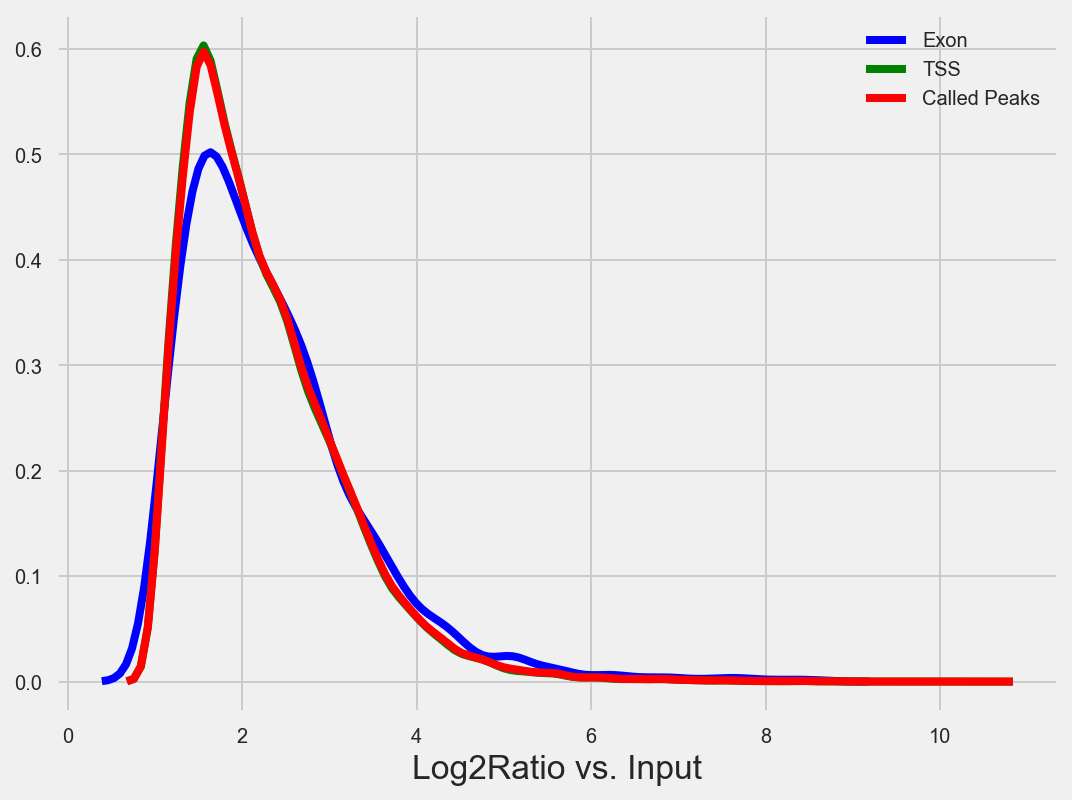

In [240]:
out_f = 'Results/merged/tags_merged'

peaks = pd.read_csv( out_f + '.tss.txt',sep='\t')
print(peaks.shape)
peaks.head()

exon_peaks = pd.read_csv( out_f + '.annexons.txt',sep='\t')
tss_peaks = pd.read_csv( out_f + '.anntss.txt',sep='\t')
f = plt.figure()
ax = plt.subplot(1,1,1)
#f,ax = plt.subplots(111)
sns.distplot(exon_peaks['Log2Ratio vs. Input'],hist=False,ax=ax,color='b',label='Exon')
sns.distplot(tss_peaks['Log2Ratio vs. Input'],hist=False, ax=ax,color='g',label='TSS')
sns.distplot(peak['Log2Ratio vs. Input'],hist=False, ax=ax,color='r',label='Called Peaks')
ax.legend()#(['Exon','TSS','Peak'])

(41328, 17)


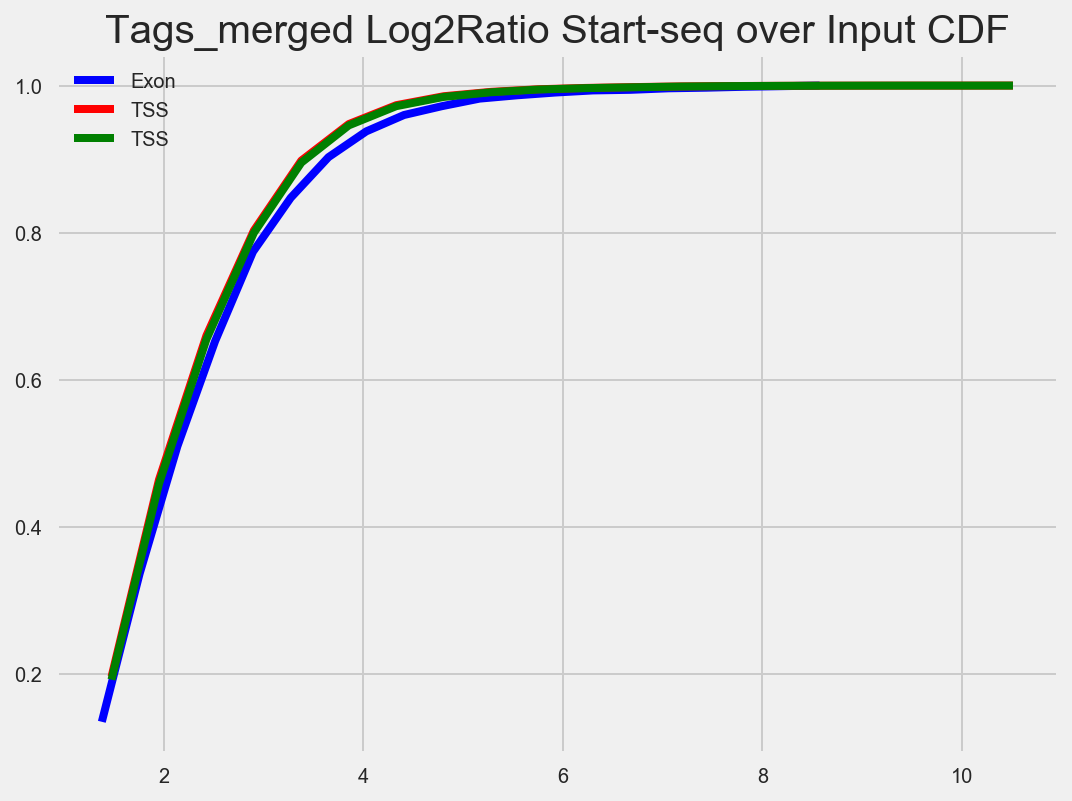

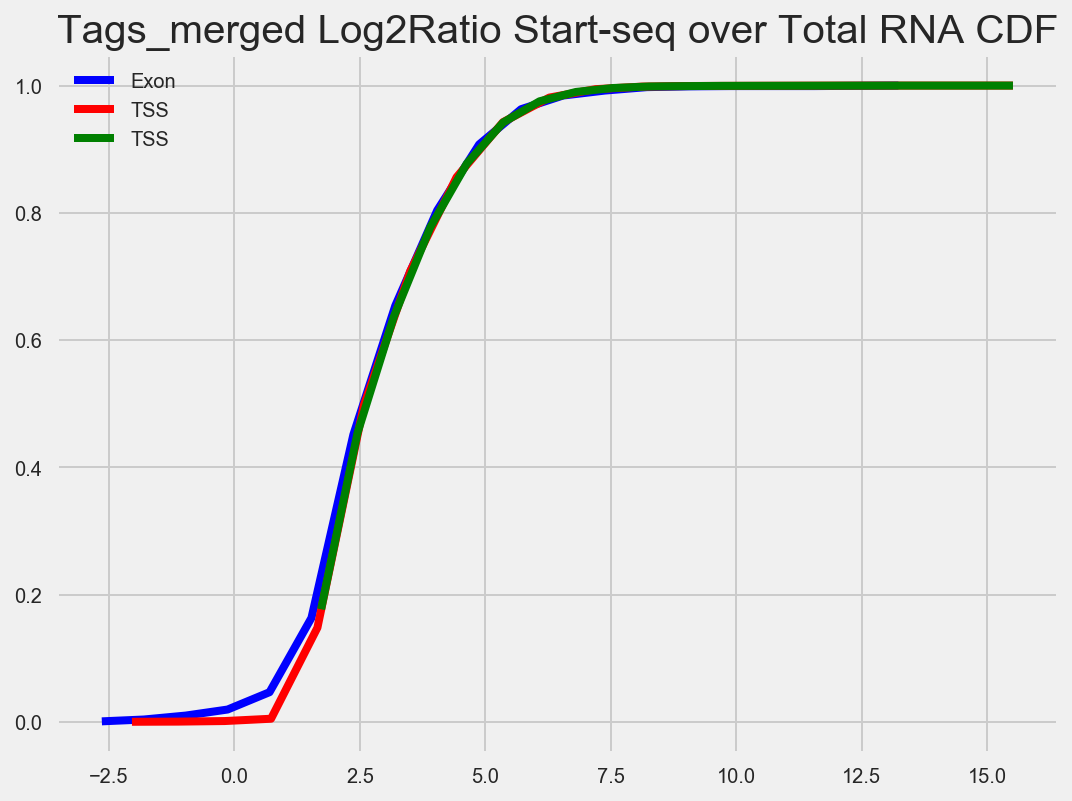

In [243]:
out_f = 'Results/merged/tags_merged'

peaks = pd.read_csv( out_f + '.tss.txt',sep='\t')
print(peaks.shape)
peaks.head()

exon_peaks = pd.read_csv( out_f + '.annexons.txt',sep='\t')
tss_peaks = pd.read_csv( out_f + '.anntss.txt',sep='\t')
name='Tags_merged'
plot_cdf_input(exon_peaks,tss_peaks,peaks,name,is_save=False)
plot_cdf_rna(exon_peaks,tss_peaks,peaks,name,is_save=False)

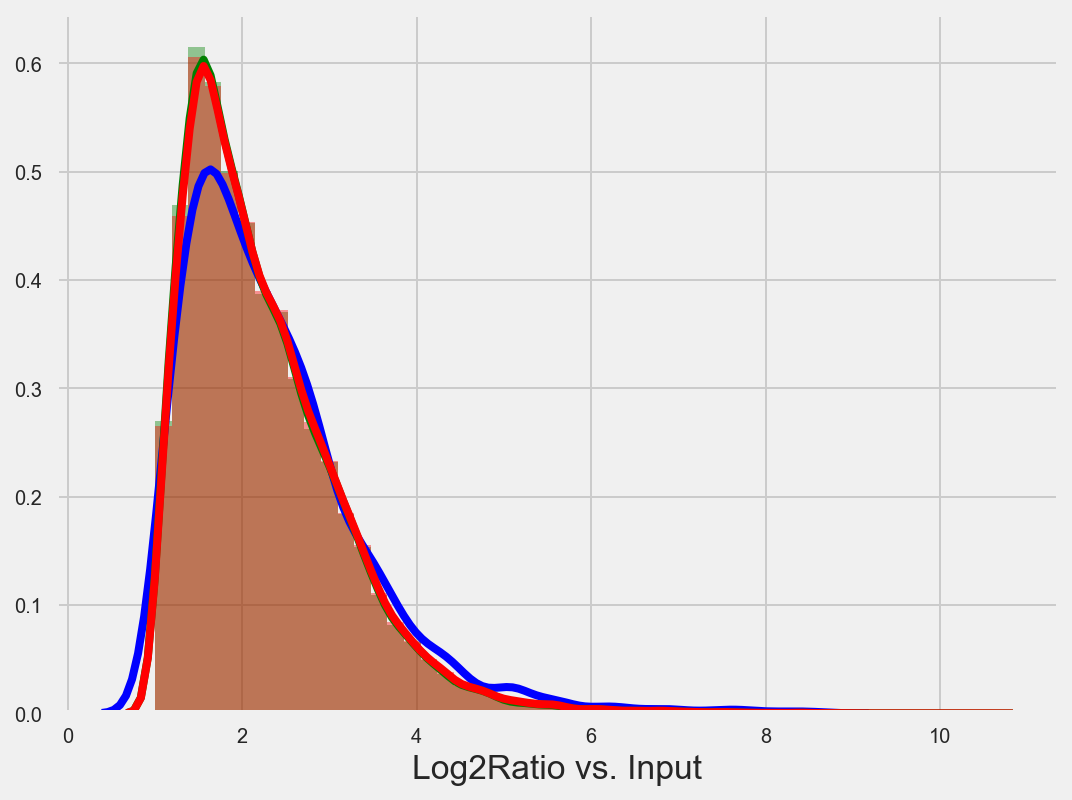

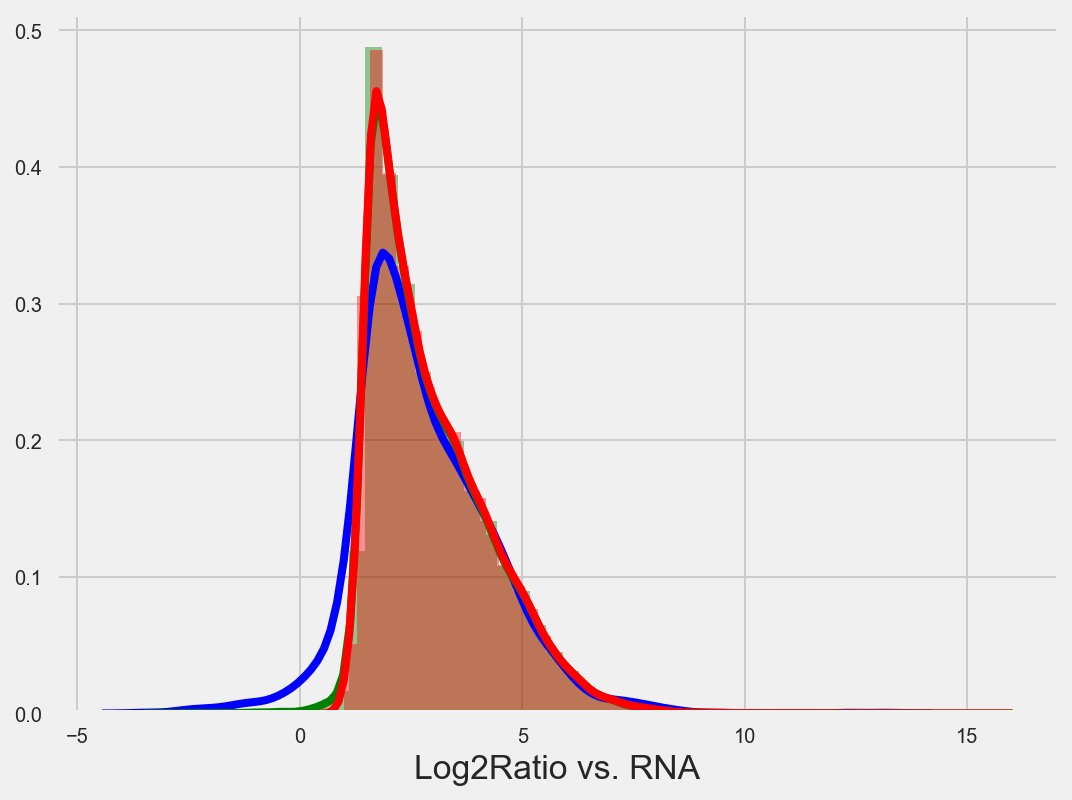

In [245]:
f = plt.figure()
ax = sns.distplot(exon_peaks['Log2Ratio vs. Input'],hist=False)
sns.distplot(tss_peaks['Log2Ratio vs. Input'], ax=ax,color='g')
sns.distplot(peak['Log2Ratio vs. Input'], ax=ax,color='r')

f1 = plt.figure()
ax = sns.distplot(exon_peaks['Log2Ratio vs. RNA'],hist=False)
sns.distplot(tss_peaks['Log2Ratio vs. RNA'], ax=ax,color='g')
sns.distplot(peak['Log2Ratio vs. RNA'], ax=ax,color='r')


## Brain example

In [166]:
peak = pd.read_csv('Results/csRNATSS/Brain.tss.txt',sep='\t')
peak.head()

exon_peaks = pd.read_csv('Results/csRNATSS/Brain.annexons.txt',sep='\t')
tss_peaks = pd.read_csv('Results/csRNATSS/Brain.anntss.txt',sep='\t')


print(exon_peaks.shape)

print(tss_peaks.shape)

print(peak.shape)

name = 'Brain'

f = plt.figure()
num_bins = 20
counts, bin_edges = np.histogram (exon_peaks['Log2Ratio vs. RNA'], bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1],label='Exon')


counts, bin_edges = np.histogram (tss_peaks['Log2Ratio vs. RNA'], bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1],color='r',label='TSS')
plt.title(name + ' Log2Ratio Start-seq over Total RNA CDF' )
plt.legend()


f = plt.figure()
ax = sns.distplot(exon_peaks['Log2Ratio vs. Input'],hist=False)
sns.distplot(tss_peaks['Log2Ratio vs. Input'], ax=ax,color='g')
sns.distplot(peak['Log2Ratio vs. Input'], ax=ax,color='r')


f = plt.figure()
ax = sns.distplot(exon_peaks['Log2Ratio vs. RNA'],hist=False)
sns.distplot(tss_peaks['Log2Ratio vs. RNA'], ax=ax,color='g')
sns.distplot(peak['Log2Ratio vs. RNA'], ax=ax,color='r')


(38833, 17)


In [28]:
peak.describe()

start           end          score    focusRatio          csRNA  \
count  3.883300e+04  3.883300e+04   38833.000000  38833.000000   38833.000000   
mean   1.306570e+07  1.306585e+07     186.849973      0.719626     184.525675   
std    1.468020e+07  1.468020e+07    1615.487196      0.228317    1615.312317   
min    1.730000e+02  2.480000e+02       9.910000      0.002000      15.860000   
25%    3.038115e+06  3.038265e+06      26.200000      0.551000      25.380000   
50%    8.136627e+06  8.136777e+06      50.400000      0.751000      48.380000   
75%    1.723553e+07  1.723568e+07     140.400000      0.938000     136.800000   
max    8.004589e+07  8.004604e+07  292098.900000      1.000000  292098.870000   

         csRNAinput        rnaseq  Log2Ratio vs. Input  Log2Ratio vs. RNA  
count  38833.000000  38833.000000         38833.000000       38833.000000  
mean       8.837040      1.572076             2.621981           3.129304  
std       24.594684      7.105474             1.006830           1.453604  
min        0.000000      0.000000             1.001009           1.552792  
25%        0.000000      0.000000             1.832507           1.972233  
50%        2.520000      0.170000             2.387413           2.672717  
75%        7.560000      1.040000             3.236684           3.926643  
max      909.250000    430.950000             8.669636          13.039273

In [248]:
peak

#tssID       chr     start       end strand      score  \
0         picr_48-1   picr_48   1084632   1084782      +  377834.30   
1         picr_35-1   picr_35    689623    689773      -  115137.40   
2         picr_33-1   picr_33   4827665   4827815      +  112840.10   
3         picr_64-1   picr_64  11363591  11363741      +   60970.10   
4         picr_13-1   picr_13  30535313  30535463      +   56786.30   
5         picr_56-1   picr_56  12601780  12601930      +   50777.60   
6         picr_73-1   picr_73    107249    107399      +   46732.10   
7        picr_102-1  picr_102   1919354   1919504      +   46537.70   
8         picr_54-1   picr_54   9283364   9283514      +   36064.30   
9         picr_36-1   picr_36  10180621  10180771      +   30776.80   
10        picr_13-2   picr_13   8896549   8896699      +   25069.10   
11         picr_9-1    picr_9  17081404  17081554      +   20785.30   
12        picr_54-2   picr_54   1311860   1312010      +   20150.00   
13        picr_53-1   picr_53   4461536   4461686      +   17649.00   
14         picr_4-1    picr_4  16543531  16543681      -   17303.20   
15        picr_12-1   picr_12  22324200  22324350      +   17158.70   
16       picr_136-1  picr_136    765342    765492      -   17096.90   
17         picr_0-1    picr_0  19135517  19135667      -   15354.70   
18        picr_36-2   picr_36  10085038  10085188      +   14890.50   
19        picr_75-1   picr_75   3412796   3412946      -   14303.40   
20       picr_114-1  picr_114   3985953   3986103      +   14089.90   
21        picr_56-2   picr_56  12595434  12595584      +   13167.00   
22        picr_36-3   picr_36  10050654  10050804      -   13071.40   
23         picr_9-2    picr_9   2196009   2196159      +   12103.00   
24         picr_2-1    picr_2   4771086   4771236      +   11448.50   
25         picr_1-1    picr_1  48287870  48288020      +   11144.10   
26        picr_19-1   picr_19   4124417   4124567      -   11076.30   
27        picr_98-1   picr_98   5313258   5313408      +   10836.70   
28        picr_21-1   picr_21    978034    978184      -    9798.50   
29         picr_8-1    picr_8  32696172  32696322      +    9423.80   
...             ...       ...       ...       ...    ...        ...   
41298   picr_22-939   picr_22  14067765  14067915      -      11.90   
41299   picr_164-16  picr_164    320588    320738      +      14.40   
41300   picr_8-1307    picr_8  39566403  39566553      -      20.00   
41301   picr_65-199   picr_65   4356837   4356987      -      13.30   
41302   picr_94-138   picr_94   6509954   6510104      +      10.50   
41303   picr_61-387   picr_61  10383649  10383799      +      21.10   
41304   picr_0-1597    picr_0  16144006  16144156      +      18.40   
41305   picr_8-1456    picr_8  19726251  19726401      +      17.00   
41306   picr_27-480   picr_27  11841194  11841344      +      18.40   
41307   picr_42-185   picr_42   3097061   3097211      +      15.20   
41308   picr_42-188   picr_42  11171220  11171370      -      15.20   
41309   picr_38-444   picr_38  12262201  12262351      -      17.70   
41310   picr_10-565   picr_10  40493494  40493644      +      16.70   
41311  picr_101-118  picr_101   5968671   5968821      +      17.40   
41312   picr_16-345   picr_16  14443951  14444101      -      29.40   
41313   picr_42-178   picr_42  12404424  12404574      -      15.70   
41314   picr_1-1142    picr_1  15765030  15765180      +      15.00   
41315    picr_4-865    picr_4   9002744   9002894      +      16.80   
41316    picr_97-31   picr_97   1005783   1005933      +      17.40   
41317   picr_56-326   picr_56   9244787   9244937      +      15.90   
41318   picr_2-1316    picr_2  38764739  38764889      -      17.80   
41319   picr_56-335   picr_56   7229003   7229153      -      15.20   
41320  picr_106-239  picr_106   3376903   3377053      +      17.60   
41321    picr_3-863    picr_3  20220962  20221112      +      18.60   
41322    picr_6-645    picr_6  260509

# Other results/stats
out.stats.txt, out.inputDistribution.txt, and out.rnaDistribution.txt,

In [23]:
rnaDist = pd.read_csv('Results/csRNATSS/Brain.rnaDistribution.txt',sep='\t',header=None,index_col=None)
print(rnaDist.shape)

inputDist = pd.read_csv('Results/csRNATSS/Brain.inputDistribution.txt',sep='\t',header=None)
print(inputDist.shape)

(7389, 4)
(7389, 4)


In [50]:
pd.read_csv('Results/csRNATSS/Brain.stats.txt',sep='\t',index_col=0)

Total TSS
Set                                                          
total                                                 50147.0
valid TSS                                             38833.0
total over input                                      46506.0
 under RNA                                             7673.0
 valid Annotation: 43459                                  NaN
 exon Annotation: 3047                                    NaN
Total input                                            3641.0
log2 fold vs. input: 1                                    NaN
log2 fold vs. rna: 1.55213110825378                       NaN
Number of TSS regions for foldChange Calculatio...        NaN
Number of exon regions for foldChange Calculati...        NaN

In [47]:
rnaDist

0         1         2         3
0     11.850621  0.000135  0.000000  0.000135
1     10.956068  0.000271  0.000000  0.000271
2     10.686288  0.000406  0.000088  0.000318
3     10.279284  0.000541  0.000175  0.000366
4     10.054513  0.000677  0.000175  0.000502
5      9.692357  0.000812  0.000263  0.000549
6      9.627270  0.000947  0.000350  0.000597
7      9.593161  0.001083  0.000438  0.000645
8      9.425710  0.001218  0.000438  0.000780
9      9.356594  0.001353  0.000438  0.000916
10     9.166726  0.001489  0.000700  0.000788
11     9.147232  0.001624  0.000700  0.000924
12     9.145304  0.001759  0.000700  0.001059
13     9.083084  0.001895  0.000700  0.001194
14     8.932962  0.002030  0.000788  0.001242
15     8.869652  0.002165  0.000963  0.001203
16     8.828686  0.002301  0.000963  0.001338
17     8.819844  0.002436  0.000963  0.001473
18     8.774359  0.002571  0.001050  0.001521
19     8.749729  0.002707  0.001138  0.001569
20     8.728719  0.002842  0.001225  0.001617
21     8.706330  0.002977  0.001225  0.001752
22     8.686138  0.003113  0.001225  0.001887
23     8.617918  0.003248  0.001488  0.001760
24     8.585358  0.003383  0.001488  0.001895
25     8.561078  0.003519  0.001575  0.001943
26     8.549422  0.003654  0.001751  0.001904
27     8.528723  0.003789  0.001838  0.001951
28     8.528281  0.003925  0.001838  0.002087
29     8.522463  0.004060  0.001838  0.002222
...         ...       ...       ...       ...
7359  -0.007496  0.996075  0.948709  0.047366
7360  -0.029544  0.996211  0.949497  0.046714
7361  -0.080962  0.996346  0.951947  0.044398
7362  -0.097031  0.996481  0.952823  0.043658
7363  -0.115948  0.996617  0.953873  0.042744
7364  -0.126771  0.996752  0.954573  0.042179
7365  -0.154853  0.996887  0.955799  0.041089
7366  -0.159364  0.997023  0.956061  0.040961
7367  -0.249461  0.997158  0.959387  0.037771
7368  -0.375527  0.997293  0.964114  0.033179
7369  -0.422645  0.997429  0.965864  0.031564
7370  -0.494547  0.997564  0.968228  0.029336
7371  -0.579799  0.997699  0.970853  0.026846
7372  -0.594525  0.997835  0.971291  0.026544
7373  -0.605168  0.997970  0.971991  0.025979
7374  -0.609210  0.998105  0.971991  0.026114
7375  -0.700642  0.998241  0.974617  0.023624
7376  -0.742545  0.998376  0.975055  0.023321
7377  -0.981964  0.998511  0.981707  0.016805
7378  -1.013244  0.998647  0.982319  0.016327
7379  -1.041431  0.998782  0.982757  0.016025
7380  -1.135181  0.998917  0.984333  0.014585
7381  -1.245009  0.999053  0.986696  0.012357
7382  -1.692755  0.999188  0.992910  0.006278
7383  -2.083645  0.999323  0.995974  0.003350
7384  -2.518271  0.999459  0.997637  0.001822
7385  -3.120160  0.999594  0.999212  0.000382
7386  -5.275725  0.999729  0.999825 -0.000096
7387  -5.849048  0.999865  0.999912 -0.000048
7388  -5.929890  1.000000  0.999912  0.000088

[7389 rows x 4 columns]

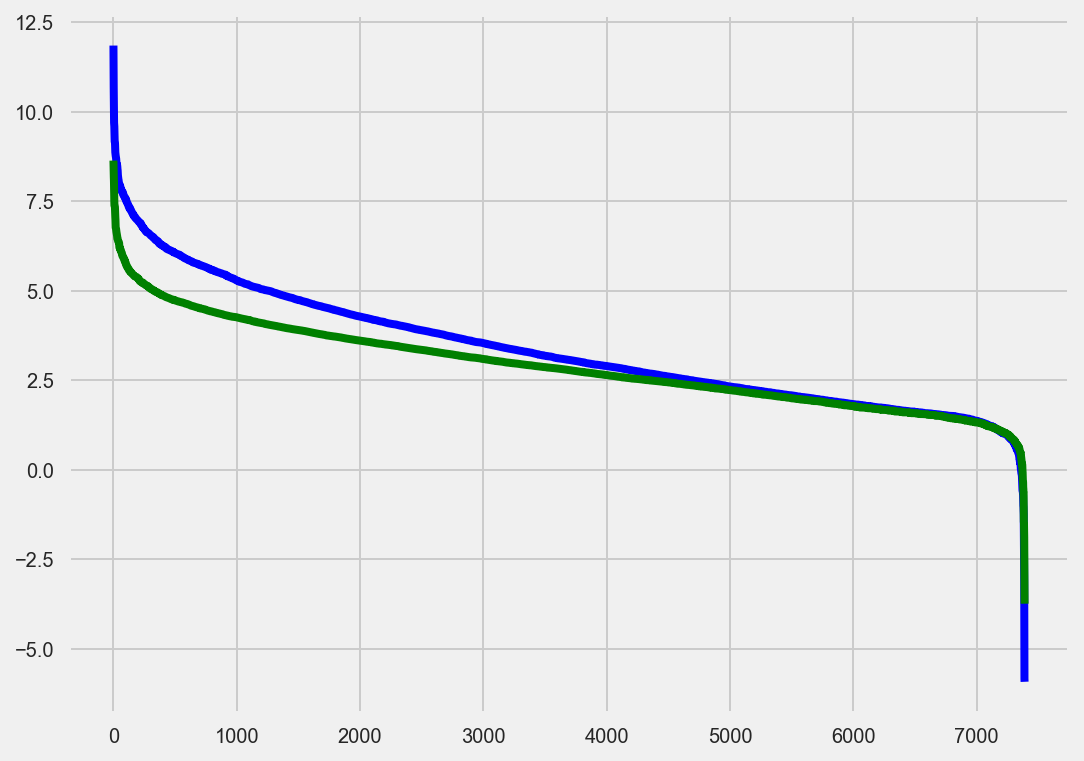

In [57]:
f = plt.figure()
plt.plot(rnaDist[0])
plt.plot(inputDist[0],color='g')

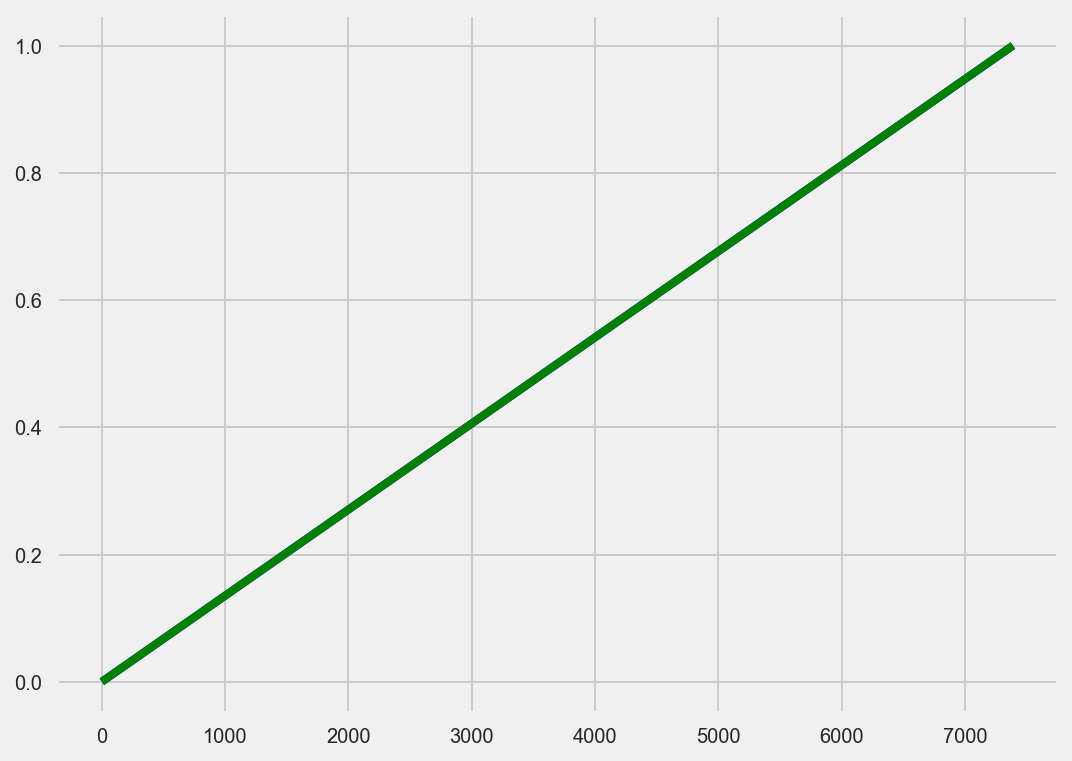

In [59]:
f = plt.figure()
plt.plot(rnaDist[1])
plt.plot(inputDist[1],color='g')

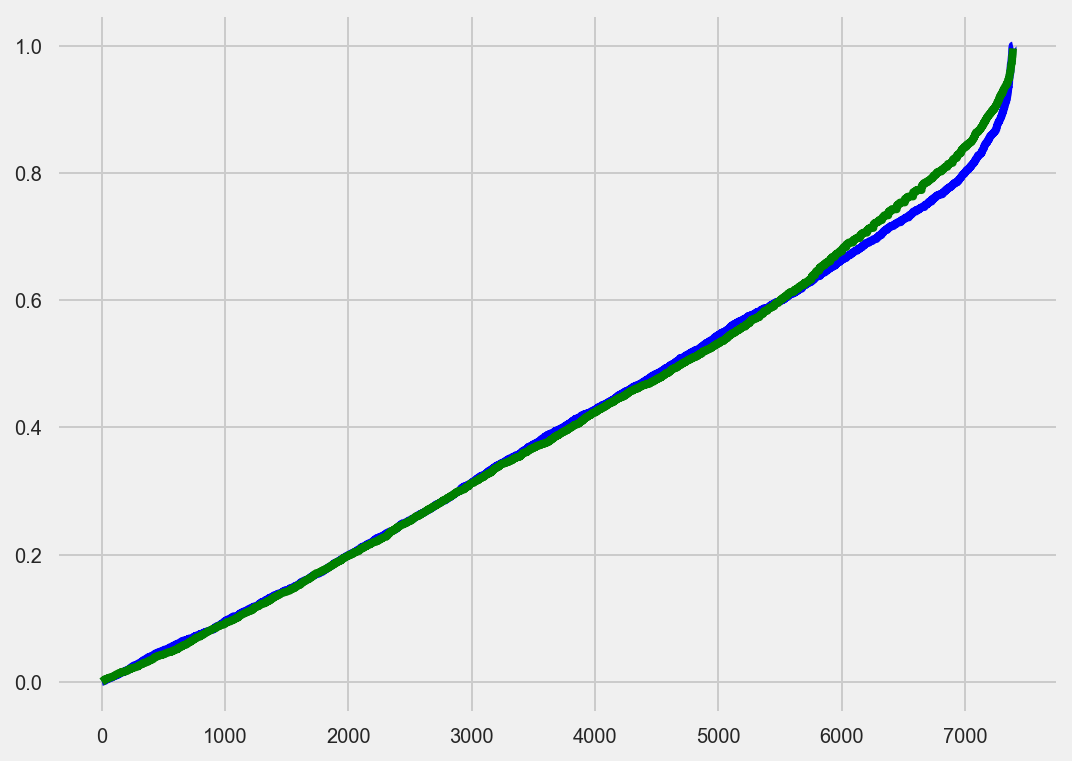

In [61]:
plt.plot(rnaDist[2])
plt.plot(inputDist[2],color='g')

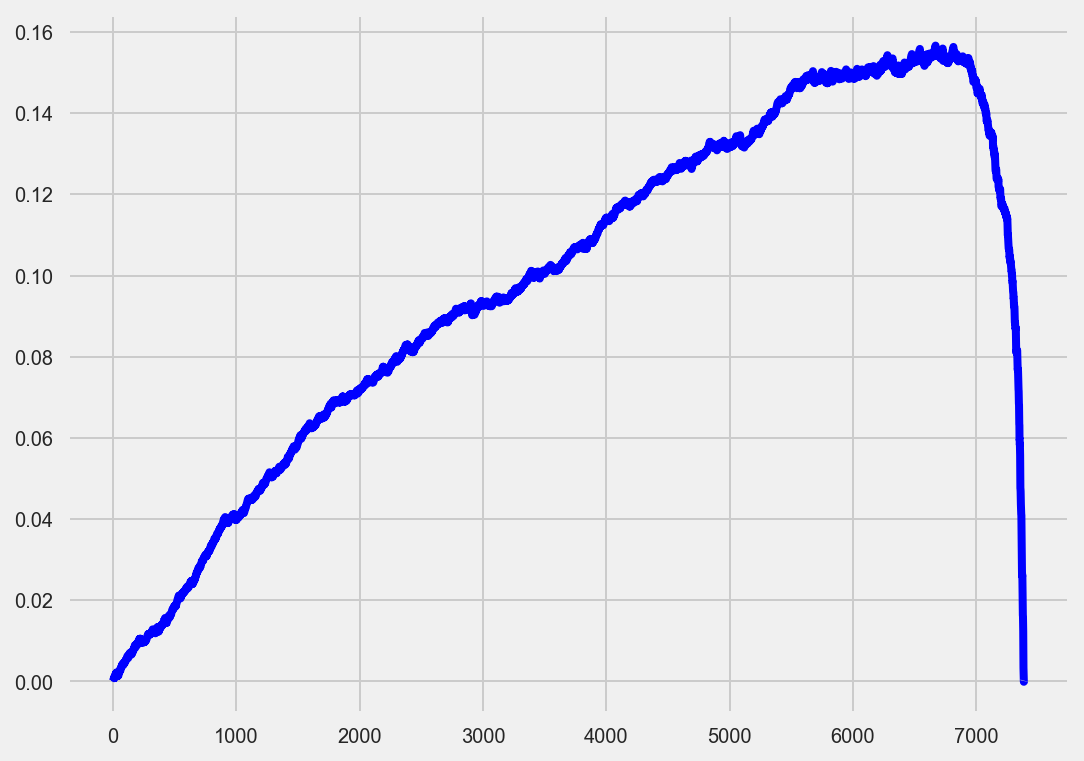

In [56]:
plt.plot(rnaDist[3])

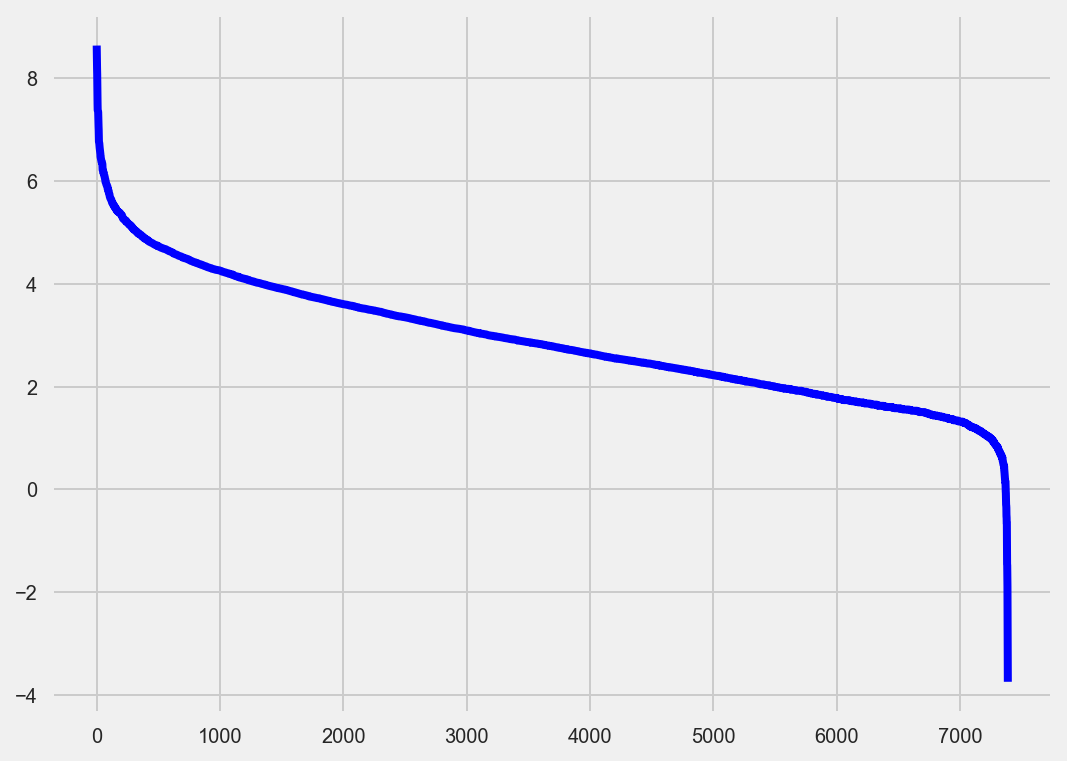

In [53]:
plt.plot(inputDist[0])

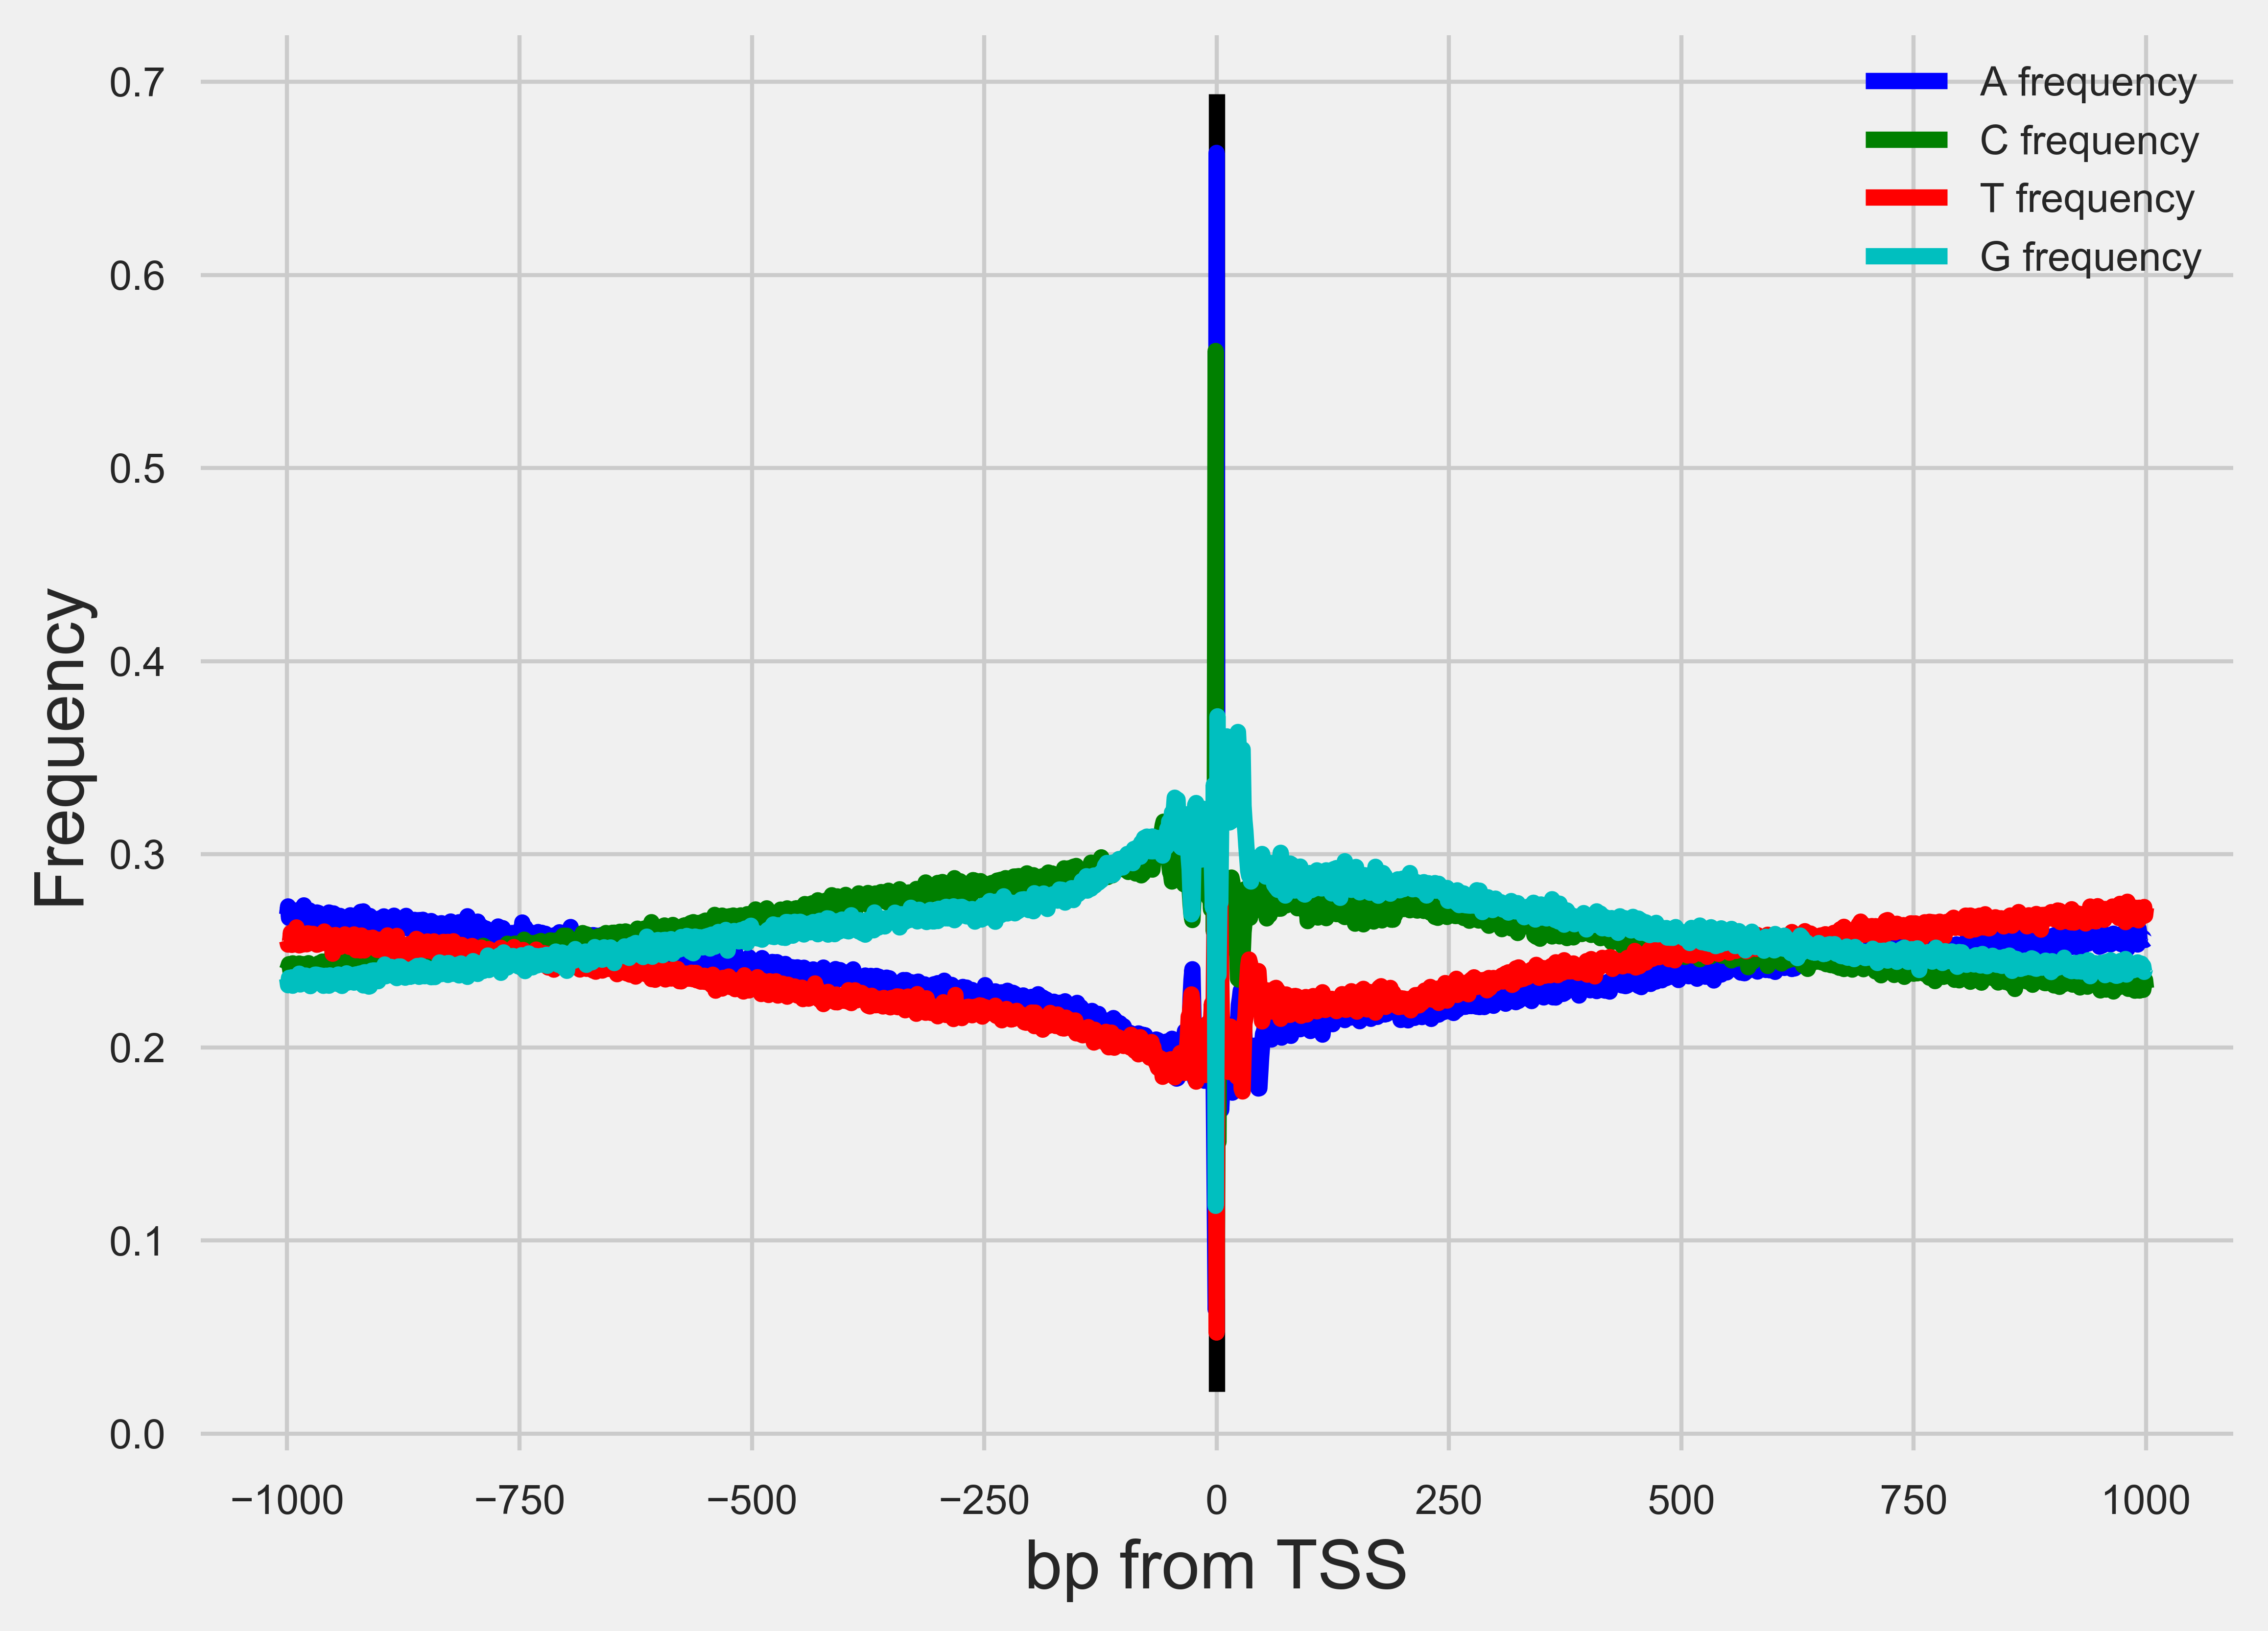

In [246]:
homer_nucleotide('Results/csRNATSS/CHO_trim_CHO--mSTART-JHS823_S21_R1_001.fastq_trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq.tss.txt.freq.tsv','Results/csRNATSS/CHO.tss_NUC',
                 '/data/isshamie/genome/picr.fa',only_plot=True)

(-100, 100)

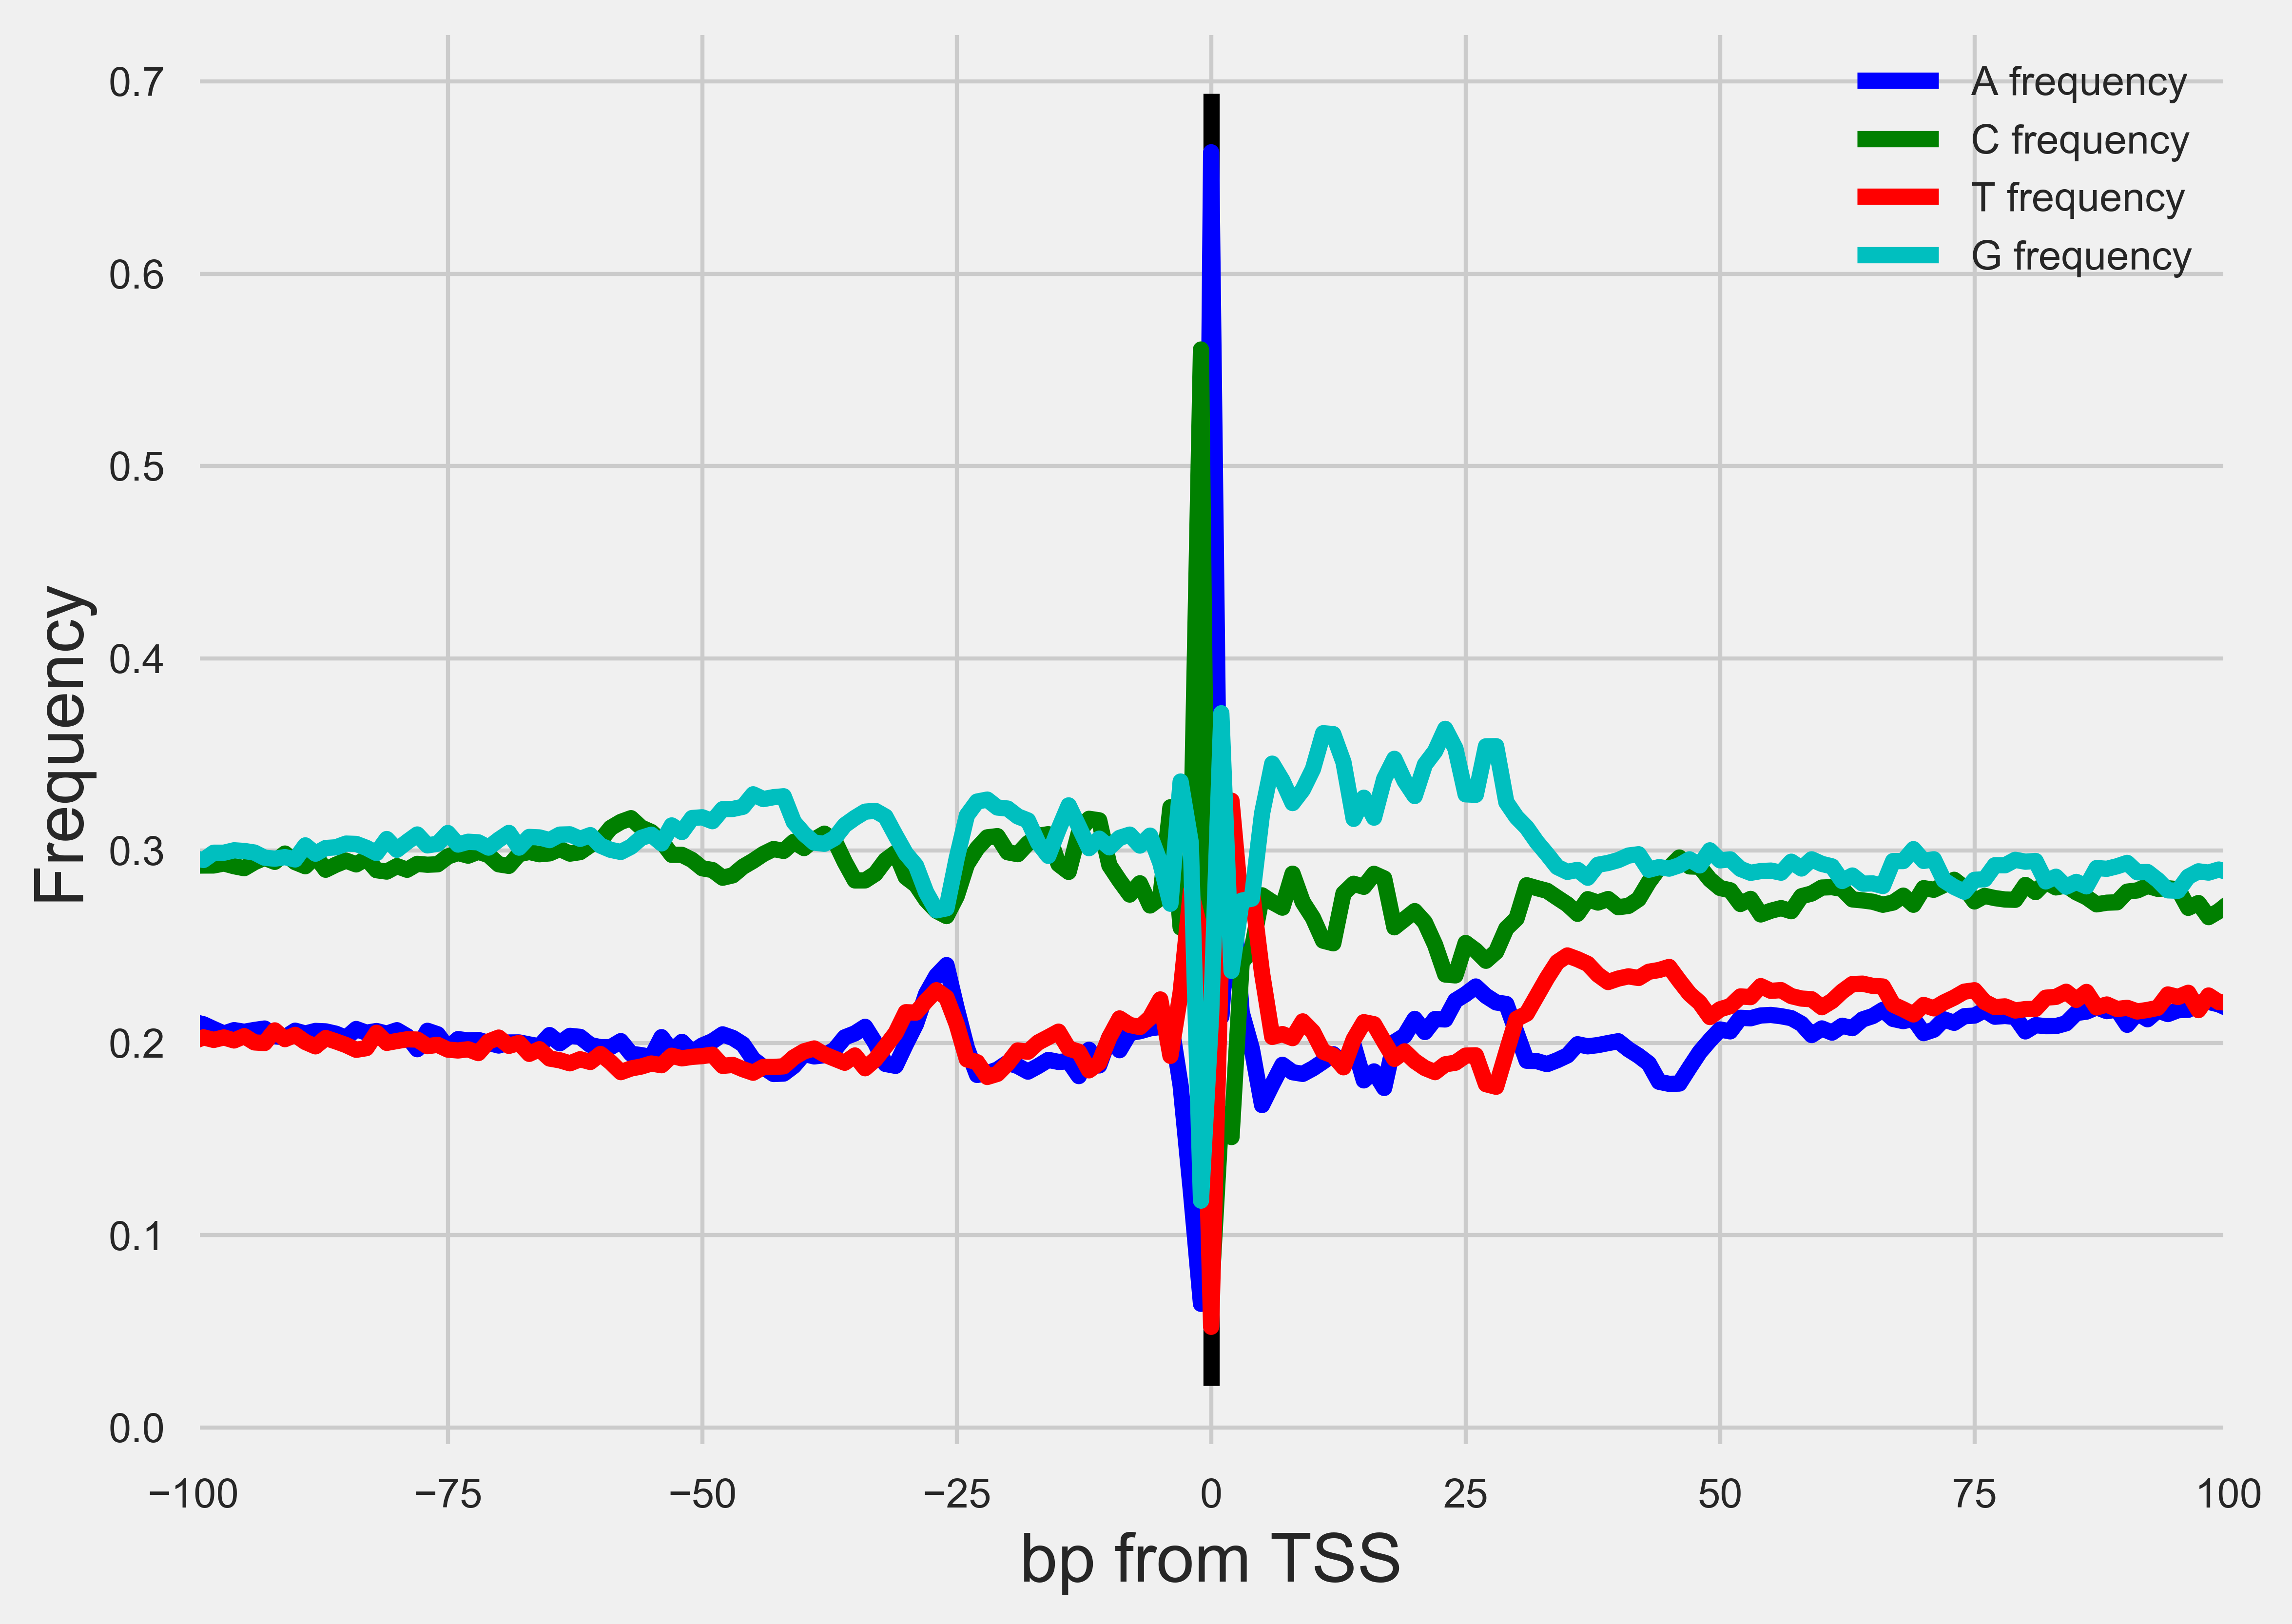

In [247]:
nuc_freq = pd.read_csv('Results/csRNATSS/CHO_trim_CHO--mSTART-JHS823_S21_R1_001.fastq_trim_CHO--mSTART_input-JHS802_S11_R1_001.fastq.tss.txt.freq.tsv',sep='\t',index_col=0)
nuc_freq
f = plt.figure(dpi=300)
ax = f.add_subplot(111)
ax.plot(nuc_freq.index.values,nuc_freq['A frequency'])
ax.plot(nuc_freq.index.values,nuc_freq['C frequency'])
ax.plot(nuc_freq.index.values,nuc_freq['T frequency'])
ax.plot(nuc_freq.index.values,nuc_freq['G frequency'])
ax.vlines(0,ax.get_ylim()[0],ax.get_ylim()[1])
ax.legend()
ax.set_xlabel('bp from TSS')
ax.set_ylabel('Frequency')
ax.set_xlim([-100,100])

## Create confident score for rna tss

# Compare original peaks called to this

In [66]:
pd.read_csv('/data/isshamie/TSS/Processed/Brain/GRO/f04_peaks/trim_CHBrain_5GRO_JHS1036_SD_ATGTCA_S51_L003_R1_001.fastq_and_trim_CHBrain_GRO_JHS1029_SD_CACCGG_S44_L003_R1_001.fastq_bg_2.peak',
            sep='\t',comment='#',skiprows=36)

picr_13-1    picr_13  30535313  30535463  +   29209.9  0.999  \
0        picr_21-1    picr_21    111521    111671  -  5090.200  0.997   
1        picr_56-1    picr_56  12601780  12601930  +  4717.400  0.998   
2         picr_3-1     picr_3  42026399  42026549  -  3774.200  0.905   
3        picr_74-1    picr_74   4078025   4078175  -  2953.700  0.928   
4         picr_8-1     picr_8  32696172  32696322  +  2484.400  0.973   
5         picr_8-2     picr_8  29065702  29065852  -  2300.600  0.998   
6        picr_35-1    picr_35   2866296   2866446  +  1926.500  0.990   
7        picr_93-1    picr_93   5056762   5056912  +  1383.600  0.999   
8        picr_87-1    picr_87    754291    754441  +  1128.600  0.985   
9        picr_16-1    picr_16  20909688  20909838  +  1126.400  0.997   
10        picr_8-3     picr_8  32678234  32678384  -  1100.400  0.672   
11       picr_84-1    picr_84   2998445   2998595  -  1014.500  0.855   
12       picr_7b-1    picr_7b  24939631  24939781  +   960.300  0.856   
13       picr_19-1    picr_19   3145832   3145982  +   918.700  0.972   
14       picr_44-1    picr_44  15269128  15269278  +   909.800  0.914   
15       picr_35-2    picr_35   3790958   3791108  +   885.100  0.976   
16       picr_16-2    picr_16   8555017   8555167  -   884.600  0.322   
17       picr_20-1    picr_20  25520957  25521107  -   780.200  0.764   
18       picr_43-1    picr_43   9727425   9727575  -   763.800  0.870   
19      picr_117-1   picr_117   4417054   4417204  +   750.500  0.917   
20       picr_58-1    picr_58   9760358   9760508  -   747.100  0.637   
21        picr_3-2     picr_3  63137742  63137892  -   740.100  0.911   
22     picr_1500-1  picr_1500      5932      6082  +   739.000  0.999   
23      picr_116-1   picr_116    196172    196322  +   727.300  0.957   
24       picr_87-2    picr_87   4892095   4892245  -   718.200  0.715   
25       picr_17-1    picr_17   1360122   1360272  +   717.100  1.000   
26       picr_52-1    picr_52   6233864   6234014  +   711.100  0.991   
27       picr_22-1    picr_22  12039140  12039290  +   710.700  0.566   
28       picr_56-2    picr_56  12595434  12595584  +   710.000  0.998   
29        picr_0-1     picr_0  64458634  64458784  +   701.200  0.646   
...            ...        ...       ...       ... ..       ...    ...   
85681  picr_98-600    picr_98   1002488   1002638  +     0.793  0.952   
85682  picr_98-602    picr_98   1091449   1091599  -     0.793  0.952   
85683  picr_98-604    picr_98   1225088   1225238  +     0.793  0.952   
85684  picr_98-606    picr_98   1589128   1589278  +     0.793  0.400   
85685  picr_98-607    picr_98   1775807   1775957  -     0.793  0.952   
85686  picr_98-608    picr_98   1823326   1823476  +     0.793  0.952   
85687  picr_98-610    picr_98   2128476   2128626  -     0.793  0.952   
85688  picr_98-612    picr_98   3838311   3838461  +     0.793  0.952   
85689  picr_98-618    picr_98   4009025   4009175  -     0.793  0.952   
85690  picr_98-619    picr_98   4553004   4553154  +     0.793  0.952   
85691  picr_98-620    picr_98   4613797   4613947  +     0.793  0.643   
85692  picr_98-621    picr_98   4670603   4670753  -     0.793  0.952   
85693  picr_98-627    picr_98   6022785   6022935  -     0.793  0.952   
85694  picr_98-628    picr_98   6041913   6042063  -     0.793  0.905   
85695  picr_98-630    picr_98   6485284   6485434  -     0.793  0.952   
85696  picr_98-589    picr_98   6583252   6583402  -     0.793  0.952   
85697  picr_98-634    picr_98   6776211   6776361  -     0.793  0.952   
85698  picr_98-637    picr_98   7086296   7086446  +     0.793  0.382   
85699  picr_99-102    picr_99   1495668   1495818  -     0.793  0.952   
85700  picr_99-104    picr_99   1899973   1900123  +     0.793  0.952   
85701  picr_99-105    picr_99   3333032   3333182  +     0.793  0.952   
85702  picr_99-106    picr_99   3433847   3433997  -     0.793  0.952   
85703  picr_99-107    picr_99   3656335   3656485  +     0.793  0.9